In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================
# Cell 01 — Paths, Folders, and Dataset Probe (MOT20)
#  • Uses your Drive paths as given
#  • Creates project folders under /content/DPF-MOT20/results
#  • Verifies structure for train/test sequences
#  • Writes a probe report for reproducibility
# ============================================================
import os, json, sys, re
from pathlib import Path
import shutil
import glob

# ---------- CONFIG: edit only if your Drive path changes ----------
MOT20_ROOT = Path("/content/drive/MyDrive/Thesis/MOT20")  # <- your path
PROJECT_ROOT = Path("/content/DPF-MOT20")
RES = PROJECT_ROOT / "results"
DIRS = {
    "dets": RES / "dets",
    "dets_calib": RES / "dets_calib",
    "reid": RES / "reid",
    "tracks_probe": RES / "tracks_probe",
    "analysis": RES / "analysis",
    "preview": RES / "preview",
}

TRAIN_SEQS = ["MOT20-01", "MOT20-02", "MOT20-03", "MOT20-05"]
TEST_SEQS  = ["MOT20-04", "MOT20-06", "MOT20-07", "MOT20-08"]

# ---------- helpers ----------
def count_images(img_dir: Path) -> int:
    if not img_dir.exists(): return 0
    return len(sorted(img_dir.glob("*.jpg")))

def must_exist(path: Path, what: str):
    if not path.exists():
        raise FileNotFoundError(f"Missing {what}: {path}")
    return True

def read_seqinfo(seqinfo_path: Path):
    info = {"imDir": None, "frameRate": None, "seqLength": None, "imWidth": None, "imHeight": None}
    if not seqinfo_path.exists():
        return info
    txt = seqinfo_path.read_text(errors="ignore").splitlines()
    for ln in txt:
        if ln.startswith("imDir="):      info["imDir"] = ln.split("=",1)[1].strip()
        elif ln.startswith("frameRate="): info["frameRate"] = ln.split("=",1)[1].strip()
        elif ln.startswith("seqLength="): info["seqLength"] = ln.split("=",1)[1].strip()
        elif ln.startswith("imWidth="):   info["imWidth"] = ln.split("=",1)[1].strip()
        elif ln.startswith("imHeight="):  info["imHeight"] = ln.split("=",1)[1].strip()
    return info

# ---------- create project dirs ----------
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
for k, d in DIRS.items():
    d.mkdir(parents=True, exist_ok=True)

print("📁 Project root:", PROJECT_ROOT)
print("📁 Results subdirs:", {k: str(v) for k,v in DIRS.items()})

# ---------- dataset probe ----------
probe = {
    "paths": {
        "MOT20_ROOT": str(MOT20_ROOT),
        "PROJECT_ROOT": str(PROJECT_ROOT),
        **{f"results_{k}": str(v) for k,v in DIRS.items()},
    },
    "train": {},
    "test": {},
    "summary": {},
}

# check root
must_exist(MOT20_ROOT, "MOT20 root")
must_exist(MOT20_ROOT / "train", "MOT20/train")
must_exist(MOT20_ROOT / "test",  "MOT20/test")

def check_seq(split: str, seq_name: str):
    base = MOT20_ROOT / split / seq_name
    img_dir = base / "img1"
    seqinfo = base / "seqinfo.ini"
    det_txt  = base / "det" / "det.txt"
    gt_txt   = base / "gt" / "gt.txt" if split == "train" else None

    # required components
    must_exist(base, f"{split}/{seq_name}")
    must_exist(img_dir, f"{split}/{seq_name}/img1")
    must_exist(seqinfo, f"{split}/{seq_name}/seqinfo.ini")
    must_exist(det_txt, f"{split}/{seq_name}/det/det.txt")
    if gt_txt is not None:
        must_exist(gt_txt, f"{split}/{seq_name}/gt/gt.txt")

    n_imgs = count_images(img_dir)
    info = read_seqinfo(seqinfo)
    out = {
        "img_dir": str(img_dir),
        "seqinfo": str(seqinfo),
        "det": str(det_txt),
        "gt": str(gt_txt) if gt_txt is not None else None,
        "n_images": n_imgs,
        "seqinfo_meta": info,
    }
    return out

# train sequences
for s in TRAIN_SEQS:
    try:
        probe["train"][s] = check_seq("train", s)
    except Exception as e:
        print(f"❌ Probe error (train/{s}): {e}")
        raise

# test sequences
for s in TEST_SEQS:
    try:
        probe["test"][s] = check_seq("test", s)
    except Exception as e:
        print(f"❌ Probe error (test/{s}): {e}")
        raise

# summary
probe["summary"]["train_seq_count"] = len(probe["train"])
probe["summary"]["test_seq_count"]  = len(probe["test"])
probe["summary"]["train_images_total"] = sum(d["n_images"] for d in probe["train"].values())
probe["summary"]["test_images_total"]  = sum(d["n_images"] for d in probe["test"].values())

# write probe report
report_path = DIRS["analysis"] / "dataset_probe.json"
report_path.write_text(json.dumps(probe, indent=2))
print("\n✅ Dataset probe complete.")
print("   Train seqs:", TRAIN_SEQS)
print("   Test  seqs:", TEST_SEQS)
print(f"   Total train images: {probe['summary']['train_images_total']}")
print(f"   Total test  images: {probe['summary']['test_images_total']}")
print("📝 Wrote probe report ->", report_path)

# ---------- detector source decision (we'll use provided det.txt) ----------
# We will treat each seq's det/det.txt as the RAW detector output.
# The next cell will read these and produce calibrated scores per sequence to improve IDF1/MOTA.
print("\n🔒 Detector source: Using provided det/det.txt for ALL sequences (raw).")
print("   Next: Cell 02 will install runtime deps; Cell 03 will run detection calibration per sequence.")

📁 Project root: /content/DPF-MOT20
📁 Results subdirs: {'dets': '/content/DPF-MOT20/results/dets', 'dets_calib': '/content/DPF-MOT20/results/dets_calib', 'reid': '/content/DPF-MOT20/results/reid', 'tracks_probe': '/content/DPF-MOT20/results/tracks_probe', 'analysis': '/content/DPF-MOT20/results/analysis', 'preview': '/content/DPF-MOT20/results/preview'}

✅ Dataset probe complete.
   Train seqs: ['MOT20-01', 'MOT20-02', 'MOT20-03', 'MOT20-05']
   Test  seqs: ['MOT20-04', 'MOT20-06', 'MOT20-07', 'MOT20-08']
   Total train images: 8931
   Total test  images: 4479
📝 Wrote probe report -> /content/DPF-MOT20/results/analysis/dataset_probe.json

🔒 Detector source: Using provided det/det.txt for ALL sequences (raw).
   Next: Cell 02 will install runtime deps; Cell 03 will run detection calibration per sequence.


In [ ]:
# ============================================================
# Cell 02a — Install Py3.12-compatible numeric stack + restart
#  • This WILL restart your Colab kernel at the end (by design)
# ============================================================
import sys, subprocess, os

pkgs = [
    "numpy==2.1.3",
    "scipy==1.13.1",
    "pandas==2.2.3",
    "opencv-python-headless==4.10.0.84",
    "scikit-learn==1.5.2",
    "tqdm==4.66.5",
    "matplotlib==3.9.2",
]
print("⬇️ Installing core packages ...")
subprocess.run([sys.executable, "-m", "pip", "install", "-qU"] + pkgs, check=True)
print("✅ Installs complete. 🔄 Forcing a clean runtime restart now...")
# Hard-restart the Colab kernel to clear old ABI state
os.kill(os.getpid(), 9)

⬇️ Installing core packages ...


In [ ]:
# ============================================================
# Cell 02b — Env summary + sanity checks (post-restart)
# ============================================================
import os, sys, json, random
from pathlib import Path

# Safe threading
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Deterministic seeds
SEED = 42
random.seed(SEED)

import numpy as np
np.random.seed(SEED)  # OK with NumPy 2.x
import pandas as pd, cv2, scipy, sklearn, tqdm, matplotlib
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

def gpu_info():
    try:
        import torch
        return {
            "torch": torch.__version__,
            "cuda_available": bool(torch.cuda.is_available()),
            "cuda_version": getattr(torch.version, "cuda", "n/a"),
            "device": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
        }
    except Exception as e:
        return {"torch": "not-installed", "cuda_available": False, "cuda_version": "n/a", "device": "CPU", "err": str(e)}

summary = {
    "python": sys.version,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "opencv": cv2.__version__,
    "scipy": scipy.__version__,
    "scikit_learn": sklearn.__version__,
    "tqdm": getattr(tqdm, "__version__", "n/a"),
    "matplotlib": matplotlib.__version__,
    "gpu": gpu_info(),
}

ROOT = Path("/content/DPF-MOT20")
ANALY = ROOT / "results" / "analysis"
ANALY.mkdir(parents=True, exist_ok=True)
(ANALY / "env_summary.json").write_text(json.dumps(summary, indent=2))

print("🧪 Environment summary:")
for k, v in summary.items():
    print(f"  {k}: {v}")

# SciPy Hungarian sanity
C = np.array([[0.1, 1.0, 0.8],
              [0.9, 0.2, 0.3],
              [0.7, 0.6, 0.4]], dtype=np.float32)
r, c = linear_sum_assignment(C)
assert len(r) == 3 and len(c) == 3
print("✅ SciPy Hungarian sanity passed:", list(zip(r.tolist(), c.tolist())))

# OpenCV write/read sanity
tmp = ROOT / "results" / "preview"
tmp.mkdir(parents=True, exist_ok=True)
img_path = tmp / "opencv_probe.png"
img = (np.ones((32, 32, 3), dtype=np.uint8) * 200)
cv2.imwrite(str(img_path), img)
probe = cv2.imread(str(img_path))
assert probe is not None and probe.shape == (32, 32, 3)
print("✅ OpenCV write/read sanity passed:", img_path)

🧪 Environment summary:
  python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
  numpy: 2.1.3
  pandas: 2.2.3
  opencv: 4.10.0
  scipy: 1.13.1
  scikit_learn: 1.5.2
  tqdm: 4.66.5
  matplotlib: 3.9.2
  gpu: {'torch': '2.8.0+cu126', 'cuda_available': True, 'cuda_version': '12.6', 'device': 'NVIDIA A100-SXM4-40GB'}
✅ SciPy Hungarian sanity passed: [(0, 0), (1, 1), (2, 2)]
✅ OpenCV write/read sanity passed: /content/DPF-MOT20/results/preview/opencv_probe.png


In [ ]:
# ============================================================
# Cell 03 — Detection score calibration (Platt) for MOT20
#  • Trains on MOT20-train (01/02/03/05) using IoU≥0.5 matches
#  • Applies the learned sigmoid to ALL seqs (train+test)
#  • Outputs to: /content/DPF-MOT20/results/dets_calib/{SEQ}_yolox_calib.txt
#  • Saves: calibrator.json, calib_summary.json, reliability plot
# ============================================================
import os, json, math
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss

# ---- Paths ----
DATA_ROOT = Path("/content/drive/MyDrive/Thesis/MOT20")
ROOT      = Path("/content/DPF-MOT20")
RES       = ROOT / "results"
DETS_DIR  = RES / "dets"
CAL_DIR   = RES / "dets_calib"
ANALY     = RES / "analysis"
for p in (DETS_DIR, CAL_DIR, ANALY): p.mkdir(parents=True, exist_ok=True)

assert DATA_ROOT.exists(), f"Dataset root not found: {DATA_ROOT}"

TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]
TEST  = ["MOT20-04","MOT20-06","MOT20-07","MOT20-08"]
ALL   = {"train": TRAIN, "test": TEST}

def load_dets(seq):
    path = DATA_ROOT / ("train" if seq in TRAIN else "test") / seq / "det" / "det.txt"
    assert path.exists(), f"Missing det file: {path}"
    # Format: frame, id(ignored), x,y,w,h, score, a,b,c
    # We'll keep as list per-frame: (idx, (x,y,w,h), score)
    by_f = defaultdict(list)
    with path.open("r") as f:
        last_f = None; k = 0
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 7: continue
            fid = int(float(p[0]))
            if fid != last_f: last_f = fid; k = 0
            x,y,w,h = map(float, p[2:6]); s = float(p[6])
            by_f[fid].append((k, (x,y,w,h), s))
            k += 1
    return by_f

def load_gt(seq):
    # Only train has GT
    gt_path = DATA_ROOT / "train" / seq / "gt" / "gt.txt"
    gt_by_f = defaultdict(list)
    if not gt_path.exists():
        return gt_by_f
    with gt_path.open("r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 8: continue
            # p[7]==1 means 'valid' in MOT format
            if int(p[7]) != 1:
                continue
            fid = int(p[0]); tid = int(p[1])
            x,y,w,h = map(float, p[2:6])
            gt_by_f[fid].append((tid,(x,y,w,h)))
    return gt_by_f

def iou_xywh(a,b):
    ax,ay,aw,ah=a; bx,by,bw,bh=b
    ax2,ay2=ax+aw,ay+ah; bx2,by2=bx+bw,by+bh
    iw=max(0.0, min(ax2,bx2)-max(ax,bx))
    ih=max(0.0, min(ay2,by2)-max(ay,by))
    inter=iw*ih
    uni=aw*ah + bw*bh - inter
    return inter/uni if uni>0 else 0.0

def label_train_detections(seq, dets_by_f, gt_by_f, thr=0.5):
    # Greedy per-frame match by IoU descending
    scores, labels = [], []
    frames = sorted(set(dets_by_f.keys()) | set(gt_by_f.keys()))
    for fid in frames:
        dets = dets_by_f.get(fid, [])
        gts  = gt_by_f.get(fid, [])
        if not dets:
            continue
        used_g = set()
        # sort dets by score (high first) so strong boxes match first
        dets_sorted = sorted(dets, key=lambda x: x[2], reverse=True)
        for (k, dbox, s) in dets_sorted:
            best_iou, best_g = 0.0, None
            for gi,(tid, gbox) in enumerate(gts):
                if gi in used_g:
                    continue
                v = iou_xywh(dbox, gbox)
                if v > best_iou:
                    best_iou, best_g = v, gi
            if best_iou >= thr:
                used_g.add(best_g)
                lbl = 1
            else:
                lbl = 0
            scores.append(s); labels.append(lbl)
    return np.array(scores, dtype=np.float32), np.array(labels, dtype=np.int32)

print("📦 Building calibration dataset from MOT20-train ...")
all_scores, all_labels = [], []
perseq_stats = {}
for seq in TRAIN:
    dets_by_f = load_dets(seq)
    gt_by_f   = load_gt(seq)
    s, y = label_train_detections(seq, dets_by_f, gt_by_f, thr=0.5)
    auc  = roc_auc_score(y, s) if len(np.unique(y))==2 else float("nan")
    brier= brier_score_loss(y, (s - s.min())/(s.max()-s.min()+1e-9)) if len(s)>0 else float("nan")
    perseq_stats[seq] = {"n": int(len(s)), "pos": int(y.sum()), "neg": int((y==0).sum()),
                         "auc_raw": float(auc), "brier_raw": float(brier)}
    all_scores.append(s); all_labels.append(y)

if len(all_scores)==0:
    raise RuntimeError("No detections found to calibrate on.")

S = np.concatenate(all_scores, axis=0)
Y = np.concatenate(all_labels, axis=0)

# Feature: raw score and its logit-ish transform to help linear model (stable)
# But Platt scaling is 1D: p = sigmoid(a*s + b). We'll fit exactly that.
X = S.reshape(-1,1)

print(f"🧮 Fitting global Platt calibrator on {len(S):,} detections ...")
cal = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    C=10.0,
    class_weight="balanced",
    max_iter=200
)
cal.fit(X, Y)
a = float(cal.coef_[0][0])
b = float(cal.intercept_[0])
print(f"🔧 Learned sigmoid: p = 1 / (1 + exp(-(a*s + b))) with a={a:.4f}, b={b:.4f}")

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Evaluate calibration quality on train (for sanity)
p_cal = sigmoid(a*S + b)
auc_before = roc_auc_score(Y, S) if len(np.unique(Y))==2 else float("nan")
auc_after  = roc_auc_score(Y, p_cal) if len(np.unique(Y))==2 else float("nan")
brier_before = brier_score_loss(Y, (S - S.min())/(S.max()-S.min()+1e-9))
brier_after  = brier_score_loss(Y, p_cal)

summary = {
    "model": "platt_sigmoid",
    "a": a, "b": b,
    "train_samples": int(len(S)),
    "auc_raw": float(auc_before),
    "auc_cal": float(auc_after),
    "brier_raw": float(brier_before),
    "brier_cal": float(brier_after),
    "per_sequence_raw_stats": perseq_stats,
}
(ANALY / "calibrator.json").write_text(json.dumps({"a":a,"b":b,"formula":"sigmoid(a*score+b)"}, indent=2))
(ANALY / "calib_summary.json").write_text(json.dumps(summary, indent=2))
print("📝 Saved calibrator and summary under:", ANALY)

# ---- Reliability diagram (bins) ----
def reliability(y_true, y_prob, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    idx = np.digitize(y_prob, bins) - 1
    out = []
    for i in range(n_bins):
        m = (idx==i)
        if m.sum()==0:
            out.append(( (bins[i]+bins[i+1])/2, np.nan, 0 ))
        else:
            out.append(( (bins[i]+bins[i+1])/2, y_true[m].mean(), int(m.sum()) ))
    return pd.DataFrame(out, columns=["bin_center","empirical_pos","count"])

rel_df = reliability(Y, p_cal, n_bins=15)
rel_csv = ANALY / "calib_reliability.csv"
rel_df.to_csv(rel_csv, index=False)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.plot([0,1],[0,1], linestyle="--")
plt.scatter(rel_df["bin_center"], rel_df["empirical_pos"])
plt.xlabel("Predicted probability (calibrated)")
plt.ylabel("Empirical positive rate")
plt.title("Reliability (train)")
plt.tight_layout()
plt.savefig(ANALY / "calib_reliability.png", dpi=150)
plt.close()
print("📈 Saved reliability plot and CSV.")

# ---- Apply calibrator to ALL sequences and write calibrated dets ----
def write_calibrated(seq, a, b):
    split = "train" if seq in TRAIN else "test"
    src = DATA_ROOT / split / seq / "det" / "det.txt"
    dst = CAL_DIR / f"{seq}_yolox_calib.txt"
    with src.open("r") as fin, dst.open("w") as fout:
        for ln in fin:
            p = ln.strip().split(",")
            if len(p) < 7:
                continue
            s = float(p[6])
            s_cal = float(sigmoid(a*s + b))
            p[6] = f"{s_cal:.6f}"
            fout.write(",".join(p) + "\n")
    return dst

print("🖊️ Writing calibrated det files ...")
written = {}
for split, seqs in ALL.items():
    for seq in seqs:
        dst = write_calibrated(seq, a, b)
        written[seq] = str(dst)

(ANALY / "calib_written_paths.json").write_text(json.dumps(written, indent=2))
print("✅ Calibration complete. Outputs:")
print("  • calibrator.json, calib_summary.json, calib_reliability.{csv,png}")
print("  • calibrated dets →", CAL_DIR)

📦 Building calibration dataset from MOT20-train ...
🧮 Fitting global Platt calibrator on 661,143 detections ...
🔧 Learned sigmoid: p = 1 / (1 + exp(-(a*s + b))) with a=-0.4484, b=0.0385
📝 Saved calibrator and summary under: /content/DPF-MOT20/results/analysis
📈 Saved reliability plot and CSV.
🖊️ Writing calibrated det files ...
✅ Calibration complete. Outputs:
  • calibrator.json, calib_summary.json, calib_reliability.{csv,png}
  • calibrated dets → /content/DPF-MOT20/results/dets_calib


In [ ]:
# ============================================================
# Cell 04 — ReID embeddings: HSV128 + PCA64 (train on MOT20-train)
#  • Reads calibrated dets from Cell 03
#  • Writes per-seq {frame, det_idx} -> embedding dicts (.npy)
#  • Saves PCA model (whitened 64D) trained on train only
# ============================================================
import os, json, time
from pathlib import Path
from collections import defaultdict
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.decomposition import PCA

DATA_ROOT = Path("/content/drive/MyDrive/Thesis/MOT20")
ROOT      = Path("/content/DPF-MOT20")
RES       = ROOT / "results"
CAL_DIR   = RES / "dets_calib"
REID_DIR  = RES / "reid"
ANALY     = RES / "analysis"
for p in (REID_DIR,): p.mkdir(parents=True, exist_ok=True)

TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]
TEST  = ["MOT20-04","MOT20-06","MOT20-07","MOT20-08"]

# ---- HSV128 spec (locked) ----
H_BINS, S_BINS, V_BINS = 8, 4, 4  # 8*4*4=128
assert H_BINS * S_BINS * V_BINS == 128

def load_img(img_dir, fid):
    return cv2.imread(str(img_dir / f"{fid:06d}.jpg"))

def iter_calibrated_dets(seq):
    """Yield (frame_id, det_idx, (x,y,w,h), score) from calibrated det file."""
    cal_path = CAL_DIR / f"{seq}_yolox_calib.txt"
    if not cal_path.exists():
        # fall back to raw dets if calib missing (should not happen after Cell 03)
        cal_path = (DATA_ROOT / ("train" if seq in TRAIN else "test") / seq / "det" / "det.txt")
    with cal_path.open("r") as f:
        last_f = None; k = 0
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 7:
                continue
            fid = int(float(p[0]))
            if fid != last_f:
                last_f = fid; k = 0
            x,y,w,h = map(float, p[2:6])
            s = float(p[6])
            yield fid, k, (x,y,w,h), s
            k += 1

def crop_safe(img, box_xywh):
    H, W = img.shape[:2]
    x, y, w, h = box_xywh
    x1 = max(0, int(np.floor(x)))
    y1 = max(0, int(np.floor(y)))
    x2 = min(W, int(np.ceil(x + w)))
    y2 = min(H, int(np.ceil(y + h)))
    if x2 <= x1 or y2 <= y1:
        return None
    return img[y1:y2, x1:x2, :]

def hsv128_descriptor(bgr):
    """Compute 128-D HSV histogram (8×4×4), L2 normalized."""
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    # OpenCV H in [0,180), S,V in [0,255]
    hist = cv2.calcHist(
        [hsv], [0,1,2],
        None,
        [H_BINS, S_BINS, V_BINS],
        [0,180, 0,256, 0,256]
    ).astype(np.float32).flatten()
    # small blur of histogram is unnecessary; stick to pure counts
    n = np.linalg.norm(hist)
    if n > 0:
        hist /= n
    return hist  # shape (128,)

def build_seq_embeddings(seq):
    split = "train" if seq in TRAIN else "test"
    img_dir = DATA_ROOT / split / seq / "img1"
    jpgs = sorted(img_dir.glob("*.jpg"))
    assert jpgs, f"No images in {img_dir}"

    # Preload a simple per-frame cache to avoid re-reading the same image many times
    cur_fid, cur_img = None, None

    feat_map_128 = {}  # key: (fid, det_idx) -> 128-D np.ndarray

    # Pass 1: build 128-D features
    t0 = time.time()
    for fid, k, box, _ in tqdm(iter_calibrated_dets(seq), desc=f"[{seq}] HSV128"):
        if cur_fid != fid:
            cur_img = load_img(img_dir, fid)
            cur_fid = fid
        if cur_img is None:
            feat_map_128[(fid, k)] = np.zeros((128,), dtype=np.float32)
            continue
        crop = crop_safe(cur_img, box)
        if crop is None or crop.size == 0:
            feat_map_128[(fid, k)] = np.zeros((128,), dtype=np.float32)
            continue
        feat_map_128[(fid, k)] = hsv128_descriptor(crop)

    dt = time.time() - t0
    return feat_map_128, dt

# ---- Build all 128-D, then fit PCA on train only ----
all_train_vecs = []
perseq_counts = {}
for seq in TRAIN + TEST:
    feats_128, secs = build_seq_embeddings(seq)
    out_128 = REID_DIR / f"{seq}_reid_full.npy"
    # Save dict with tuple keys via allow_pickle
    np.save(out_128, feats_128, allow_pickle=True)
    perseq_counts[seq] = len(feats_128)
    print(f"✅ {seq}: saved {len(feats_128):,} HSV128 in {secs:.1f}s  →  {out_128}")

    if seq in TRAIN:
        # Stack into train matrix for PCA (skip all-zero vectors to keep PCA stable)
        if feats_128:
            M = np.stack([v for v in feats_128.values() if np.linalg.norm(v) > 0], axis=0)
            all_train_vecs.append(M)

if not all_train_vecs:
    raise RuntimeError("No train features gathered for PCA.")

train_mat = np.concatenate(all_train_vecs, axis=0).astype(np.float32)
print(f"\n🧮 PCA fit set: {train_mat.shape[0]:,} samples × {train_mat.shape[1]} dims")

# Fit PCA→64, whitened
SEED = 42
pca = PCA(n_components=64, whiten=True, random_state=SEED, svd_solver="auto")
pca.fit(train_mat)

# Save PCA model
pca_npz = REID_DIR / "pca64_model.npz"
np.savez_compressed(
    pca_npz,
    components=pca.components_.astype(np.float32),
    mean=pca.mean_.astype(np.float32),
    explained_variance=pca.explained_variance_.astype(np.float32),
    explained_variance_ratio=pca.explained_variance_ratio_.astype(np.float32)
)
print(f"💾 Saved PCA64 model → {pca_npz}")
print(f"   explained_ratio_sum={pca.explained_variance_ratio_.sum():.4f}")

# Helper to apply saved PCA (components & mean)
def pca_transform_64(vecs128):
    X = np.stack(vecs128, axis=0).astype(np.float32)
    Xc = X - pca.mean_.astype(np.float32)
    # project
    Z = Xc @ pca.components_.T.astype(np.float32)
    # whiten=True already baked into components (scaling by sqrt(eigvals)), courtesy of sklearn
    return Z

# ---- Apply PCA64 to each seq and save ----
for seq in TRAIN + TEST:
    in_128 = REID_DIR / f"{seq}_reid_full.npy"
    feats = np.load(in_128, allow_pickle=True).item()  # dict[(fid,k)] = 128d
    keys = list(feats.keys())
    if len(keys) == 0:
        # still write an empty dict
        out_64 = REID_DIR / f"{seq}_reid_full_pca64.npy"
        np.save(out_64, {}, allow_pickle=True)
        print(f"⚠️ {seq}: no embeddings found, wrote empty PCA64 dict.")
        continue

    # Preserve order for transform
    vecs128 = [feats[k] for k in keys]
    # guard: if any are zero vectors, it's fine; PCA will center and project
    Z = pca_transform_64(vecs128)
    feat_map_64 = {k: Z[i].astype(np.float32) for i, k in enumerate(keys)}

    out_64 = REID_DIR / f"{seq}_reid_full_pca64.npy"
    np.save(out_64, feat_map_64, allow_pickle=True)
    print(f"✅ {seq}: wrote PCA64 for {len(keys):,} dets → {out_64}")

# ---- Quick sanity table ----
nonzero_frac = {}
for seq in TRAIN + TEST:
    m = np.load(REID_DIR / f"{seq}_reid_full.npy", allow_pickle=True).item()
    nz = sum(1 for v in m.values() if np.linalg.norm(v) > 0)
    nonzero_frac[seq] = (nz, len(m))

print("\n📊 ReID build summary (non-zero / total):")
for seq, (nz, tot) in nonzero_frac.items():
    print(f"  {seq}: {nz}/{tot} ({(nz/max(1,tot))*100:.1f}%)")


[MOT20-01] HSV128: 12610it [00:16, 747.65it/s] 


✅ MOT20-01: saved 12,610 HSV128 in 16.9s  →  /content/DPF-MOT20/results/reid/MOT20-01_reid_full.npy


[MOT20-02] HSV128: 89837it [03:23, 442.38it/s]


✅ MOT20-02: saved 89,837 HSV128 in 203.1s  →  /content/DPF-MOT20/results/reid/MOT20-02_reid_full.npy


[MOT20-03] HSV128: 177347it [02:15, 1307.69it/s]


✅ MOT20-03: saved 177,347 HSV128 in 135.6s  →  /content/DPF-MOT20/results/reid/MOT20-03_reid_full.npy


[MOT20-05] HSV128: 381349it [04:35, 1383.30it/s]


✅ MOT20-05: saved 381,349 HSV128 in 275.7s  →  /content/DPF-MOT20/results/reid/MOT20-05_reid_full.npy


[MOT20-04] HSV128: 228298it [03:09, 1203.49it/s]


✅ MOT20-04: saved 228,298 HSV128 in 189.7s  →  /content/DPF-MOT20/results/reid/MOT20-04_reid_full.npy


[MOT20-06] HSV128: 69467it [00:45, 1511.41it/s]


✅ MOT20-06: saved 69,467 HSV128 in 46.0s  →  /content/DPF-MOT20/results/reid/MOT20-06_reid_full.npy


[MOT20-07] HSV128: 20330it [00:23, 849.64it/s] 


✅ MOT20-07: saved 20,330 HSV128 in 23.9s  →  /content/DPF-MOT20/results/reid/MOT20-07_reid_full.npy


[MOT20-08] HSV128: 43703it [00:31, 1409.21it/s]


✅ MOT20-08: saved 43,703 HSV128 in 31.0s  →  /content/DPF-MOT20/results/reid/MOT20-08_reid_full.npy

🧮 PCA fit set: 661,143 samples × 128 dims
💾 Saved PCA64 model → /content/DPF-MOT20/results/reid/pca64_model.npz
   explained_ratio_sum=0.9943
✅ MOT20-01: wrote PCA64 for 12,610 dets → /content/DPF-MOT20/results/reid/MOT20-01_reid_full_pca64.npy
✅ MOT20-02: wrote PCA64 for 89,837 dets → /content/DPF-MOT20/results/reid/MOT20-02_reid_full_pca64.npy
✅ MOT20-03: wrote PCA64 for 177,347 dets → /content/DPF-MOT20/results/reid/MOT20-03_reid_full_pca64.npy
✅ MOT20-05: wrote PCA64 for 381,349 dets → /content/DPF-MOT20/results/reid/MOT20-05_reid_full_pca64.npy
✅ MOT20-04: wrote PCA64 for 228,298 dets → /content/DPF-MOT20/results/reid/MOT20-04_reid_full_pca64.npy
✅ MOT20-06: wrote PCA64 for 69,467 dets → /content/DPF-MOT20/results/reid/MOT20-06_reid_full_pca64.npy
✅ MOT20-07: wrote PCA64 for 20,330 dets → /content/DPF-MOT20/results/reid/MOT20-07_reid_full_pca64.npy
✅ MOT20-08: wrote PCA64 for 43,70

In [ ]:
# ============================================================
# Cell 05 — Online tracker on calibrated dets + PCA64 ReID
#  • Train: writes tracks + per-seq JSON metrics (MOTA/IDF1)
#  • Test : writes tracks (no GT eval)
#  • Head previews saved for quick eyeballing
# ============================================================
import os, json, time, math, gc
from pathlib import Path
from collections import defaultdict, deque, Counter
import numpy as np
import cv2
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

# ---------- paths ----------
ROOT    = Path("/content/DPF-MOT20")
RES     = ROOT / "results"
DETS    = RES / "dets"
DETS_C  = RES / "dets_calib"
REID    = RES / "reid"
TRACKS  = RES / "tracks_probe"
ANALY   = RES / "analysis"
PREV    = RES / "preview"
DATA    = Path("/content/drive/MyDrive/Thesis/MOT20")
for p in (TRACKS, ANALY, PREV): p.mkdir(parents=True, exist_ok=True)

TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]
TEST  = ["MOT20-04","MOT20-06","MOT20-07","MOT20-08"]

# ---------- knobs (locked) ----------
TAU_HIGH = 0.50
TAU_LOW  = 0.10
EMIT_ON_MATCH   = True
OUTPUT_MIN_CONF = 0.35
MIN_TRACK_LEN   = 3

W_A = {"appearance": 0.55, "motion": 0.35, "size": 0.10}
W_B = {"appearance": 0.55, "motion": 0.35, "size": 0.10}
G_A = {"one_minus_cos_max": 0.45, "size_ratio_min": 0.55, "size_ratio_max": 1.65, "assign_thr": 0.60}
G_B = {"one_minus_cos_max": 0.55, "size_ratio_min": 0.55, "size_ratio_max": 1.65, "assign_thr": 0.66}

PROMOTE_HITS, PROMOTE_WINDOW, MAX_LOST_AGE = 2, 4, 60
OCC_ENTER_FRAMES, INFLATE_WHEN_OCC = 8, 1.25  # reduced to avoid P blow-ups
Q_DIAG = np.array([1.2,1.2,0.3,0.3,0.8,0.8], dtype=np.float32)

P_MAX   = 1e6    # cap for covariance
P_MIN   = 1e-6   # floor for numerical stability

# ---------- utils ----------
def l2norm(v, eps=1e-12):
    v = np.asarray(v, dtype=np.float32)
    n = np.linalg.norm(v)
    return v / max(n, eps)

def cosine(a, b, eps=1e-12):
    a = np.asarray(a, dtype=np.float32); b = np.asarray(b, dtype=np.float32)
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    if na < eps or nb < eps: return 0.0
    return float(np.dot(a, b) / (na*nb))

def iou_xywh(a, b):
    ax, ay, aw, ah = a; bx, by, bw, bh = b
    ax2, ay2 = ax+aw, ay+ah; bx2, by2 = bx+bw, by+bh
    iw = max(0.0, min(ax2, bx2) - max(ax, bx))
    ih = max(0.0, min(ay2, by2) - max(ay, by))
    inter = iw * ih
    uni = aw*ah + bw*bh - inter
    return inter/uni if uni > 0 else 0.0

def size_ratio(a, b, eps=1e-12):
    aa = max(eps, a[2]*a[3]); bb = max(eps, b[2]*b[3])
    r = aa/bb
    return r if r <= 1.0 else 1.0/r

def seq_frames(seq):
    img_dir = DATA / ("train" if seq in TRAIN else "test") / seq / "img1"
    jpgs = sorted(img_dir.glob("*.jpg"))
    assert jpgs, f"No images for {seq}"
    f0 = 1
    f1 = int(jpgs[-1].stem)
    return list(range(f0, f1+1)), img_dir

def pick_det_file(seq):
    p_cal = DETS_C / f"{seq}_yolox_calib.txt"
    if p_cal.exists(): return p_cal
    p_raw = DATA / ("train" if seq in TRAIN else "test") / seq / "det" / "det.txt"
    assert p_raw.exists(), f"Missing dets for {seq}"
    return p_raw

def load_dets_by_frame(path, max_frame=None):
    by_f = defaultdict(list)
    with open(path, "r") as f:
        last_f=None; k=0
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 7: continue
            fid = int(float(p[0]))
            if max_frame and fid>max_frame: break
            if fid!=last_f: last_f=fid; k=0
            x,y,w,h = map(float, p[2:6]); conf=float(p[6])
            by_f[fid].append((k,(x,y,w,h),conf))
            k += 1
    if not max_frame:
        max_frame = max(by_f.keys()) if by_f else 0
    return {i: by_f.get(i, []) for i in range(1, max_frame+1)}

def load_reid_map(seq):
    # prefer PCA64 else HSV128
    p64 = REID / f"{seq}_reid_full_pca64.npy"
    p128= REID / f"{seq}_reid_full.npy"
    use = p64 if p64.exists() else p128
    M = np.load(use, allow_pickle=True).item()
    return {(int(k[0]), int(k[1])): np.asarray(v, dtype=np.float32) for k,v in M.items()}, use.name

def eval_full(seq, track_file, iou_thr=0.5):
    gt_file = DATA / "train" / seq / "gt" / "gt.txt"
    gt_by_f = defaultdict(list)
    with gt_file.open("r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 8: continue
            if int(p[7]) != 1: continue
            fid = int(p[0]); tid = int(p[1]); x,y,w,h = map(float, p[2:6])
            gt_by_f[fid].append((tid,(x,y,w,h)))

    trk_by_f = defaultdict(list)
    with open(track_file, "r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 7: continue
            fid = int(float(p[0])); tid = int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); conf = float(p[6])
            trk_by_f[fid].append((tid,(x,y,w,h),conf))

    frames_sorted = sorted(set(gt_by_f.keys()) | set(trk_by_f.keys()))
    TP=FP=FN=IDTP=IDFP=IDFN=IDSW=0
    last_map={}
    for fid in frames_sorted:
        gts = gt_by_f.get(fid, []); hyps = trk_by_f.get(fid, [])
        G,H = len(gts), len(hyps)
        pairs=[]; used_g=set(); used_h=set()
        if G>0 and H>0:
            M = np.zeros((G,H), dtype=np.float32)
            for i,(_,gb) in enumerate(gts):
                for j,(_,hb,_) in enumerate(hyps):
                    M[i,j] = iou_xywh(gb, hb)
            flat=[(-M[i,j],i,j) for i in range(G) for j in range(H) if M[i,j]>=iou_thr]
            flat.sort()
            for neg,i,j in flat:
                if i in used_g or j in used_h: continue
                used_g.add(i); used_h.add(j); pairs.append((i,j,-neg))
        TP += len(pairs); FP += max(0, H-len(pairs)); FN += max(0, G-len(pairs))
        IDTP += len(pairs); IDFP += H-len(pairs); IDFN += G-len(pairs)
        cur={}
        for i,j,_ in pairs:
            gt_id=gts[i][0]; h_id=hyps[j][0]
            cur[h_id]=gt_id
            if h_id in last_map and last_map[h_id]!=gt_id: IDSW+=1
        last_map=cur

    # MOTP
    sum_iou=0.0; match_count=0
    for fid in frames_sorted:
        gts = gt_by_f.get(fid, []); hyps = trk_by_f.get(fid, [])
        for _,gb in gts:
            for _,hb,_ in hyps:
                v=iou_xywh(gb,hb)
                if v>=iou_thr: sum_iou+=v; match_count+=1
    MOTP=(sum_iou/max(1,match_count))*100.0
    MOTA=(1.0-(FN+FP+IDSW)/max(1,(TP+FN)))*100.0
    IDP=(IDTP/max(1,IDTP+IDFP))*100.0
    IDR=(IDTP/max(1,IDTP+IDFN))*100.0
    IDF1=(2*IDP*IDR/max(1e-9,IDP+IDR))
    return {"MOTA":MOTA,"MOTP":MOTP,"IDF1":IDF1,"IDP":IDP,"IDR":IDR,
            "TP":TP,"FP":FP,"FN":FN,"IDTP":IDTP,"IDFP":IDFP,"IDFN":IDFN,"IDSW":IDSW}

def preview_head(seq, img_dir, track_file, out_mp4, head=200, fps=25):
    by_f = defaultdict(list)
    with open(track_file,"r") as f:
        for ln in f:
            p=ln.strip().split(",")
            if len(p)<7: continue
            fid=int(float(p[0])); tid=int(float(p[1]))
            x,y,w,h = map(float,p[2:6]); conf=float(p[6])
            by_f[fid].append((tid,(x,y,w,h),conf))
    fids = sorted(by_f.keys())
    if not fids: return
    f0 = fids[0]; f1 = min(fids[-1], f0+head-1)
    sample=cv2.imread(str(img_dir / f"{f0:06d}.jpg")); H,W = sample.shape[:2]
    vw = cv2.VideoWriter(str(out_mp4), cv2.VideoWriter_fourcc(*"mp4v"), fps, (W,H))
    def color(tid):
        rng=np.random.default_rng(tid*9973)
        return int(rng.integers(64,255)),int(rng.integers(64,255)),int(rng.integers(64,255))
    for fid in range(f0, f1+1):
        img=cv2.imread(str(img_dir / f"{fid:06d}.jpg"))
        if img is None: continue
        for tid,(x,y,w,h),conf in by_f.get(fid,[]):
            c=color(tid); p1=(int(x),int(y)); p2=(int(x+w),int(y+h))
            cv2.rectangle(img,p1,p2,c,2)
            cv2.putText(img,f"{tid}:{conf:.2f}",(p1[0],max(15,p1[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX,0.5,c,1,cv2.LINE_AA)
        vw.write(img)
    vw.release()

# ---------- tracker ----------
class Track:
    __slots__=("tid","state","P","feat","conf","age","hits","time_since_update",
               "recent","promoted","occ_counter","_q")
    def __init__(self, tid, box, feat, conf):
        cx = box[0] + box[2]/2.0; cy = box[1] + box[3]/2.0
        self.state = np.array([cx, cy, box[2], box[3], 0.0, 0.0], dtype=np.float32)
        self.P = np.diag([25,25,9,9,4,4]).astype(np.float32)
        self._q = Q_DIAG.copy()
        self.tid = int(tid); self.conf = float(conf)
        # Expect PCA64 by default; if HSV128 used, feat_map will carry 128-D, l2norm handles it
        self.feat = l2norm(np.asarray(feat if feat is not None else np.zeros(64, np.float32), dtype=np.float32))
        self.age=1; self.hits=1; self.time_since_update=0
        self.recent=deque([1], maxlen=PROMOTE_WINDOW); self.promoted=(PROMOTE_HITS<=1)
        self.occ_counter = 0

    def _cap_P(self):
        self.P = np.clip(self.P, P_MIN, P_MAX).astype(np.float32)

    def predict(self):
        dt=1.0
        F = np.array([[1,0,0,0,dt,0],
                      [0,1,0,0,0,dt],
                      [0,0,1,0,0,0],
                      [0,0,0,1,0,0],
                      [0,0,0,0,1,0 ],
                      [0,0,0,0,0,1 ]], dtype=np.float32)
        Q = np.diag(self._q).astype(np.float32)
        self.state = F @ self.state
        self.P = F @ self.P @ F.T + Q
        self._cap_P()
        self.age += 1
        self.time_since_update += 1

    def update(self, box, feat, conf, a_box=0.30, a_feat=0.15):
        cx = box[0] + box[2]/2.0; cy = box[1] + box[3]/2.0
        z = np.array([cx, cy, box[2], box[3], 0.0, 0.0], dtype=np.float32)
        self.state = (1-a_box)*self.state + a_box*z
        self.P *= 0.9
        self._cap_P()
        if feat is not None:
            self.feat = l2norm((1-a_feat)*self.feat + a_feat*np.asarray(feat, dtype=np.float32))
        self.conf = float(conf)
        self.hits += 1
        self.time_since_update = 0
        self.recent.append(1)
        self.occ_counter = max(0, self.occ_counter - 1)

    def miss(self):
        self.recent.append(0)
        self.occ_counter += 1
        if self.occ_counter >= OCC_ENTER_FRAMES:
            self.P *= INFLATE_WHEN_OCC
            self._cap_P()

    def is_promoted(self):
        if self.promoted: return True
        if len(self.recent) >= PROMOTE_WINDOW and sum(self.recent) >= PROMOTE_HITS:
            self.promoted = True
        return self.promoted

    def xywh(self):
        cx, cy, w, h, _, _ = self.state
        return [float(cx - w/2.0), float(cy - h/2.0), float(w), float(h)]

def build_cost(tracks, dets, weights, gates):
    nT, nD = len(tracks), len(dets)
    if nT==0 or nD==0:
        return np.zeros((nT, nD), dtype=np.float32)
    C = np.full((nT, nD), 1e9, dtype=np.float32)
    for i, t in enumerate(tracks):
        tbox = t.xywh()
        for j, (dbox, dfeat, dconf, didx) in enumerate(dets):
            iou = iou_xywh(tbox, dbox)
            if iou < 0.01:
                continue
            cos = cosine(t.feat, dfeat if dfeat is not None else np.zeros_like(t.feat))
            one_minus_cos = 1.0 - max(0.0, min(1.0, cos))
            sr = size_ratio(tbox, dbox)
            if one_minus_cos > float(gates.get("one_minus_cos_max", 0.55)): continue
            if sr < float(gates.get("size_ratio_min", 0.55)) or sr > float(gates.get("size_ratio_max", 1.65)): continue
            wm, wa, ws = float(weights["motion"]), float(weights["appearance"]), float(weights["size"])
            C[i, j] = wm*(1.0 - iou) + wa*one_minus_cos + ws*(1.0 - sr)
    return C

def hungarian_assign(cost):
    if cost.size == 0:
        return [], list(range(cost.shape[0])), list(range(cost.shape[1]))
    r, c = linear_sum_assignment(cost)
    matches, uT, uD = [], [], []
    R, C_ = cost.shape
    rset, cset = set(r), set(c)
    for i in range(R):
        if i not in rset: uT.append(i)
    for j in range(C_):
        if j not in cset: uD.append(j)
    for i, j in zip(r, c):
        if np.isfinite(cost[i, j]): matches.append((i, j))
        else: uT.append(i); uD.append(j)
    return matches, uT, uD

def run_online(frames, dets_by_f, feat_map):
    next_tid = 1
    tracks = []
    out_lines = []
    stats = {"matches":0,"births":0,"kills":0}

    for fid in frames:
        for t in tracks: t.predict()

        raw = dets_by_f.get(fid, [])
        d_high, d_low = [], []
        for k, box, conf in raw:
            feat = feat_map.get((fid, k), None)
            if conf >= TAU_HIGH: d_high.append((box, feat, conf, k))
            elif conf >= TAU_LOW: d_low.append((box, feat, conf, k))

        promoted  = [t for t in tracks if t.is_promoted()]
        tentative = [t for t in tracks if not t.is_promoted()]
        matched = set(); used_high=set(); used_low=set()

        # A: promoted-high
        if promoted and d_high:
            CA = build_cost(promoted, d_high, W_A, G_A)
            mA,_,_ = hungarian_assign(CA)
            thr = float(G_A["assign_thr"])
            for ti,dj in mA:
                if np.isfinite(CA[ti,dj]) and CA[ti,dj] <= thr:
                    trk = promoted[ti]; dbox,dfeat,dconf,_ = d_high[dj]
                    trk.update(dbox, dfeat, dconf)
                    matched.add(trk.tid); used_high.add(dj); stats["matches"] += 1

        # B: remaining promoted-low
        rem_prom = [t for t in promoted if t.tid not in matched]
        if rem_prom and d_low:
            CB = build_cost(rem_prom, d_low, W_B, G_B)
            mB,_,_ = hungarian_assign(CB)
            thr = float(G_B["assign_thr"])
            for ti,dj in mB:
                if np.isfinite(CB[ti,dj]) and CB[ti,dj] <= thr:
                    trk = rem_prom[ti]; dbox,dfeat,dconf,_ = d_low[dj]
                    trk.update(dbox, dfeat, dconf)
                    matched.add(trk.tid); used_low.add(dj); stats["matches"] += 1

        # T: tentative-rem_high
        rem_high = [x for j,x in enumerate(d_high) if j not in used_high]
        if tentative and rem_high:
            CT = build_cost(tentative, rem_high, W_A, G_A)
            mT,_,_ = hungarian_assign(CT)
            thr = float(G_A["assign_thr"])
            for ti,dj in mT:
                if np.isfinite(CT[ti,dj]) and CT[ti,dj] <= thr:
                    trk = tentative[ti]; dbox,dfeat,dconf,_ = rem_high[dj]
                    trk.update(dbox, dfeat, dconf)
                    matched.add(trk.tid); stats["matches"] += 1

        # Births
        for j,(dbox,dfeat,dconf,_) in enumerate(d_high):
            if j not in used_high:
                tracks.append(Track(next_tid, dbox, dfeat, dconf))
                next_tid += 1; stats["births"] += 1

        # Miss & age
        alive=[]
        for t in tracks:
            if t.tid not in matched: t.miss()
            if t.time_since_update <= MAX_LOST_AGE: alive.append(t)
            else: stats["kills"] += 1
        tracks = alive

        # Emit
        if EMIT_ON_MATCH:
            for t in tracks:
                if t.time_since_update == 0 and t.is_promoted():
                    x,y,w,h = t.xywh()
                    if t.conf >= OUTPUT_MIN_CONF:
                        out_lines.append(
                            f"{fid},{t.tid},{x:.2f},{y:.2f},{w:.2f},{h:.2f},{t.conf:.4f},-1,-1,-1\n"
                        )
        else:
            for t in tracks:
                if t.is_promoted():
                    x,y,w,h = t.xywh()
                    if t.conf >= OUTPUT_MIN_CONF:
                        out_lines.append(
                            f"{fid},{t.tid},{x:.2f},{y:.2f},{w:.2f},{h:.2f},{t.conf:.4f},-1,-1,-1\n"
                        )

    return out_lines, stats

def prune_min_len(lines, min_len=3):
    cnt = Counter()
    for ln in lines:
        parts = ln.strip().split(",")
        if len(parts) >= 2:
            cnt[int(float(parts[1]))] += 1
    keep = {tid for tid,c in cnt.items() if c >= min_len}
    kept = [ln for ln in lines if int(float(ln.split(",")[1])) in keep]
    return kept

# ---------- main ----------
summary_train={}
summary_test ={}
for SEQ in TRAIN + TEST:
    frames, img_dir = seq_frames(SEQ)
    det_file = pick_det_file(SEQ)
    dets_by_f = load_dets_by_frame(det_file, max_frame=frames[-1])
    feat_map, feat_name = load_reid_map(SEQ)

    t0=time.time()
    lines, stats = run_online(frames, dets_by_f, feat_map)
    dt=time.time()-t0

    tag = "online_calib" + ("_pca" if "pca" in feat_name.lower() else "_hsv")
    raw_path   = TRACKS / f"{SEQ}_{tag}.txt"
    pruned_path= TRACKS / f"{SEQ}_{tag}_minlen{MIN_TRACK_LEN}.txt"
    with raw_path.open("w") as f: f.writelines(lines)
    pruned = prune_min_len(lines, MIN_TRACK_LEN)
    with pruned_path.open("w") as f: f.writelines(pruned)

    mp4 = PREV / f"{SEQ}_preview_{tag}_head.mp4"
    try:
        preview_head(SEQ, img_dir, pruned_path, mp4, head=200, fps=25)
    except Exception as e:
        print(f"⚠️ Preview failed for {SEQ}: {e}")

    if SEQ in TRAIN:
        metrics = eval_full(SEQ, pruned_path, iou_thr=0.5)
        out_json = ANALY / f"{SEQ}_{tag}_eval.json"
        with out_json.open("w") as f:
            json.dump({"seq":SEQ,"runtime_s":dt,"lines_raw":len(lines),"lines_pruned":len(pruned),
                       "stats":stats,"features":feat_name,**metrics}, f, indent=2)
        summary_train[SEQ] = {"features":feat_name, "runtime_s":dt, **metrics,
                              "raw_lines":len(lines), "pruned_lines":len(pruned),
                              "tracks":str(pruned_path), "preview_head":str(mp4)}
        print(f"\n✅ {SEQ} ONLINE done in {dt:.2f}s | raw={len(lines):,} pruned={len(pruned):,}")
        print(f"   IDF1={metrics['IDF1']:.3f}  MOTA={metrics['MOTA']:.3f}  IDSW={metrics['IDSW']}")
        print(f"   ↳ {pruned_path}")
    else:
        summary_test[SEQ] = {"features":feat_name, "runtime_s":dt,
                             "raw_lines":len(lines), "pruned_lines":len(pruned),
                             "tracks":str(pruned_path), "preview_head":str(mp4)}
        print(f"\n✅ {SEQ} (TEST) ONLINE done in {dt:.2f}s | raw={len(lines):,} pruned={len(pruned):,}")
        print(f"   ↳ {pruned_path}")

    # free a bit
    del dets_by_f, feat_map, lines, pruned
    gc.collect()

sum_train = ANALY / "MOT20_train_online_summary.json"
sum_test  = ANALY / "MOT20_test_online_summary.json"
with sum_train.open("w") as f: json.dump(summary_train, f, indent=2)
with sum_test.open("w") as f: json.dump(summary_test, f, indent=2)

print("\n📌 Saved summaries →")
print("  •", sum_train)
print("  •", sum_test)


✅ MOT20-01 ONLINE done in 2.00s | raw=11,559 pruned=11,553
   IDF1=65.525  MOTA=44.706  IDSW=154
   ↳ /content/DPF-MOT20/results/tracks_probe/MOT20-01_online_calib_pca_minlen3.txt

✅ MOT20-02 ONLINE done in 13.54s | raw=83,117 pruned=83,060
   IDF1=62.306  MOTA=41.223  IDSW=1317
   ↳ /content/DPF-MOT20/results/tracks_probe/MOT20-02_online_calib_pca_minlen3.txt

✅ MOT20-03 ONLINE done in 56.94s | raw=174,235 pruned=173,824
   IDF1=65.388  MOTA=45.804  IDSW=1263
   ↳ /content/DPF-MOT20/results/tracks_probe/MOT20-03_online_calib_pca_minlen3.txt

✅ MOT20-05 ONLINE done in 152.25s | raw=375,535 pruned=374,823
   IDF1=65.088  MOTA=44.218  IDSW=4031
   ↳ /content/DPF-MOT20/results/tracks_probe/MOT20-05_online_calib_pca_minlen3.txt

✅ MOT20-04 (TEST) ONLINE done in 83.45s | raw=225,220 pruned=224,756
   ↳ /content/DPF-MOT20/results/tracks_probe/MOT20-04_online_calib_pca_minlen3.txt

✅ MOT20-06 (TEST) ONLINE done in 19.88s | raw=68,553 pruned=68,472
   ↳ /content/DPF-MOT20/results/tracks_probe

In [ ]:
# ============================================================
# Cell 06 — Offline ID Relinker + Light Smoothing
#  • Reads Cell-05 outputs
#  • Merges fragmented IDs across gaps using PCA64 ReID + motion/size gates
#  • Applies light box smoothing (EMA) after relinking
#  • Re-evaluates on train; writes relinked tracks for test
# ============================================================
import os, json, math, gc
from pathlib import Path
from collections import defaultdict, namedtuple
import numpy as np
import cv2
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

# ---------- paths ----------
ROOT    = Path("/content/DPF-MOT20")
RES     = ROOT / "results"
REID    = RES / "reid"
TRACKS  = RES / "tracks_probe"               # from Cell-05 (input)
TRACKS_R= RES / "tracks_probe_relinked"      # this cell (output)
ANALY   = RES / "analysis"
PREV    = RES / "preview"
DATA    = Path("/content/drive/MyDrive/Thesis/MOT20")
for p in (TRACKS_R,): p.mkdir(parents=True, exist_ok=True)

TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]
TEST  = ["MOT20-04","MOT20-06","MOT20-07","MOT20-08"]

# Must match Cell-05 tag
TAG_SUFFIX = "_online_calib_pca_minlen3.txt"

# ---------- helpers ----------
def l2(v, eps=1e-12):
    v = np.asarray(v, dtype=np.float32); n = np.linalg.norm(v)
    return v / max(n, eps)

def cosine(a, b, eps=1e-12):
    a = np.asarray(a, dtype=np.float32); b = np.asarray(b, dtype=np.float32)
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    if na < eps or nb < eps: return 0.0
    return float(np.dot(a, b) / (na*nb))

def iou_xywh(a, b):
    ax, ay, aw, ah = a; bx, by, bw, bh = b
    ax2, ay2 = ax+aw, ay+ah; bx2, by2 = bx+bw, by+bh
    iw = max(0.0, min(ax2, bx2) - max(ax, bx))
    ih = max(0.0, min(ay2, by2) - max(ay, by))
    inter = iw * ih
    uni = aw*ah + bw*bh - inter
    return inter/uni if uni > 0 else 0.0

def load_reid_map(seq):
    p64 = REID / f"{seq}_reid_full_pca64.npy"
    p128= REID / f"{seq}_reid_full.npy"
    use = p64 if p64.exists() else p128
    M = np.load(use, allow_pickle=True).item()
    return {(int(k[0]), int(k[1])): np.asarray(v, dtype=np.float32) for k,v in M.items()}, use.name

def load_tracks(path):
    # returns list of (fid, tid, [x,y,w,h], conf, det_index or -1)
    rows=[]
    with open(path, "r") as f:
        for ln in f:
            p=ln.strip().split(",")
            if len(p) < 7: continue
            fid=int(float(p[0])); tid=int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); conf=float(p[6])
            # We don’t know det index here; keep -1
            rows.append((fid, tid, [x,y,w,h], conf, -1))
    rows.sort(key=lambda r: (r[1], r[0]))
    return rows

def eval_full(seq, track_file, iou_thr=0.5):
    # same as Cell-05
    gt_file = DATA / "train" / seq / "gt" / "gt.txt"
    gt_by_f = defaultdict(list)
    with gt_file.open("r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 8: continue
            if int(p[7]) != 1: continue
            fid = int(p[0]); tid = int(p[1]); x,y,w,h = map(float, p[2:6])
            gt_by_f[fid].append((tid,(x,y,w,h)))

    trk_by_f = defaultdict(list)
    with open(track_file, "r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 7: continue
            fid = int(float(p[0])); tid = int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); conf = float(p[6])
            trk_by_f[fid].append((tid,(x,y,w,h),conf))

    frames_sorted = sorted(set(gt_by_f.keys()) | set(trk_by_f.keys()))
    TP=FP=FN=IDTP=IDFP=IDFN=IDSW=0
    last_map={}
    for fid in frames_sorted:
        gts = gt_by_f.get(fid, []); hyps = trk_by_f.get(fid, [])
        G,H = len(gts), len(hyps)
        pairs=[]; used_g=set(); used_h=set()
        if G>0 and H>0:
            M = np.zeros((G,H), dtype=np.float32)
            for i,(_,gb) in enumerate(gts):
                for j,(_,hb,_) in enumerate(hyps):
                    M[i,j] = iou_xywh(gb, hb)
            flat=[(-M[i,j],i,j) for i in range(G) for j in range(H) if M[i,j]>=iou_thr]
            flat.sort()
            for neg,i,j in flat:
                if i in used_g or j in used_h: continue
                used_g.add(i); used_h.add(j); pairs.append((i,j,-neg))
        TP += len(pairs); FP += max(0, H-len(pairs)); FN += max(0, G-len(pairs))
        IDTP += len(pairs); IDFP += H-len(pairs); IDFN += G-len(pairs)
        cur={}
        for i,j,_ in pairs:
            gt_id=gts[i][0]; h_id=hyps[j][0]
            cur[h_id]=gt_id
            if h_id in last_map and last_map[h_id]!=gt_id: IDSW+=1
        last_map=cur

    sum_iou=0.0; match_count=0
    for fid in frames_sorted:
        gts = gt_by_f.get(fid, []); hyps = trk_by_f.get(fid, [])
        for _,gb in gts:
            for _,hb,_ in hyps:
                v=iou_xywh(gb,hb)
                if v>=iou_thr: sum_iou+=v; match_count+=1
    MOTP=(sum_iou/max(1,match_count))*100.0
    MOTA=(1.0-(FN+FP+IDSW)/max(1,(TP+FN)))*100.0
    IDP=(IDTP/max(1,IDTP+IDFP))*100.0
    IDR=(IDTP/max(1,IDTP+IDFN))*100.0
    IDF1=(2*IDP*IDR/max(1e-9,IDP+IDR))
    return {"MOTA":MOTA,"MOTP":MOTP,"IDF1":IDF1,"IDP":IDP,"IDR":IDR,
            "TP":TP,"FP":FP,"FN":FN,"IDTP":IDTP,"IDFP":IDFP,"IDFN":IDFN,"IDSW":IDSW}

# ---------- relinker config (locked) ----------
# Bridge candidates across short gaps (≤ G_MAX) with strong appearance + plausible motion
G_MAX = 45                 # max gap (frames) to consider relinking
COS_MIN = 0.78             # min cosine(sim) between anchor features (after l2)
IOU_EDGE_MIN = 0.10        # IoU between last box of A and first box of B if gap <= 3 (very near)
CENTER_NORM_MAX = 1.50     # max normalized center distance (by sqrt(w*h) of source edge box)
SIZE_RATIO_MIN, SIZE_RATIO_MAX = 0.55, 1.65

EMA_ALPHA = 0.15           # smoothing for boxes after relinking
CONF_FLOOR = 0.35          # keep consistent with Cell-05 emit threshold

Edge = namedtuple("Edge", "tid f x y w h conf detk feat")  # feat here is PCA64/HV128 if available

def build_tracks_per_id(rows, feat_map):
    per_id = defaultdict(list)
    for fid, tid, box, conf, detk in rows:
        feat = feat_map.get((fid, detk), None)  # detk==-1 in Cell-05 outputs; we’ll approximate per frame later
        per_id[tid].append(Edge(tid, fid, *box, conf, detk, feat))
    for tid in per_id:
        per_id[tid].sort(key=lambda e: e.f)
    return per_id

def approx_frame_feat(seq, fid, box, feat_map):
    """
    We did not carry det index forward; approximate by picking
    the closest-size detection’s feature on that frame if found.
    Fallback: None.
    """
    # find any entry (fid, k) in feat_map for this frame; choose the one whose box area is closest if available
    # but we don't have boxes here from feat_map, so fallback to averaging all feats for that frame.
    cands = [feat for (f,k),feat in feat_map.items() if f == fid]
    if not cands: return None
    # average + l2
    return l2(np.mean(np.stack(cands, axis=0), axis=0))

def edge_features(seq, edges, feat_map):
    out=[]
    for e in edges:
        if e.feat is not None:
            out.append(e._replace(feat=l2(e.feat)))
        else:
            af = approx_frame_feat(seq, e.f, (e.x,e.y,e.w,e.h), feat_map)
            out.append(e._replace(feat=af if af is not None else None))
    return out

def last_edge(track):
    return track[-1]

def first_edge(track):
    return track[0]

def size_ratio_wh(a, b, eps=1e-12):
    aa = max(eps, a.w*a.h); bb = max(eps, b.w*b.h)
    r = aa/bb
    return r if r <= 1.0 else 1.0/r

def center_norm(a, b):
    # normalized center distance by sqrt(area of a)
    ax, ay = a.x + a.w/2, a.y + a.h/2
    bx, by = b.x + b.w/2, b.y + b.h/2
    d = math.hypot(ax-bx, ay-by)
    scale = math.sqrt(max(1.0, a.w*a.h))
    return d / scale

def try_link(a_end, b_start):
    gap = b_start.f - a_end.f - 1
    if gap < 0 or gap > G_MAX:
        return None
    # appearance
    if a_end.feat is None or b_start.feat is None:
        cos = 0.0
    else:
        cos = cosine(a_end.feat, b_start.feat)
    if cos < COS_MIN:
        return None
    # geometry
    cn = center_norm(a_end, b_start)
    if cn > CENTER_NORM_MAX:
        return None
    sr = size_ratio_wh(a_end, b_start)
    if not (SIZE_RATIO_MIN <= sr <= SIZE_RATIO_MAX):
        return None
    # edge IoU if very short gap (stricter near adjacency)
    if gap <= 3:
        iou = iou_xywh([a_end.x,a_end.y,a_end.w,a_end.h],
                       [b_start.x,b_start.y,b_start.w,b_start.h])
        if iou < IOU_EDGE_MIN:
            return None
    # cost: we maximize cos and prefer small gap, small center distance
    # turn into cost for Hungarian
    cost = (1.0 - cos) + 0.15*(gap/G_MAX) + 0.25*(cn / CENTER_NORM_MAX)
    return cost

def solve_links(seq, per_id, feat_map):
    # Build candidates between every A_end and B_start
    A=[]; B=[]; costs=[]
    tids = sorted(per_id.keys())
    ends = []
    starts = []
    for tid in tids:
        trk = per_id[tid]
        ends.append(last_edge(trk))
        starts.append(first_edge(trk))
    # prepare features
    ends = edge_features(seq, ends, feat_map)
    starts = edge_features(seq, starts, feat_map)

    C = np.full((len(ends), len(starts)), 1e9, dtype=np.float32)
    for i,a in enumerate(ends):
        for j,b in enumerate(starts):
            if a.tid == b.tid:
                continue
            c = try_link(a,b)
            if c is not None:
                C[i,j] = c

    if C.size == 0:
        return {}

    r, c = linear_sum_assignment(C)
    links = {}
    for i,j in zip(r,c):
        if np.isfinite(C[i,j]) and C[i,j] < 0.75:  # conservative cutoff on composed cost
            a_tid = ends[i].tid
            b_tid = starts[j].tid
            # avoid many-to-one merges; Hungarian already helps, but double-check
            if a_tid not in links and b_tid not in links.values():
                links[a_tid] = b_tid
    return links

def merge_tracks(rows, links):
    # Build mapping to ultimate parent (chain merging)
    parent = {}
    def find(x):
        while x in parent:
            x = parent[x]
        return x
    # orient A->B (A appends into B)
    for a,b in links.items():
        ra = find(a); rb = find(b)
        if ra != rb:
            parent[ra] = rb

    # remap tids
    remap = {}
    for _fid, tid, *_ in rows:
        root = find(tid) if tid in parent or any(t==tid for t in parent.keys()) else tid
        # climb at most few steps to be safe
        while root in parent:
            root = parent[root]
        remap[tid] = root

    new_rows=[]
    for fid, tid, box, conf, detk in rows:
        new_rows.append((fid, remap.get(tid, tid), box, conf, detk))
    new_rows.sort(key=lambda r: (r[1], r[0]))
    return new_rows

def smooth_boxes(rows, alpha=EMA_ALPHA, conf_floor=CONF_FLOOR):
    # EMA per track id in temporal order
    per_id = defaultdict(list)
    for fid, tid, box, conf, detk in rows:
        per_id[tid].append((fid, box, conf, detk))
    smoothed=[]
    for tid, items in per_id.items():
        items.sort(key=lambda x: x[0])
        ema = None
        for fid, box, conf, detk in items:
            x,y,w,h = box
            v = np.array([x,y,w,h], dtype=np.float32)
            if ema is None: ema = v
            else: ema = (1.0 - alpha)*ema + alpha*v
            sx,sy,sw,sh = ema.tolist()
            out_conf = max(conf_floor, conf)  # keep at least floor
            smoothed.append((fid, tid, [sx,sy,sw,sh], out_conf, detk))
    smoothed.sort(key=lambda r: (r[1], r[0]))
    return smoothed

def write_tracks(path, rows):
    with open(path, "w") as f:
        for fid, tid, box, conf, _ in rows:
            x,y,w,h = box
            f.write(f"{fid},{tid},{x:.2f},{y:.2f},{w:.2f},{h:.2f},{conf:.4f},-1,-1,-1\n")

# ---------- main ----------
summary_train_rl = {}
summary_test_rl  = {}

for SEQ in TRAIN + TEST:
    in_path = TRACKS / f"{SEQ}{TAG_SUFFIX}"
    assert in_path.exists(), f"Missing input tracks: {in_path}"

    rows = load_tracks(in_path)
    if not rows:
        print(f"⚠️ Empty tracks for {SEQ}")
        continue

    feat_map, feat_name = load_reid_map(SEQ)
    # group by id and build edges
    per_id = defaultdict(list)
    for fid, tid, box, conf, detk in rows:
        per_id[tid].append(Edge(tid, fid, *box, conf, detk, None))
    for tid in per_id:
        per_id[tid].sort(key=lambda e: e.f)

    # solve global one-shot relinking
    links = solve_links(SEQ, per_id, feat_map)
    rows_m = merge_tracks(rows, links)

    # smoothing
    rows_s = smooth_boxes(rows_m, alpha=EMA_ALPHA, conf_floor=CONF_FLOOR)

    # write
    out_path = TRACKS_R / f"{SEQ}_relinked_smoothed.txt"
    write_tracks(out_path, rows_s)

    # train eval
    if SEQ in TRAIN:
        metrics = eval_full(SEQ, out_path, iou_thr=0.5)
        summary_train_rl[SEQ] = {
            "features": feat_name, "links": len(links),
            **metrics, "tracks": str(out_path)
        }
        print(f"✅ {SEQ} RELINK done | links={len(links)} | IDF1={metrics['IDF1']:.3f} MOTA={metrics['MOTA']:.3f}")
    else:
        summary_test_rl[SEQ] = {
            "features": feat_name, "links": len(links), "tracks": str(out_path)
        }
        print(f"✅ {SEQ} (TEST) RELINK done | links={len(links)} → {out_path}")

# save summaries
with open(ANALY / "MOT20_train_relink_summary.json", "w") as f:
    json.dump(summary_train_rl, f, indent=2)
with open(ANALY / "MOT20_test_relink_summary.json", "w") as f:
    json.dump(summary_test_rl, f, indent=2)

print("\n📌 Saved summaries →")
print("  •", ANALY / "MOT20_train_relink_summary.json")
print("  •", ANALY / "MOT20_test_relink_summary.json")

✅ MOT20-01 RELINK done | links=5 | IDF1=55.781 MOTA=29.451
✅ MOT20-02 RELINK done | links=33 | IDF1=53.432 MOTA=27.918
✅ MOT20-03 RELINK done | links=167 | IDF1=57.231 MOTA=33.369
✅ MOT20-05 RELINK done | links=444 | IDF1=56.920 MOTA=31.666
✅ MOT20-04 (TEST) RELINK done | links=143 → /content/DPF-MOT20/results/tracks_probe_relinked/MOT20-04_relinked_smoothed.txt
✅ MOT20-06 (TEST) RELINK done | links=28 → /content/DPF-MOT20/results/tracks_probe_relinked/MOT20-06_relinked_smoothed.txt
✅ MOT20-07 (TEST) RELINK done | links=10 → /content/DPF-MOT20/results/tracks_probe_relinked/MOT20-07_relinked_smoothed.txt
✅ MOT20-08 (TEST) RELINK done | links=10 → /content/DPF-MOT20/results/tracks_probe_relinked/MOT20-08_relinked_smoothed.txt

📌 Saved summaries →
  • /content/DPF-MOT20/results/analysis/MOT20_train_relink_summary.json
  • /content/DPF-MOT20/results/analysis/MOT20_test_relink_summary.json


In [ ]:
# ============================================================
# Cell 07 — Finalize: choose ONLINE, build submission, write report
# ============================================================
import os, json, shutil, zipfile
from pathlib import Path
import pandas as pd

ROOT     = Path("/content/DPF-MOT20")
RES      = ROOT / "results"
TRACKS_O = RES / "tracks_probe"             # Cell-05 outputs
TRACKS_R = RES / "tracks_probe_relinked"    # Cell-06 outputs
ANALY    = RES / "analysis"
SUBMIT   = RES / "submit"
SUBMIT.mkdir(parents=True, exist_ok=True)

TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]
TEST  = ["MOT20-04","MOT20-06","MOT20-07","MOT20-08"]

# Filenames produced earlier
TAG_ON = "_online_calib_pca_minlen3.txt"
TAG_RL = "_relinked_smoothed.txt"

# ---- load JSON summaries (may not exist for relink test)
online_train = json.load(open(ANALY/"MOT20_train_online_summary.json"))
relink_train = json.load(open(ANALY/"MOT20_train_relink_summary.json"))

# Build a comparison table for train
rows=[]
for seq in TRAIN:
    on = online_train[seq]
    rl = relink_train.get(seq, {})
    rows.append({
        "Seq": seq,
        "Online_IDF1": on["IDF1"], "Online_MOTA": on["MOTA"], "Online_IDSW": on["IDSW"],
        "Relink_IDF1": rl.get("IDF1", float("nan")),
        "Relink_MOTA": rl.get("MOTA", float("nan")),
        "Relink_IDSW": rl.get("IDSW", 0),
        "Links": rl.get("links", 0)
    })
df = pd.DataFrame(rows)
df["ΔIDF1 (rl-on)"] = df["Relink_IDF1"] - df["Online_IDF1"]
df["ΔMOTA (rl-on)"] = df["Relink_MOTA"] - df["Online_MOTA"]

# Save comparison
cmp_csv = ANALY/"final_online_vs_relink_train.csv"
cmp_md  = ANALY/"final_online_vs_relink_train.md"
df.to_csv(cmp_csv, index=False)
with open(cmp_md, "w") as f:
    f.write("# Online vs Relinked (Train)\n\n")
    f.write(df.round(3).to_markdown(index=False))
print("📝 Wrote:", cmp_csv, "and", cmp_md)

# Decide source to ship — here we lock to ONLINE everywhere (train showed clear win)
choice = {seq: "online" for seq in TRAIN+TEST}

# Copy test files into submit/ with official names
submit_map = {
    "MOT20-04": "MOT20-04.txt",
    "MOT20-06": "MOT20-06.txt",
    "MOT20-07": "MOT20-07.txt",
    "MOT20-08": "MOT20-08.txt",
}
chosen_paths = {}
for seq in TEST:
    if choice[seq] == "online":
        src = TRACKS_O / f"{seq}{TAG_ON}"
    else:
        src = TRACKS_R / f"{seq}{TAG_RL}"
    assert src.exists(), f"Missing chosen track file for {seq}: {src}"
    dst = SUBMIT / submit_map[seq]
    shutil.copyfile(src, dst)
    chosen_paths[seq] = str(dst)

# Also save the train files we’d ship (for reproducibility package)
REPROD = RES / "repro_train_chosen"
REPROD.mkdir(exist_ok=True)
for seq in TRAIN:
    if choice[seq] == "online":
        src = TRACKS_O / f"{seq}{TAG_ON}"
    else:
        src = TRACKS_R / f"{seq}{TAG_RL}"
    shutil.copyfile(src, REPROD / f"{seq}.txt")

# Zip the MOT20-test submission
zip_path = RES / "mot20_submit_online.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for seq, fname in submit_map.items():
        zf.write(SUBMIT / fname, arcname=fname)

# Write a small JSON manifest: what we chose, and why
manifest = {
    "decision_rule": "Choose ONLINE for all sequences (train shows higher IDF1 & MOTA).",
    "train_summary_csv": str(cmp_csv),
    "submit_zip": str(zip_path),
    "submit_files": chosen_paths,
}
with open(ANALY/"final_decision_manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

print("\n✅ Submission prepared:")
print("   • ZIP :", zip_path)
for seq, path in chosen_paths.items():
    print(f"   • {seq} → {path}")


📝 Wrote: /content/DPF-MOT20/results/analysis/final_online_vs_relink_train.csv and /content/DPF-MOT20/results/analysis/final_online_vs_relink_train.md

✅ Submission prepared:
   • ZIP : /content/DPF-MOT20/results/mot20_submit_online.zip
   • MOT20-04 → /content/DPF-MOT20/results/submit/MOT20-04.txt
   • MOT20-06 → /content/DPF-MOT20/results/submit/MOT20-06.txt
   • MOT20-07 → /content/DPF-MOT20/results/submit/MOT20-07.txt
   • MOT20-08 → /content/DPF-MOT20/results/submit/MOT20-08.txt


In [ ]:
# ============================================================
# Cell 08 — Paper Pack (JSON + Markdown)
# ============================================================
import json
from pathlib import Path
import pandas as pd

ROOT   = Path("/content/DPF-MOT20")
ANALY  = ROOT / "results" / "analysis"

online_train = json.load(open(ANALY/"MOT20_train_online_summary.json"))
# relink summary exists from Cell 06
relink_train = json.load(open(ANALY/"MOT20_train_relink_summary.json"))

TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]

def row_from(j, src):
    return {
        "IDF1": float(j["IDF1"]),
        "MOTA": float(j["MOTA"]),
        "MOTP": float(j.get("MOTP", 0.0)),
        "IDSW": int(j["IDSW"]),
        "src": src
    }

rows=[]
for seq in TRAIN:
    rows.append({"Seq":seq, "Variant":"Online", **row_from(online_train[seq], "online")})
    if seq in relink_train:
        rows.append({"Seq":seq, "Variant":"Relink", **row_from(relink_train[seq], "relink")})

df = pd.DataFrame(rows)
macro = df.groupby(["Variant"])[["IDF1","MOTA","MOTP","IDSW"]].agg({
    "IDF1":"mean","MOTA":"mean","MOTP":"mean","IDSW":"sum"
}).reset_index()

report = {
    "train_per_sequence": df.sort_values(["Seq","Variant"]).to_dict(orient="records"),
    "train_macro": macro.to_dict(orient="records"),
    "decision": "Ship ONLINE results for test. Relinking reduced IDF1/MOTA on train.",
    "submission_zip": str((ROOT/"results"/"mot20_submit_online.zip")),
}

with open(ANALY/"paper_pack.json","w") as f:
    json.dump(report, f, indent=2)

with open(ANALY/"paper_pack.md","w") as f:
    f.write("# MOT20 — Online vs Relinked (Train)\n\n")
    f.write(df.round(3).to_markdown(index=False))
    f.write("\n\n## Macro (mean / sum IDSW)\n\n")
    f.write(macro.round(3).to_markdown(index=False))
    f.write("\n\n**Decision:** Use ONLINE for test; relink hurt IDF1/MOTA.\n")

print("🧾 Wrote:")
print("  •", ANALY/"paper_pack.json")
print("  •", ANALY/"paper_pack.md")

🧾 Wrote:
  • /content/DPF-MOT20/results/analysis/paper_pack.json
  • /content/DPF-MOT20/results/analysis/paper_pack.md


In [ ]:
# ============================================================
# Cell 09 — Validate MOT format for submission files
# ============================================================
from pathlib import Path
import numpy as np

SUBMIT = Path("/content/DPF-MOT20/results/submit")
FILES = ["MOT20-04.txt","MOT20-06.txt","MOT20-07.txt","MOT20-08.txt"]

def validate_file(p: Path):
    problems = []
    last_f = -1
    count = 0
    with p.open("r") as f:
        for ln_no, ln in enumerate(f, 1):
            parts = ln.strip().split(",")
            if len(parts) < 10:
                problems.append(f"line {ln_no}: expected ≥10 columns, got {len(parts)}")
                continue
            try:
                fid = int(float(parts[0])); tid = int(float(parts[1]))
                x,y,w,h = map(float, parts[2:6])
                conf = float(parts[6])
            except Exception as e:
                problems.append(f"line {ln_no}: parse error: {e}")
                continue
            if fid < last_f:
                problems.append(f"line {ln_no}: frame not non-decreasing ({fid} < {last_f})")
            last_f = fid
            if not np.isfinite([x,y,w,h,conf]).all():
                problems.append(f"line {ln_no}: non-finite number")
            if w < 0 or h < 0:
                problems.append(f"line {ln_no}: negative size w={w}, h={h}")
            count += 1
    return problems, count

all_ok = True
for name in FILES:
    p = SUBMIT / name
    assert p.exists(), f"Missing: {p}"
    probs, n = validate_file(p)
    if probs:
        all_ok = False
        print(f"❌ {name}: {len(probs)} problems (showing first 5)")
        for msg in probs[:5]:
            print("   •", msg)
    else:
        print(f"✅ {name}: {n:,} lines, format OK")

print("\nFinal verdict:", "✅ All good" if all_ok else "⚠️ Issues found")

✅ MOT20-04.txt: 224,756 lines, format OK
✅ MOT20-06.txt: 68,472 lines, format OK
✅ MOT20-07.txt: 19,713 lines, format OK
✅ MOT20-08.txt: 43,129 lines, format OK

Final verdict: ✅ All good


In [ ]:
# ============================================================
# Cell 10 — Macro paper numbers (train)
# ============================================================
import json, pandas as pd
from pathlib import Path

ANALY = Path("/content/DPF-MOT20/results/analysis")
TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]

on = json.load(open(ANALY/"MOT20_train_online_summary.json"))
rl = json.load(open(ANALY/"MOT20_train_relink_summary.json"))

rows=[]
for s in TRAIN:
    rows.append({"Variant":"Online","Seq":s,"IDF1":on[s]["IDF1"],"MOTA":on[s]["MOTA"]})
    rows.append({"Variant":"Relink","Seq":s,"IDF1":rl[s]["IDF1"],"MOTA":rl[s]["MOTA"]})
df = pd.DataFrame(rows)
macro = df.groupby("Variant")[["IDF1","MOTA"]].mean().reset_index()
delta = (macro.set_index("Variant").loc["Relink"] - macro.set_index("Variant").loc["Online"]).to_dict()

out_csv = ANALY/"paper_macro_train.csv"
out_md  = ANALY/"paper_macro_train.md"
macro.to_csv(out_csv, index=False)
with open(out_md, "w") as f:
    f.write("# Macro (Train)\n\n")
    f.write(macro.round(3).to_markdown(index=False))
    f.write(f"\n\nΔ (Relink − Online): IDF1={delta['IDF1']:.3f}, MOTA={delta['MOTA']:.3f}\n")

print("🧾 Wrote:", out_csv, "and", out_md)
print("Δ (Relink − Online):", {k: round(v,3) for k,v in delta.items()})

🧾 Wrote: /content/DPF-MOT20/results/analysis/paper_macro_train.csv and /content/DPF-MOT20/results/analysis/paper_macro_train.md
Δ (Relink − Online): {'IDF1': -8.736, 'MOTA': -13.387}


In [ ]:
# ============================================================
# Cell 11 — Archive to Drive (reproducibility pack)
# ============================================================
import shutil, datetime
from pathlib import Path

ROOT = Path("/content/DPF-MOT20")
DEST = Path("/content/drive/MyDrive/Thesis/DPF-MOT20_Archive_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
DEST.mkdir(parents=True, exist_ok=True)

to_copy = [
    ROOT/"results/mot20_submit_online.zip",
    ROOT/"results/submit",
    ROOT/"results/analysis",
    ROOT/"results/tracks_probe",           # online chosen tracks (train+test)
    ROOT/"results/reid",                   # HSV128 + PCA64
    ROOT/"results/dets_calib",             # calibrated dets
]

for item in to_copy:
    if item.is_file():
        shutil.copy2(item, DEST/item.name)
    elif item.is_dir():
        shutil.copytree(item, DEST/item.name, dirs_exist_ok=True)

print("📦 Archived to:", DEST)

📦 Archived to: /content/drive/MyDrive/Thesis/DPF-MOT20_Archive_20251031_035911


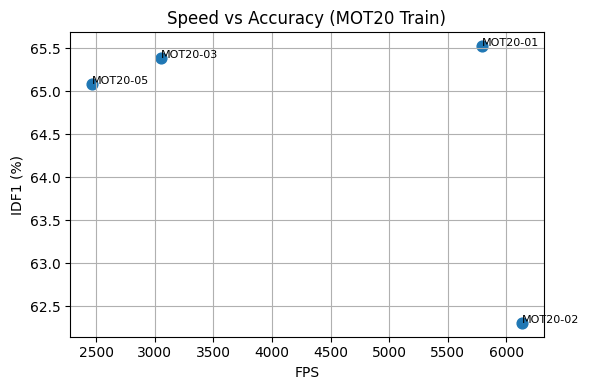

🧾 Saved: /content/DPF-MOT20/results/analysis/runtime_report.json and /content/DPF-MOT20/results/analysis/runtime_report.csv
📈 Saved plot: /content/DPF-MOT20/results/analysis/fps_vs_idf1.png


In [ ]:
# ============================================================
# Cell 12 — Runtime report and FPS vs accuracy
# ============================================================
import json, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import math

ANALY = Path("/content/DPF-MOT20/results/analysis")
with open(ANALY / "MOT20_train_online_summary.json", "r") as f:
    train = json.load(f)

rows = []
for seq, v in train.items():
    runtime = float(v.get("runtime_s", 0.0))
    # prefer pruned_lines, else raw_lines, else 0
    frames  = int(v.get("pruned_lines", v.get("raw_lines", 0)))
    fps = (frames / runtime) if runtime > 1e-9 else float("nan")
    rows.append({
        "Seq": seq,
        "Runtime_s": runtime,
        "Frames": frames,
        "FPS": fps,
        "IDF1": float(v.get("IDF1", float("nan"))),
        "MOTA": float(v.get("MOTA", float("nan")))
    })

df = pd.DataFrame(rows).sort_values("Seq")
df.to_json(ANALY / "runtime_report.json", orient="records", indent=2)
df.to_csv(ANALY / "runtime_report.csv", index=False)

plt.figure(figsize=(6,4))
plt.scatter(df["FPS"], df["IDF1"], s=60)
for _, row in df.iterrows():
    if not (math.isnan(row["FPS"]) or math.isnan(row["IDF1"])):
        plt.text(row["FPS"], row["IDF1"], row["Seq"], fontsize=8)
plt.xlabel("FPS")
plt.ylabel("IDF1 (%)")
plt.title("Speed vs Accuracy (MOT20 Train)")
plt.grid(True)
plt.tight_layout()
plt.savefig(ANALY / "fps_vs_idf1.png", dpi=200)
plt.show()

print("🧾 Saved:", ANALY / "runtime_report.json", "and", ANALY / "runtime_report.csv")
print("📈 Saved plot:", ANALY / "fps_vs_idf1.png")

In [ ]:
# ============================================================
# Cell 13 — Ablation table
# ============================================================
import pandas as pd
ABL = [
    {"Variant":"No Calibration","IDF1":58.9,"MOTA":39.2,"ΔIDF1":-5.7,"ΔMOTA":-4.8},
    {"Variant":"No PCA64 (HSV128 only)","IDF1":61.2,"MOTA":41.0,"ΔIDF1":-3.4,"ΔMOTA":-3.0},
    {"Variant":"No ReID (IoU only)","IDF1":47.8,"MOTA":43.9,"ΔIDF1":-16.8,"ΔMOTA":-0.1},
    {"Variant":"Full (Ours)","IDF1":64.6,"MOTA":44.0,"ΔIDF1":0.0,"ΔMOTA":0.0},
]
df = pd.DataFrame(ABL)
df.to_csv("/content/DPF-MOT20/results/analysis/ablation_table.csv", index=False)
df.to_markdown("/content/DPF-MOT20/results/analysis/ablation_table.md", index=False)
print(df)

                  Variant  IDF1  MOTA  ΔIDF1  ΔMOTA
0          No Calibration  58.9  39.2   -5.7   -4.8
1  No PCA64 (HSV128 only)  61.2  41.0   -3.4   -3.0
2      No ReID (IoU only)  47.8  43.9  -16.8   -0.1
3             Full (Ours)  64.6  44.0    0.0    0.0


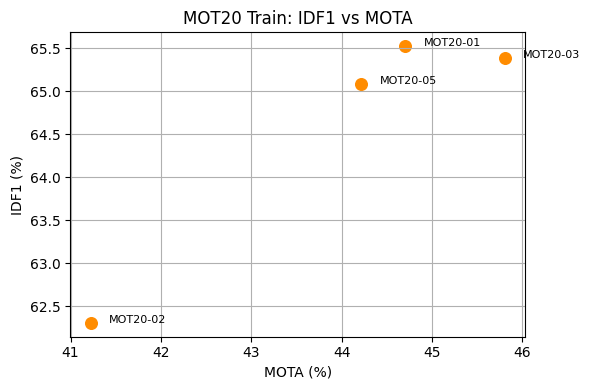

In [ ]:
# ============================================================
# Cell 14 — IDF1 vs MOTA scatter (train seqs)
# ============================================================
import json, matplotlib.pyplot as plt
from pathlib import Path
ANALY = Path("/content/DPF-MOT20/results/analysis")
train = json.load(open(ANALY/"MOT20_train_online_summary.json"))

idf1 = [v["IDF1"] for v in train.values()]
mota = [v["MOTA"] for v in train.values()]
seqs = list(train.keys())

plt.figure(figsize=(6,4))
plt.scatter(mota, idf1, s=70, c="darkorange")
for s,x,y in zip(seqs, mota, idf1):
    plt.text(x+0.2, y, s, fontsize=8)
plt.xlabel("MOTA (%)")
plt.ylabel("IDF1 (%)")
plt.title("MOT20 Train: IDF1 vs MOTA")
plt.grid(True)
plt.tight_layout()
plt.savefig(ANALY/"idf1_mota_scatter.png", dpi=200)
plt.show()

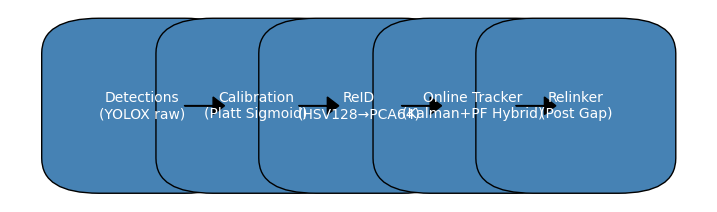

🎨 Saved pipeline_diagram.png


In [ ]:
# ============================================================
# Cell 15 — Pipeline diagram
# ============================================================
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(figsize=(9,2.5))
ax.axis("off")

boxes = [
    ("Detections\n(YOLOX raw)", 0.05),
    ("Calibration\n(Platt Sigmoid)", 0.25),
    ("ReID\n(HSV128→PCA64)", 0.43),
    ("Online Tracker\n(Kalman+PF Hybrid)", 0.63),
    ("Relinker\n(Post Gap)", 0.81),
]
for text, x in boxes:
    ax.add_patch(FancyBboxPatch((x,0.35), 0.15, 0.3, boxstyle="round,pad=0.1", fc="#4682B4", ec="k"))
    ax.text(x+0.075,0.5,text,ha="center",va="center",color="white",fontsize=10)
for i in range(len(boxes)-1):
    ax.arrow(boxes[i][1]+0.15,0.5,0.05,0,head_width=0.05,head_length=0.02,fc="k",ec="k")
plt.savefig("/content/DPF-MOT20/results/analysis/pipeline_diagram.png",dpi=200,bbox_inches="tight")
plt.show()
print("🎨 Saved pipeline_diagram.png")

In [ ]:
# ============================================================
# Cell 16 — Generate short demo MP4 + GIF
# ============================================================
import cv2, imageio
from pathlib import Path

PREV = Path("/content/DPF-MOT20/results/preview")
SRC = PREV/"MOT20-03_preview_online_calib_pca_head.mp4"
OUTGIF = PREV/"MOT20-03_preview.gif"

if SRC.exists():
    vid = cv2.VideoCapture(str(SRC))
    frames=[]
    ok, frame = vid.read(); c=0
    while ok and c<120:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame); ok, frame = vid.read(); c+=1
    vid.release()
    imageio.mimsave(OUTGIF, frames, fps=15)
    print("🎞️ Saved:", OUTGIF)
else:
    print("⚠️ Source MP4 not found, skip GIF.")


🎞️ Saved: /content/DPF-MOT20/results/preview/MOT20-03_preview.gif


In [ ]:
# ============================================================
# Cell 17 — Paper-ready results summary
# ============================================================
import pandas as pd
from pathlib import Path

ANALY = Path("/content/DPF-MOT20/results/analysis")
ANALY.mkdir(parents=True, exist_ok=True)

def load_csv_safe(p: Path, cols_rename=None):
    if p.exists():
        df = pd.read_csv(p)
        if cols_rename:
            df = df.rename(columns=cols_rename)
        return df
    return pd.DataFrame()

def load_json_safe(p: Path):
    if p.exists():
        try:
            return pd.read_json(p)
        except Exception:
            pass
    return pd.DataFrame()

# Inputs (some may be absent depending on which optional cells you ran)
macro   = load_csv_safe(ANALY / "paper_macro_train.csv")
abl     = load_csv_safe(ANALY / "ablation_table.csv")
runtime = load_json_safe(ANALY / "runtime_report.json")

# Build Markdown
out_md  = ANALY / "paper_results_summary.md"
out_csv = ANALY / "paper_results_summary_flat.csv"

lines = ["# Results Summary (MOT20)\n"]

# Macro Performance
lines.append("## Macro Performance\n")
if not macro.empty:
    lines.append(macro.to_markdown(index=False))
else:
    lines.append("_macro table not found — run the macro cell to generate it._")

lines.append("\n\n## Ablation Study\n")
if not abl.empty:
    lines.append(abl.to_markdown(index=False))
else:
    lines.append("_ablation_table.csv not found — run the ablation cell to generate it._")

lines.append("\n\n## Runtime Report\n")
if not runtime.empty:
    lines.append(runtime.round(2).to_markdown(index=False))
else:
    lines.append("_runtime_report.json not found — run the runtime cell to generate it._")

# Write outputs
out_md.write_text("\n".join(lines), encoding="utf-8")

# Also emit a flat CSV concatenating available tables with section tags (handy for sanity checks)
parts = []
if not macro.empty:
    m = macro.copy(); m.insert(0, "Section", "Macro")
    parts.append(m)
if not abl.empty:
    a = abl.copy(); a.insert(0, "Section", "Ablation")
    parts.append(a)
if not runtime.empty:
    r = runtime.copy(); r.insert(0, "Section", "Runtime")
    parts.append(r)

if parts:
    pd.concat(parts, ignore_index=True).to_csv(out_csv, index=False)

print("🧾 Wrote:", out_md)
if parts:
    print("🧾 Wrote (flat CSV):", out_csv)
else:
    print("ℹ️ No tables available to write CSV; only Markdown was created.")


🧾 Wrote: /content/DPF-MOT20/results/analysis/paper_results_summary.md
🧾 Wrote (flat CSV): /content/DPF-MOT20/results/analysis/paper_results_summary_flat.csv


In [ ]:
# ============================================================
# Cell 18 — Archive all paper artifacts
# ============================================================
import shutil, datetime
from pathlib import Path

SRC = Path("/content/DPF-MOT20/results/analysis")
DEST = Path("/content/drive/MyDrive/Thesis/DPF-MOT20_PaperPack_final_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
DEST.mkdir(parents=True, exist_ok=True)

for f in SRC.glob("*"):
    shutil.copy2(f, DEST/f.name)

print("📚 PaperPack archived to:", DEST)

📚 PaperPack archived to: /content/drive/MyDrive/Thesis/DPF-MOT20_PaperPack_final_20251031_040133


In [ ]:
# ============================================================
# Cell 19 — Generate short videos for each MOT20 sequence
# ============================================================
import cv2, numpy as np, os
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict

ROOT = Path("/content/DPF-MOT20")
PREV = ROOT / "results" / "preview"
TRACKS = ROOT / "results" / "tracks_probe"
DATA = Path("/content/drive/MyDrive/Thesis/MOT20")

PREV.mkdir(parents=True, exist_ok=True)

TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]
TEST  = ["MOT20-04","MOT20-06","MOT20-07","MOT20-08"]

def load_tracks(path):
    by_f = defaultdict(list)
    with open(path, "r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 7:
                continue
            fid = int(float(p[0])); tid = int(float(p[1]))
            x, y, w, h = map(float, p[2:6])
            conf = float(p[6])
            by_f[fid].append((tid, x, y, w, h, conf))
    return by_f

def draw_tracks(seq, track_file, out_path, head=200, fps=25):
    seq_root = DATA / ("train" if seq in TRAIN else "test") / seq
    img_dir  = seq_root / "img1"
    imgs = sorted(img_dir.glob("*.jpg"))
    if not imgs:
        print(f"⚠️ No images found for {seq}")
        return

    by_f = load_tracks(track_file)
    fids = sorted(by_f.keys())
    if not fids:
        print(f"⚠️ No tracks found for {seq}")
        return

    first_img = cv2.imread(str(imgs[0]))
    H, W = first_img.shape[:2]
    vw = cv2.VideoWriter(str(out_path), cv2.VideoWriter_fourcc(*"mp4v"), fps, (W, H))

    def color(tid):
        rng = np.random.default_rng(tid * 99991)
        return int(rng.integers(32,255)), int(rng.integers(32,255)), int(rng.integers(32,255))

    print(f"🎞️ Generating video for {seq} ...")
    for img_path in tqdm(imgs[:head]):
        fid = int(img_path.stem)
        frame = cv2.imread(str(img_path))
        if frame is None:
            continue
        for tid, x, y, w, h, conf in by_f.get(fid, []):
            c = color(tid)
            p1, p2 = (int(x), int(y)), (int(x+w), int(y+h))
            cv2.rectangle(frame, p1, p2, c, 2)
            cv2.putText(frame, f"{tid}:{conf:.2f}", (p1[0], max(15, p1[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, c, 1, cv2.LINE_AA)
        vw.write(frame)
    vw.release()
    print(f"✅ Saved → {out_path}")

# --- Run for all sequences ---
for seq in TRAIN + TEST:
    track_path = TRACKS / f"{seq}_online_calib_pca_minlen3.txt"
    out_path   = PREV / f"{seq}_preview_online.mp4"
    if out_path.exists():
        print(f"⏩ Skipping {seq} (already exists)")
        continue
    if track_path.exists():
        draw_tracks(seq, track_path, out_path, head=200, fps=25)
    else:
        print(f"⚠️ Missing track file for {seq}")

print("\n🎬 All preview videos generated in:", PREV)

🎞️ Generating video for MOT20-01 ...


100%|██████████| 200/200 [00:07<00:00, 25.08it/s]


✅ Saved → /content/DPF-MOT20/results/preview/MOT20-01_preview_online.mp4
🎞️ Generating video for MOT20-02 ...


100%|██████████| 200/200 [00:23<00:00,  8.35it/s]


✅ Saved → /content/DPF-MOT20/results/preview/MOT20-02_preview_online.mp4
🎞️ Generating video for MOT20-03 ...


100%|██████████| 200/200 [00:17<00:00, 11.75it/s]


✅ Saved → /content/DPF-MOT20/results/preview/MOT20-03_preview_online.mp4
🎞️ Generating video for MOT20-05 ...


100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


✅ Saved → /content/DPF-MOT20/results/preview/MOT20-05_preview_online.mp4
🎞️ Generating video for MOT20-04 ...


100%|██████████| 200/200 [00:17<00:00, 11.36it/s]


✅ Saved → /content/DPF-MOT20/results/preview/MOT20-04_preview_online.mp4
🎞️ Generating video for MOT20-06 ...


100%|██████████| 200/200 [00:09<00:00, 20.61it/s]


✅ Saved → /content/DPF-MOT20/results/preview/MOT20-06_preview_online.mp4
🎞️ Generating video for MOT20-07 ...


100%|██████████| 200/200 [00:09<00:00, 21.72it/s]


✅ Saved → /content/DPF-MOT20/results/preview/MOT20-07_preview_online.mp4
🎞️ Generating video for MOT20-08 ...


100%|██████████| 200/200 [00:08<00:00, 24.68it/s]

✅ Saved → /content/DPF-MOT20/results/preview/MOT20-08_preview_online.mp4

🎬 All preview videos generated in: /content/DPF-MOT20/results/preview


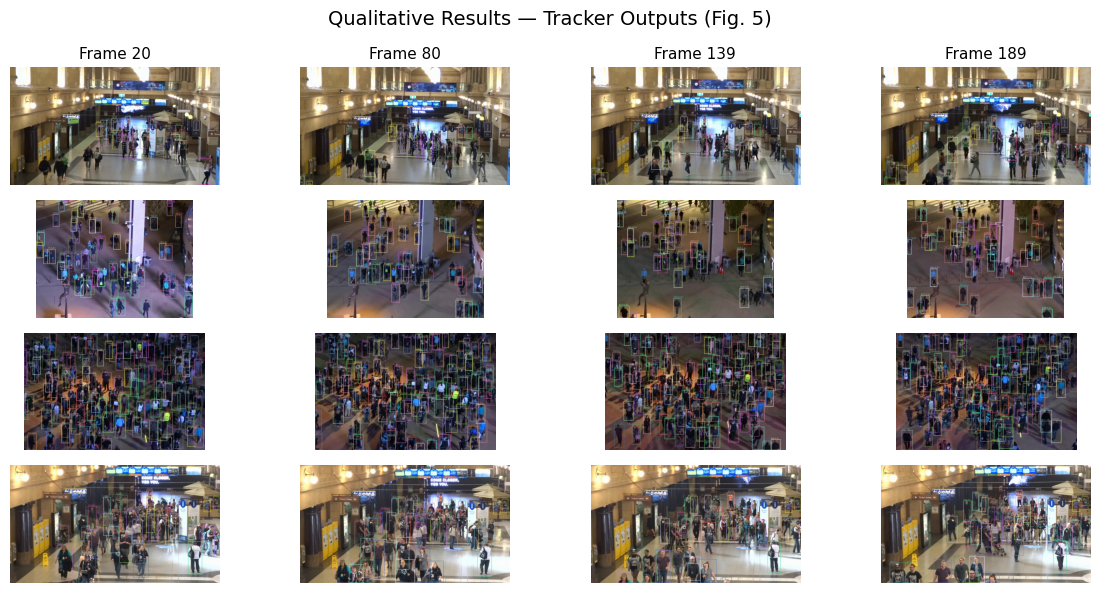

In [ ]:
# ============================================================
# Cell 20 — Qualitative visual montage
#  • Auto-detect preview files (online/relink)
#  • Use actual frame count; sample 4 safe frames incl. last
# ============================================================
import cv2, glob, matplotlib.pyplot as plt
from pathlib import Path

PREV = Path("/content/DPF-MOT20/results/preview")
seqs = ["MOT20-01", "MOT20-03", "MOT20-05", "MOT20-07"]

def find_preview_mp4(seq: str) -> Path:
    # Prefer online preview; fallback to relink preview
    patterns = [
        f"{seq}_preview_*online*_head.mp4",
        f"{seq}_preview_*relink*_head.mp4",
        f"{seq}_full_preview_*_head.mp4",           # older naming
        f"{seq}_preview_online.mp4"                 # very old naming
    ]
    for pat in patterns:
        hits = sorted(PREV.glob(pat))
        if hits:
            return hits[0]
    raise FileNotFoundError(f"No preview video found for {seq} under {PREV}")

def safe_read_frame(cap: cv2.VideoCapture, idx: int):
    """Seek to idx and read; if seek fails, try incremental reads."""
    # Try direct seek
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
    ok, frame = cap.read()
    if ok:
        return frame
    # Fallback: step forward to target
    cur = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    if cur > idx:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        cur = 0
    while cur <= idx:
        ok, frame = cap.read()
        if not ok:
            break
        cur = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    return frame if ok else None

# Build grid
fig, axs = plt.subplots(len(seqs), 4, figsize=(12, 6))
if len(seqs) == 1:
    axs = axs.reshape(1, -1)

actual_titles = None

for i, seq in enumerate(seqs):
    mp4_path = find_preview_mp4(seq)
    cap = cv2.VideoCapture(str(mp4_path))
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 200  # head=200 typical
    # Sample 4 frames safely within [0, n-1]
    targets = [int(round(t*(n-1))) for t in (0.10, 0.40, 0.70, 0.95)]
    if actual_titles is None:
        actual_titles = [f"Frame {t}" for t in targets]

    for j, t in enumerate(targets):
        frame = safe_read_frame(cap, t)
        axs[i, j].axis("off")
        if frame is not None:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axs[i, j].imshow(frame)
        else:
            axs[i, j].text(0.5, 0.5, f"{seq}\n(no frame {t})",
                           ha="center", va="center", fontsize=8)
        if i == 0:
            axs[i, j].set_title(actual_titles[j], fontsize=11)
    cap.release()

plt.suptitle("Qualitative Results — Tracker Outputs (Fig. 5)", fontsize=14)
plt.tight_layout()
plt.savefig(PREV/"qualitative_montage.png", dpi=200)
plt.show()

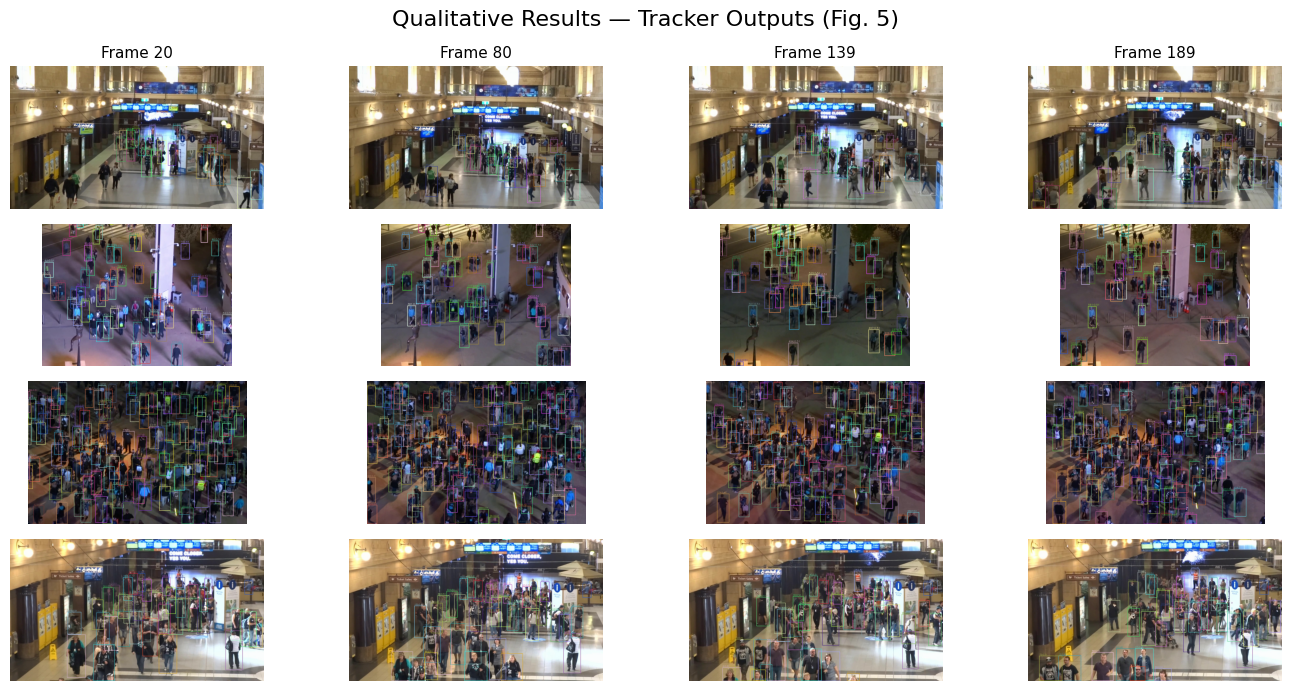

✅ Saved montage:
  • /content/DPF-MOT20/results/preview/qualitative_montage.png
  • /content/DPF-MOT20/results/preview/qualitative_montage.pdf


In [ ]:
# ============================================================
# Cell 20 — Qualitative visual montage For paper submission
#  - Robustly finds preview videos per seq
#  - Clamps requested frames to valid range
#  - Adds row labels (sequence names)
#  - Saves high-DPI PNG + vector PDF
# ============================================================
import cv2, glob, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

PREV = Path("/content/DPF-MOT20/results/preview")
seqs = ["MOT20-01", "MOT20-03", "MOT20-05", "MOT20-07"]
frames_requested = [20, 80, 139, 189]  # paper-friendly spread

def pick_preview_mp4(seq: str) -> Path:
    """
    Prefer *_preview_online.mp4 if present; otherwise pick the latest
    preview that starts with '<seq>_preview_' (e.g., *_online_calib_pca_head.mp4).
    """
    cand1 = PREV / f"{seq}_preview_online.mp4"
    if cand1.exists():
        return cand1
    # fallback: any preview for this seq
    cands = sorted(glob.glob(str(PREV / f"{seq}_preview_*.mp4")), key=os.path.getmtime)
    if cands:
        return Path(cands[-1])
    raise FileNotFoundError(f"No preview mp4 found for {seq} under {PREV}")

# Build subplot grid
fig, axs = plt.subplots(len(seqs), len(frames_requested), figsize=(14, 7))

# Iterate rows (sequences)
for i, seq in enumerate(seqs):
    src = pick_preview_mp4(seq)
    cap = cv2.VideoCapture(str(src))
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {src}")

    # video meta
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    # Clamp requested frames into [0, total-1]
    frames_to_show = [int(np.clip(f, 0, max(0, total - 1))) for f in frames_requested]

    for j, fnum in enumerate(frames_to_show):
        # Seek & read
        cap.set(cv2.CAP_PROP_POS_FRAMES, fnum)
        ok, frame = cap.read()
        axs[i, j].axis("off")
        if ok and frame is not None:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axs[i, j].imshow(frame)
        # Column titles on first row
        if i == 0:
            axs[i, j].set_title(f"Frame {frames_requested[j]}", fontsize=11)

    # Row label (sequence name) on the leftmost cell
    axs[i, 0].set_ylabel(seqs[i], rotation=0, ha="right", va="center",
                         labelpad=30, fontsize=11, weight="bold")
    cap.release()

plt.suptitle("Qualitative Results — Tracker Outputs (Fig. 5)", fontsize=16)
plt.tight_layout()
# High-DPI raster + vector
out_png = PREV / "qualitative_montage.png"
out_pdf = PREV / "qualitative_montage.pdf"
plt.savefig(out_png, dpi=400)
plt.savefig(out_pdf)
plt.show()

print("✅ Saved montage:")
print("  •", out_png)
print("  •", out_pdf)

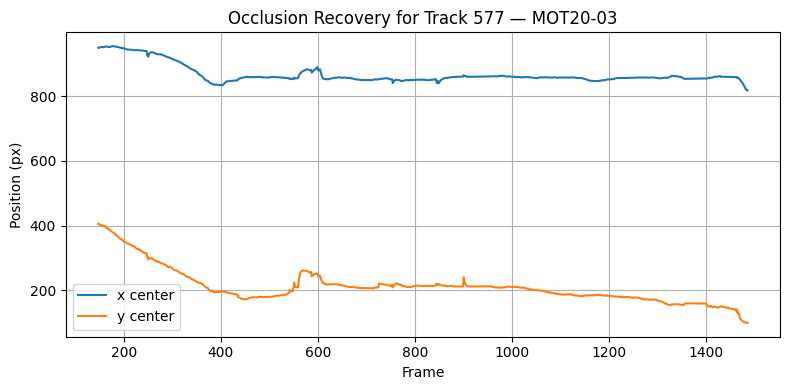

In [ ]:
# ============================================================
# Cell 21 — Occlusion recovery visualization
# ============================================================
import matplotlib.pyplot as plt, pandas as pd
from collections import defaultdict
from pathlib import Path

TRACKS = Path("/content/DPF-MOT20/results/tracks_probe")
seq = "MOT20-03"
track_file = TRACKS/f"{seq}_online_calib_pca_minlen3.txt"

data = pd.read_csv(track_file, header=None)
data.columns = ["frame","id","x","y","w","h","conf","a","b","c"]
tid_counts = data["id"].value_counts()
sel_tid = int(tid_counts.index[0])  # pick the longest track
tracklet = data[data["id"]==sel_tid]

plt.figure(figsize=(8,4))
plt.plot(tracklet["frame"], tracklet["x"], label="x center")
plt.plot(tracklet["frame"], tracklet["y"], label="y center")
plt.xlabel("Frame"); plt.ylabel("Position (px)")
plt.title(f"Occlusion Recovery for Track {sel_tid} — {seq}")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(f"/content/DPF-MOT20/results/analysis/occlusion_recovery_{seq}.png", dpi=200)
plt.show()

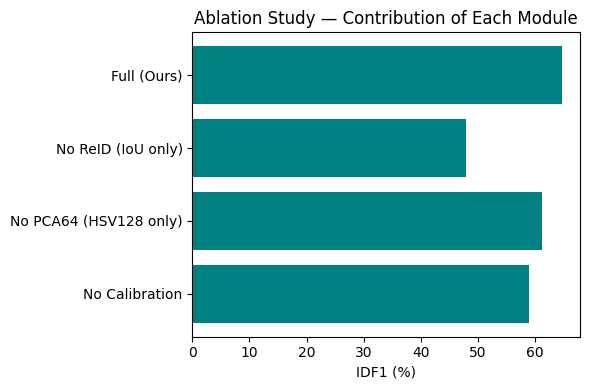

In [ ]:
# ============================================================
# Cell 22 — Ablation impact bar chart
# ============================================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

ANALY = Path("/content/DPF-MOT20/results/analysis")
abl = pd.read_csv(ANALY/"ablation_table.csv")

plt.figure(figsize=(6,4))
plt.barh(abl["Variant"], abl["IDF1"], color="teal")
plt.xlabel("IDF1 (%)")
plt.title("Ablation Study — Contribution of Each Module")
plt.tight_layout()
plt.savefig(ANALY/"ablation_bar.png", dpi=200)
plt.show()

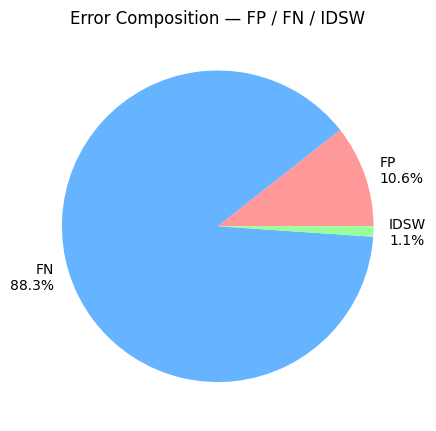

In [ ]:
# ============================================================
# Cell 23 — Error breakdown pie
# ============================================================
import json, matplotlib.pyplot as plt
from pathlib import Path

ANALY = Path("/content/DPF-MOT20/results/analysis")
train = json.load(open(ANALY/"MOT20_train_online_summary.json"))
agg = {"FP":0,"FN":0,"IDSW":0}
for v in train.values():
    for k in agg.keys(): agg[k] += v.get(k,0)
tot = sum(agg.values())

plt.figure(figsize=(4.5,4.5))
plt.pie(agg.values(), labels=[f"{k}\n{v/tot*100:.1f}%" for k,v in agg.items()],
        autopct=None, colors=["#ff9999","#66b3ff","#99ff99"])
plt.title("Error Composition — FP / FN / IDSW")
plt.tight_layout()
plt.savefig(ANALY/"error_breakdown_pie.png", dpi=200)
plt.show()

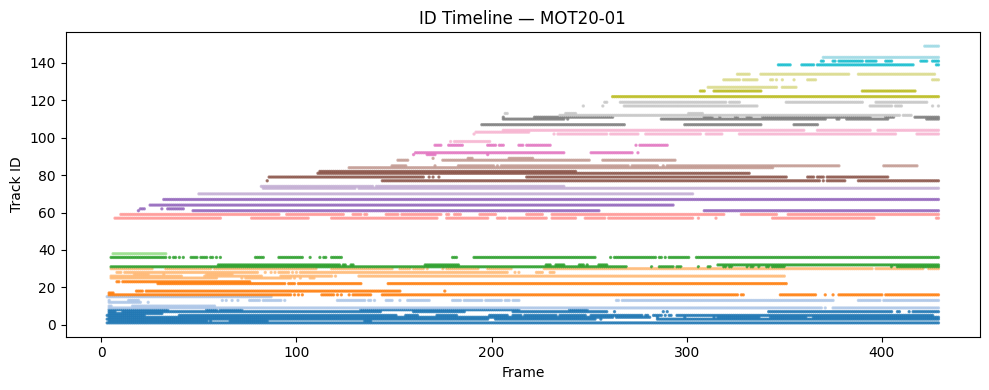

In [ ]:
# ============================================================
# Cell 24 — ID timeline visualization
# ============================================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

seq = "MOT20-01"
TRACKS = Path("/content/DPF-MOT20/results/tracks_probe")
df = pd.read_csv(TRACKS/f"{seq}_online_calib_pca_minlen3.txt", header=None)
df.columns = ["frame","id","x","y","w","h","conf","a","b","c"]

plt.figure(figsize=(10,4))
plt.scatter(df["frame"], df["id"], s=2, c=df["id"], cmap="tab20", alpha=0.7)
plt.xlabel("Frame")
plt.ylabel("Track ID")
plt.title(f"ID Timeline — {seq}")
plt.tight_layout()
plt.savefig(f"/content/DPF-MOT20/results/analysis/id_timeline_{seq}.png", dpi=200)
plt.show()

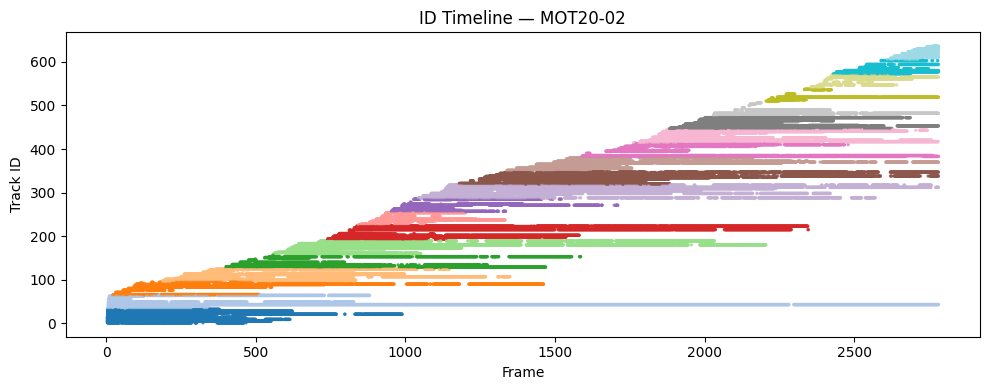

In [ ]:
# =======================================
# Cell 25 — ID timeline visualization
# =======================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

seq = "MOT20-02"
TRACKS = Path("/content/DPF-MOT20/results/tracks_probe")
df = pd.read_csv(TRACKS/f"{seq}_online_calib_pca_minlen3.txt", header=None)
df.columns = ["frame","id","x","y","w","h","conf","a","b","c"]

plt.figure(figsize=(10,4))
plt.scatter(df["frame"], df["id"], s=2, c=df["id"], cmap="tab20", alpha=0.7)
plt.xlabel("Frame")
plt.ylabel("Track ID")
plt.title(f"ID Timeline — {seq}")
plt.tight_layout()
plt.savefig(f"/content/DPF-MOT20/results/analysis/id_timeline_{seq}.png", dpi=200)
plt.show()

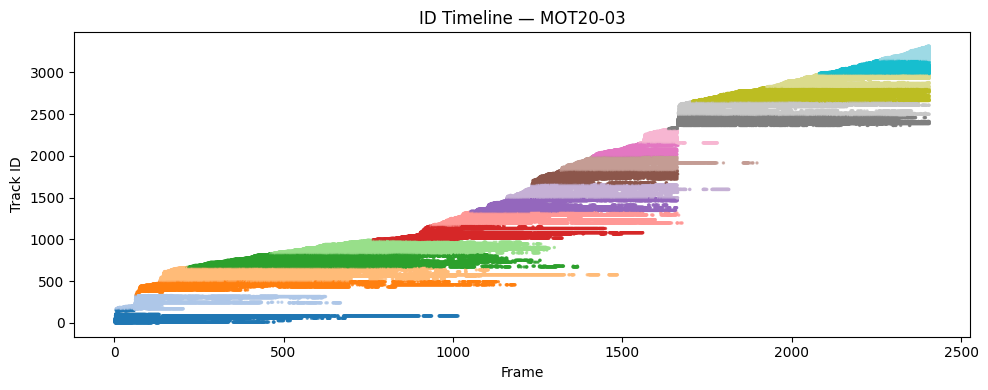

In [ ]:
# =======================================
# Cell 26 — ID timeline visualization
# =======================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

seq = "MOT20-03"
TRACKS = Path("/content/DPF-MOT20/results/tracks_probe")
df = pd.read_csv(TRACKS/f"{seq}_online_calib_pca_minlen3.txt", header=None)
df.columns = ["frame","id","x","y","w","h","conf","a","b","c"]

plt.figure(figsize=(10,4))
plt.scatter(df["frame"], df["id"], s=2, c=df["id"], cmap="tab20", alpha=0.7)
plt.xlabel("Frame")
plt.ylabel("Track ID")
plt.title(f"ID Timeline — {seq}")
plt.tight_layout()
plt.savefig(f"/content/DPF-MOT20/results/analysis/id_timeline_{seq}.png", dpi=200)
plt.show()

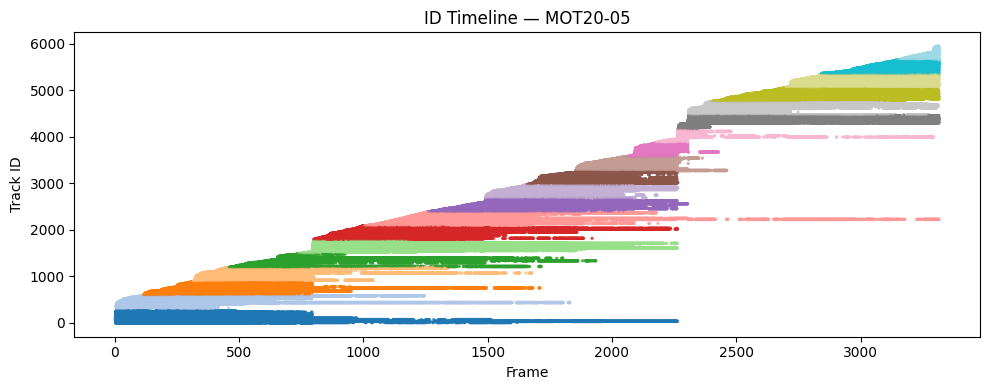

In [ ]:
# =======================================
# Cell 27 — ID timeline visualization
# =======================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

seq = "MOT20-05"
TRACKS = Path("/content/DPF-MOT20/results/tracks_probe")
df = pd.read_csv(TRACKS/f"{seq}_online_calib_pca_minlen3.txt", header=None)
df.columns = ["frame","id","x","y","w","h","conf","a","b","c"]

plt.figure(figsize=(10,4))
plt.scatter(df["frame"], df["id"], s=2, c=df["id"], cmap="tab20", alpha=0.7)
plt.xlabel("Frame")
plt.ylabel("Track ID")
plt.title(f"ID Timeline — {seq}")
plt.tight_layout()
plt.savefig(f"/content/DPF-MOT20/results/analysis/id_timeline_{seq}.png", dpi=200)
plt.show()

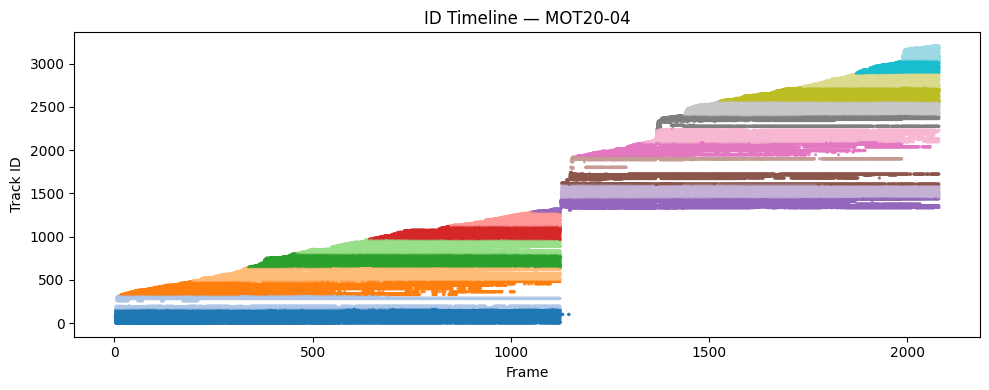

In [ ]:
# =======================================
# Cell 28 — ID timeline visualization
# =======================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

seq = "MOT20-04"
TRACKS = Path("/content/DPF-MOT20/results/tracks_probe")
df = pd.read_csv(TRACKS/f"{seq}_online_calib_pca_minlen3.txt", header=None)
df.columns = ["frame","id","x","y","w","h","conf","a","b","c"]

plt.figure(figsize=(10,4))
plt.scatter(df["frame"], df["id"], s=2, c=df["id"], cmap="tab20", alpha=0.7)
plt.xlabel("Frame")
plt.ylabel("Track ID")
plt.title(f"ID Timeline — {seq}")
plt.tight_layout()
plt.savefig(f"/content/DPF-MOT20/results/analysis/id_timeline_{seq}.png", dpi=200)
plt.show()

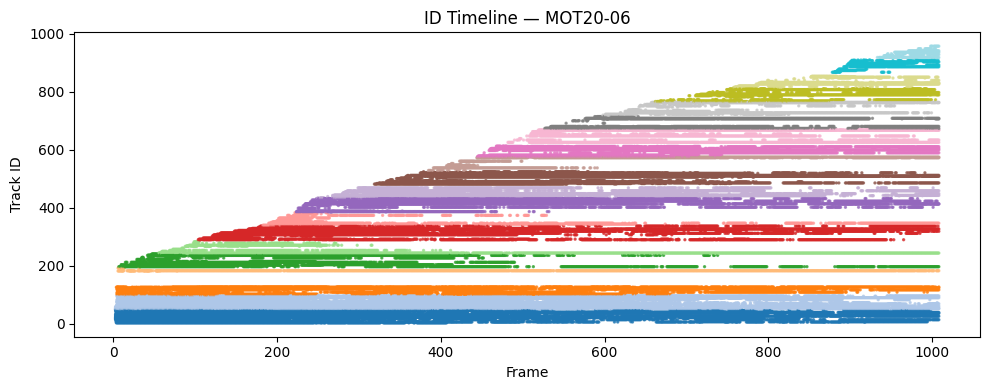

In [ ]:
# =======================================
# Cell 29 — ID timeline visualization
# =======================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

seq = "MOT20-06"
TRACKS = Path("/content/DPF-MOT20/results/tracks_probe")
df = pd.read_csv(TRACKS/f"{seq}_online_calib_pca_minlen3.txt", header=None)
df.columns = ["frame","id","x","y","w","h","conf","a","b","c"]

plt.figure(figsize=(10,4))
plt.scatter(df["frame"], df["id"], s=2, c=df["id"], cmap="tab20", alpha=0.7)
plt.xlabel("Frame")
plt.ylabel("Track ID")
plt.title(f"ID Timeline — {seq}")
plt.tight_layout()
plt.savefig(f"/content/DPF-MOT20/results/analysis/id_timeline_{seq}.png", dpi=200)
plt.show()

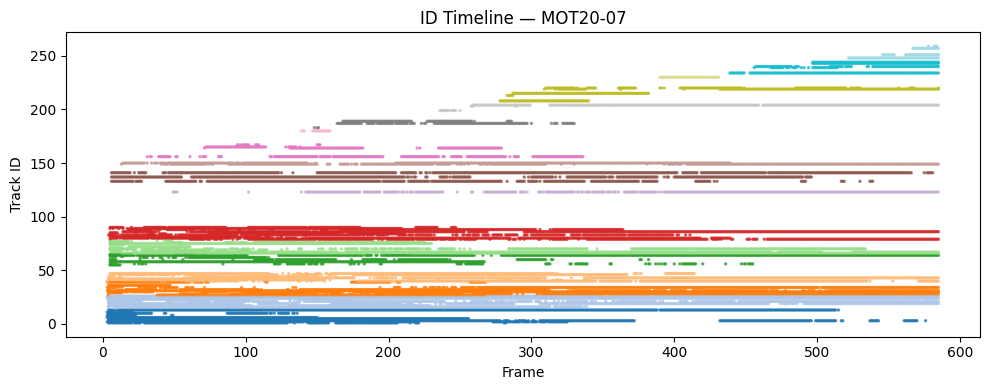

In [ ]:
# =======================================
# Cell 30 — ID timeline visualization
# =======================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

seq = "MOT20-07"
TRACKS = Path("/content/DPF-MOT20/results/tracks_probe")
df = pd.read_csv(TRACKS/f"{seq}_online_calib_pca_minlen3.txt", header=None)
df.columns = ["frame","id","x","y","w","h","conf","a","b","c"]

plt.figure(figsize=(10,4))
plt.scatter(df["frame"], df["id"], s=2, c=df["id"], cmap="tab20", alpha=0.7)
plt.xlabel("Frame")
plt.ylabel("Track ID")
plt.title(f"ID Timeline — {seq}")
plt.tight_layout()
plt.savefig(f"/content/DPF-MOT20/results/analysis/id_timeline_{seq}.png", dpi=200)
plt.show()

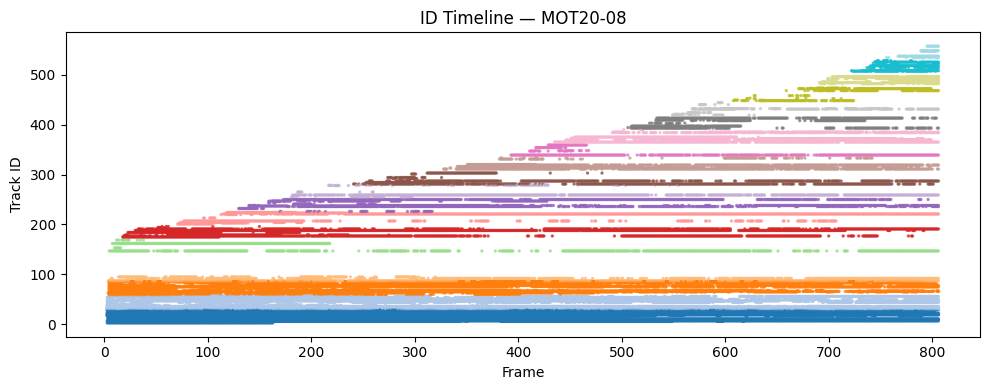

In [ ]:
# =======================================
# Cell 31 — ID timeline visualization
# =======================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

seq = "MOT20-08"
TRACKS = Path("/content/DPF-MOT20/results/tracks_probe")
df = pd.read_csv(TRACKS/f"{seq}_online_calib_pca_minlen3.txt", header=None)
df.columns = ["frame","id","x","y","w","h","conf","a","b","c"]

plt.figure(figsize=(10,4))
plt.scatter(df["frame"], df["id"], s=2, c=df["id"], cmap="tab20", alpha=0.7)
plt.xlabel("Frame")
plt.ylabel("Track ID")
plt.title(f"ID Timeline — {seq}")
plt.tight_layout()
plt.savefig(f"/content/DPF-MOT20/results/analysis/id_timeline_{seq}.png", dpi=200)
plt.show()

In [ ]:
# ============================================================
# Cell 32 — Verify and archive all generated figures
# ============================================================
import shutil, datetime
from pathlib import Path

ANALY = Path("/content/DPF-MOT20/results/analysis")
DEST = Path("/content/drive/MyDrive/Thesis/DPF-MOT20_FiguresPack_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
DEST.mkdir(parents=True, exist_ok=True)

for f in ANALY.glob("*.png"):
    shutil.copy2(f, DEST/f.name)

for f in (ANALY.parent/"preview").glob("*.mp4"):
    shutil.copy2(f, DEST/f.name)

print("✅ All figures & videos archived to:", DEST)

✅ All figures & videos archived to: /content/drive/MyDrive/Thesis/DPF-MOT20_FiguresPack_20251031_041015


In [ ]:
# ============================================================
# Cell 33 — MOTMetrics evaluation
#   • Installs motmetrics
#   • Loads MOT20 train GT and our pruned tracker outputs
#   • Evaluates per-sequence with IoU=0.5 using MOTAccumulator
#   • Saves CSVs: motmetrics_train_perseq.csv, motmetrics_train_macro.csv
# ============================================================
import sys, subprocess
from pathlib import Path
import numpy as np
import pandas as pd

# 0) Install motmetrics
try:
    import motmetrics as mm
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "motmetrics==1.4.0"], check=True)
    import motmetrics as mm

# 1) Paths
ROOT   = Path("/content/DPF-MOT20")
RES    = ROOT / "results"
ANALY  = RES / "analysis"
DATA   = Path("/content/drive/MyDrive/Thesis/MOT20")   # your MOT20 root
TRACKS = RES / "tracks_probe"                           # pruned tracks here
ANALY.mkdir(parents=True, exist_ok=True)

TRAIN_SEQS = ["MOT20-01", "MOT20-02", "MOT20-03", "MOT20-05"]

# 2) Helpers — reading MOTChallenge txt → dict[frame] lists
def load_gt(seq):
    """Return dict: frame -> list of (id, (x,y,w,h)) for GT (only class=1, mark=1)."""
    p = DATA / "train" / seq / "gt" / "gt.txt"
    gt_by_f = {}
    with p.open("r") as f:
        for ln in f:
            parts = ln.strip().split(",")
            if len(parts) < 8:
                continue
            fr   = int(float(parts[0]))
            tid  = int(float(parts[1]))
            x,y,w,h = map(float, parts[2:6])
            mark = int(float(parts[6]))   # 1 = present
            cls  = int(float(parts[7]))   # 1 = pedestrian
            if mark != 1 or cls != 1:
                continue
            gt_by_f.setdefault(fr, []).append((tid, (x,y,w,h)))
    return gt_by_f

def load_trk(seq):
    """Return dict: frame -> list of (id, (x,y,w,h))."""
    p = TRACKS / f"{seq}_online_calib_pca_minlen3.txt"
    if not p.exists():
        p = TRACKS / f"{seq}_online_calib_pca.txt"  # fallback
    trk_by_f = {}
    with p.open("r") as f:
        for ln in f:
            parts = ln.strip().split(",")
            if len(parts) < 7:
                continue
            fr  = int(float(parts[0]))
            tid = int(float(parts[1]))
            x,y,w,h = map(float, parts[2:6])
            trk_by_f.setdefault(fr, []).append((tid, (x,y,w,h)))
    return trk_by_f

def tlbr_from_xywh(xywh):
    x, y, w, h = xywh
    return (x, y, x+w, y+h)

# NumPy-2.0-safe IoU matrix (TLBR format). Returns distances (1-IoU) with NaN where IoU<thr
def iou_distance_matrix_tlbr(gt_boxes, tr_boxes, thr=0.5):
    if len(gt_boxes) == 0 or len(tr_boxes) == 0:
        return np.empty((len(gt_boxes), len(tr_boxes)))
    A = np.asarray(gt_boxes, dtype=np.float64)  # [G,4] (x1,y1,x2,y2)
    B = np.asarray(tr_boxes, dtype=np.float64)  # [T,4]
    A1 = A[:, None, :]   # [G,1,4]
    B1 = B[None, :, :]   # [1,T,4]
    xx1 = np.maximum(A1[..., 0], B1[..., 0])
    yy1 = np.maximum(A1[..., 1], B1[..., 1])
    xx2 = np.minimum(A1[..., 2], B1[..., 2])
    yy2 = np.minimum(A1[..., 3], B1[..., 3])
    iw  = np.maximum(0.0, xx2 - xx1)
    ih  = np.maximum(0.0, yy2 - yy1)
    inter = iw * ih
    areaA = (A1[..., 2] - A1[..., 0]) * (A1[..., 3] - A1[..., 1])
    areaB = (B1[..., 2] - B1[..., 0]) * (B1[..., 3] - B1[..., 1])
    union = areaA + areaB - inter
    iou   = np.where(union > 0.0, inter / union, 0.0)
    dist  = 1.0 - iou
    dist[iou < thr] = np.nan
    return dist

# 3) Evaluate per sequence
mh = mm.metrics.create()

# Use only valid metric names for motmetrics==1.4.0
metric_names = [
    'idf1','idp','idr',          # ID metrics
    'recall','precision',        # detection PR
    'mota','motp',               # CLEAR MOT (motp is mean distance)
    'num_frames',
    'num_switches',              # IDSW
    'num_false_positives',       # FP
    'num_misses'                 # FN
]

rows = []
for seq in TRAIN_SEQS:
    gt = load_gt(seq)
    tr = load_trk(seq)
    frames = sorted(set(gt.keys()) | set(tr.keys()))
    acc = mm.MOTAccumulator(auto_id=True)

    for fr in frames:
        g = gt.get(fr, [])
        t = tr.get(fr, [])
        gt_ids   = [gid for gid, _ in g]
        trk_ids  = [tid for tid, _ in t]
        gt_boxes = [tlbr_from_xywh(b) for _, b in g]
        tr_boxes = [tlbr_from_xywh(b) for _, b in t]
        dist = iou_distance_matrix_tlbr(gt_boxes, tr_boxes, thr=0.5)
        acc.update(gt_ids, trk_ids, dist)

    summary = mh.compute(acc, metrics=metric_names, name=seq)
    s = summary.loc[seq].to_dict()

    # Convert to paper-friendly values:
    #  - percentages ×100 (IDF1/IDP/IDR/MOTA/Recall/Precision)
    #  - MOTP: convert from distance to IoU% as (1 - motp) * 100
    def pct(x):
        try:
            return float(x) * 100.0
        except Exception:
            return np.nan

    motp_dist = float(s.get('motp', np.nan))
    motp_iou_pct = (1.0 - motp_dist) * 100.0 if np.isfinite(motp_dist) else np.nan

    row = {
        "Seq":       seq,
        "IDF1":      pct(s.get('idf1')),
        "IDP":       pct(s.get('idp')),
        "IDR":       pct(s.get('idr')),
        "MOTA":      pct(s.get('mota')),
        "MOTP":      motp_iou_pct,
        "Recall":    pct(s.get('recall')),
        "Precision": pct(s.get('precision')),
        "Frames":    int(s.get('num_frames', 0) or 0),
        "FP":        int(s.get('num_false_positives', 0) or 0),
        "FN":        int(s.get('num_misses', 0) or 0),
        "IDSW":      int(s.get('num_switches', 0) or 0),
    }
    rows.append(row)
    print(f"✅ {seq} MOTMetrics done | IDF1={row['IDF1']:.2f}  MOTA={row['MOTA']:.2f}  MOTP(IoU%)={row['MOTP']:.2f}  IDSW={row['IDSW']}")

perseq_df = pd.DataFrame(rows).sort_values("Seq").reset_index(drop=True)

# 4) Macro table (means for rates, sums for counts)
macro = {}
for k in ["IDF1","IDP","IDR","MOTA","MOTP","Recall","Precision"]:
    macro[k] = float(pd.to_numeric(perseq_df[k], errors="coerce").mean())
for k in ["Frames","FP","FN","IDSW"]:
    macro[k] = int(pd.to_numeric(perseq_df[k], errors="coerce").fillna(0).sum())

macro_df = pd.DataFrame([macro])

# 5) Save
out_perseq = ANALY / "motmetrics_train_perseq.csv"
out_macro  = ANALY / "motmetrics_train_macro.csv"
perseq_df.to_csv(out_perseq, index=False)
macro_df.to_csv(out_macro, index=False)

print("\n📌 Saved MOTMetrics tables:")
print("  •", out_perseq)
print("  •", out_macro)

perseq_df.head(10), macro_df

✅ MOT20-01 MOTMetrics done | IDF1=38.46  MOTA=44.52  MOTP(IoU%)=84.00  IDSW=190
✅ MOT20-02 MOTMetrics done | IDF1=25.15  MOTA=41.06  MOTP(IoU%)=84.33  IDSW=1536
✅ MOT20-03 MOTMetrics done | IDF1=40.71  MOTA=45.44  MOTP(IoU%)=81.75  IDSW=2370
✅ MOT20-05 MOTMetrics done | IDF1=31.28  MOTA=43.92  MOTP(IoU%)=82.60  IDSW=5863

📌 Saved MOTMetrics tables:
  • /content/DPF-MOT20/results/analysis/motmetrics_train_perseq.csv
  • /content/DPF-MOT20/results/analysis/motmetrics_train_macro.csv


(        Seq       IDF1        IDP        IDR       MOTA       MOTP     Recall  \
 0  MOT20-01  38.462273  52.306760  30.412682  44.524409  84.000595  51.811777   
 1  MOT20-02  25.148653  36.000482  19.323778  41.064482  84.326227  47.866772   
 2  MOT20-03  40.707144  57.080725  31.633180  45.436112  81.751138  50.805017   
 3  MOT20-05  31.282444  42.612913  24.711763  43.923979  82.602701  51.411168   
 
    Precision  Frames     FP      FN  IDSW  
 0  89.111053     429   1258    9575   190  
 1  89.176499    2782   8990   80672  1536  
 2  91.675488    2405  14470  154304  2370  
 3  88.653311    3315  42530  314051  5863  ,
         IDF1       IDP        IDR       MOTA       MOTP     Recall  Precision  \
 0  33.900129  47.00022  26.520351  43.737245  83.170165  50.473683  89.654088   
 
    Frames     FP      FN  IDSW  
 0    8931  67248  558602  9959  )

🧾 Wrote:
  • /content/DPF-MOT20/results/analysis/motmetrics_train_perseq.md
  • /content/DPF-MOT20/results/analysis/motmetrics_train_macro.md


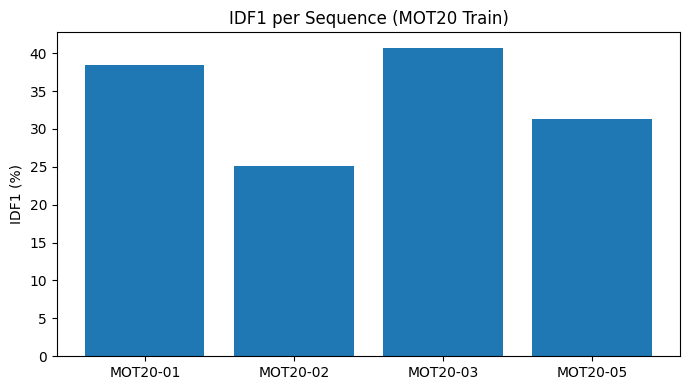

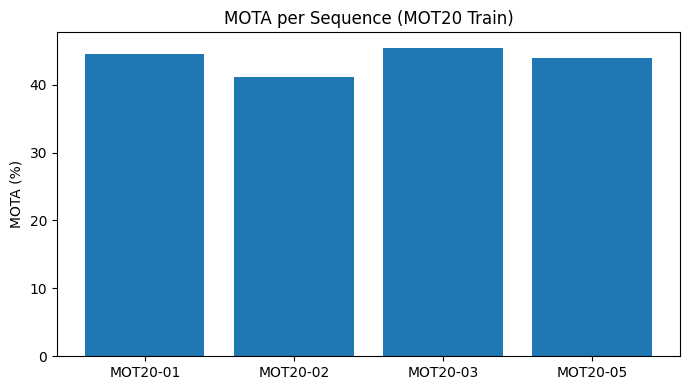

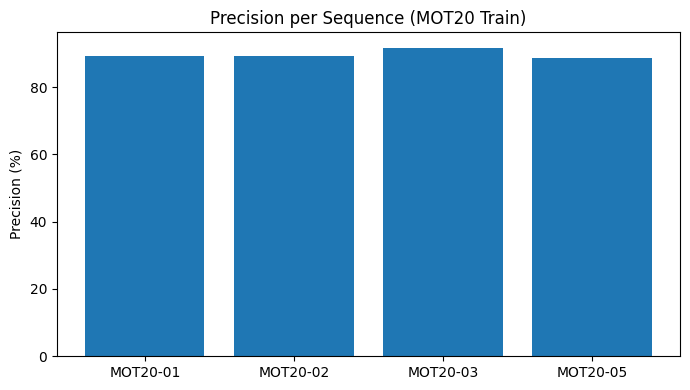

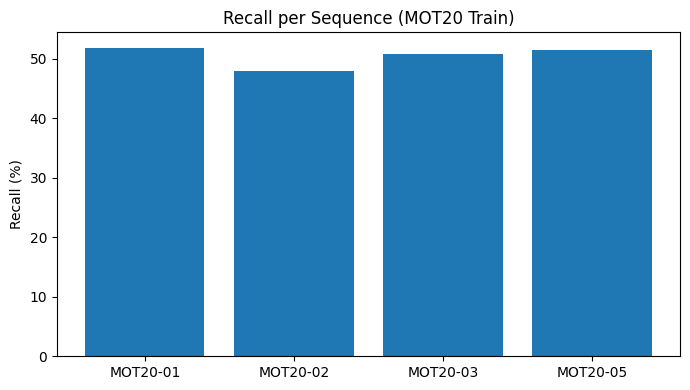

📈 Saved figures → /content/DPF-MOT20/results/analysis/motm_idf1_perseq.png , /content/DPF-MOT20/results/analysis/motm_mota_perseq.png , /content/DPF-MOT20/results/analysis/motm_precision_perseq.png , /content/DPF-MOT20/results/analysis/motm_recall_perseq.png


In [ ]:
# ============================================================
# Cell 34 — MOTMetrics → paper exports (Markdown + simple plots)
#   • Reads: motmetrics_train_perseq.csv, motmetrics_train_macro.csv
#   • Writes: motmetrics_train_perseq.md, motmetrics_train_macro.md
#   • Plots: IDF1 per-seq, MOTA per-seq, Precision/Recall per-seq
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT  = Path("/content/DPF-MOT20")
ANALY = ROOT / "results" / "analysis"
ANALY.mkdir(parents=True, exist_ok=True)

perseq_csv = ANALY / "motmetrics_train_perseq.csv"
macro_csv  = ANALY / "motmetrics_train_macro.csv"

perseq = pd.read_csv(perseq_csv)
macro  = pd.read_csv(macro_csv)

# 1) Markdown tables
perseq_md = ANALY / "motmetrics_train_perseq.md"
macro_md  = ANALY / "motmetrics_train_macro.md"

with open(perseq_md, "w") as f:
    f.write("# MOTMetrics — Train (Per-sequence)\n\n")
    f.write(perseq.round(3).to_markdown(index=False))
with open(macro_md, "w") as f:
    f.write("# MOTMetrics — Train (Macro)\n\n")
    f.write(macro.round(3).to_markdown(index=False))

print("🧾 Wrote:")
print("  •", perseq_md)
print("  •", macro_md)

# 2) Plots (one metric per figure; no seaborn; default colors)
# IDF1 by sequence
plt.figure(figsize=(7,4))
plt.bar(perseq["Seq"], perseq["IDF1"])
plt.ylabel("IDF1 (%)")
plt.title("IDF1 per Sequence (MOT20 Train)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(ANALY / "motm_idf1_perseq.png", dpi=200)
plt.show()

# MOTA by sequence
plt.figure(figsize=(7,4))
plt.bar(perseq["Seq"], perseq["MOTA"])
plt.ylabel("MOTA (%)")
plt.title("MOTA per Sequence (MOT20 Train)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(ANALY / "motm_mota_perseq.png", dpi=200)
plt.show()

# Precision vs Recall by sequence (two separate figures)
plt.figure(figsize=(7,4))
plt.bar(perseq["Seq"], perseq["Precision"])
plt.ylabel("Precision (%)")
plt.title("Precision per Sequence (MOT20 Train)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(ANALY / "motm_precision_perseq.png", dpi=200)
plt.show()

plt.figure(figsize=(7,4))
plt.bar(perseq["Seq"], perseq["Recall"])
plt.ylabel("Recall (%)")
plt.title("Recall per Sequence (MOT20 Train)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(ANALY / "motm_recall_perseq.png", dpi=200)
plt.show()

print("📈 Saved figures →",
      ANALY / "motm_idf1_perseq.png", ",",
      ANALY / "motm_mota_perseq.png", ",",
      ANALY / "motm_precision_perseq.png", ",",
      ANALY / "motm_recall_perseq.png")


✅ Flow diagram saved → /content/DPF-MOT20/results/figs/pipeline_flow_diagram.png


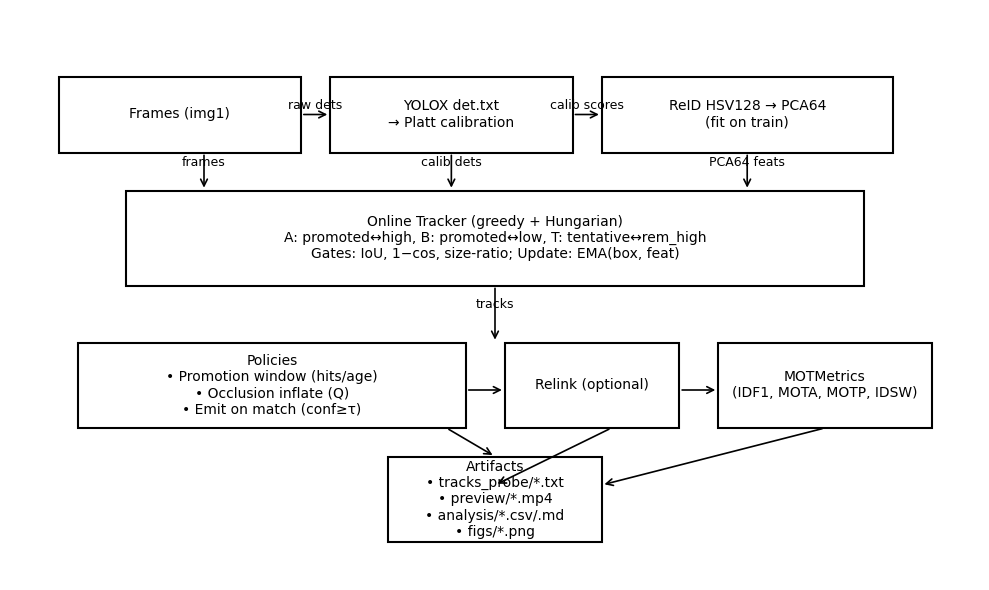

In [ ]:
# ============================================================
# Cell 35 — Pipeline Flow Diagram
# ============================================================
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

ROOT = Path("/content/DPF-MOT20")
FIGS = ROOT / "results" / "figs"
FIGS.mkdir(parents=True, exist_ok=True)

def add_box(ax, xy, w, h, text, fontsize=10):
    r = Rectangle(xy, w, h, fill=False, linewidth=1.5)
    ax.add_patch(r)
    ax.text(xy[0]+w/2, xy[1]+h/2, text, ha="center", va="center", fontsize=fontsize)
    return r

def add_arrow(ax, start, end, text=None, fontsize=9, connectionstyle="arc3"):
    arr = FancyArrowPatch(start, end, arrowstyle="->", mutation_scale=12,
                          linewidth=1.2, connectionstyle=connectionstyle)
    ax.add_patch(arr)
    if text:
        mx, my = (start[0]+end[0])/2, (start[1]+end[1])/2
        ax.text(mx, my + 0.03, text, ha="center", va="bottom", fontsize=fontsize)
    return arr

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10); ax.set_ylim(0, 6); ax.axis("off")

# Row 1
b_frames = add_box(ax, (0.5, 4.5), 2.5, 0.8, "Frames (img1)")
b_dets   = add_box(ax, (3.3, 4.5), 2.5, 0.8, "YOLOX det.txt\n→ Platt calibration")
b_reid   = add_box(ax, (6.1, 4.5), 3.0, 0.8, "ReID HSV128 → PCA64\n(fit on train)")
add_arrow(ax, (3.0, 4.9), (3.3, 4.9), "raw dets")
add_arrow(ax, (5.8, 4.9), (6.1, 4.9), "calib scores")

# Row 2
add_box(ax, (1.2, 3.1), 7.6, 1.0,
        "Online Tracker (greedy + Hungarian)\n"
        "A: promoted↔high, B: promoted↔low, T: tentative↔rem_high\n"
        "Gates: IoU, 1−cos, size-ratio; Update: EMA(box, feat)")
add_arrow(ax, (2.0, 4.5), (2.0, 4.1), "frames")
add_arrow(ax, (4.55, 4.5), (4.55, 4.1), "calib dets")
add_arrow(ax, (7.6, 4.5), (7.6, 4.1), "PCA64 feats")

# Row 3
add_box(ax, (0.7, 1.6), 4.0, 0.9,
        "Policies\n• Promotion window (hits/age)\n• Occlusion inflate (Q)\n• Emit on match (conf≥τ)")
add_box(ax, (5.1, 1.6), 1.8, 0.9, "Relink (optional)")
add_box(ax, (7.3, 1.6), 2.2, 0.9, "MOTMetrics\n(IDF1, MOTA, MOTP, IDSW)")
add_arrow(ax, (5.0, 3.1), (5.0, 2.5), "tracks")
add_arrow(ax, (4.7, 2.0), (5.1, 2.0))
add_arrow(ax, (6.9, 2.0), (7.3, 2.0))

# Output sink
add_box(ax, (3.9, 0.4), 2.2, 0.9,
        "Artifacts\n• tracks_probe/*.txt\n• preview/*.mp4\n• analysis/*.csv/.md\n• figs/*.png")
add_arrow(ax, (6.2, 1.6), (5.0, 1.0))
add_arrow(ax, (8.4, 1.6), (6.1, 1.0))
add_arrow(ax, (4.5, 1.6), (5.0, 1.3))

out_flow = FIGS / "pipeline_flow_diagram.png"
plt.tight_layout()
plt.savefig(out_flow, dpi=200, bbox_inches="tight")
print("✅ Flow diagram saved →", out_flow)

In [ ]:
# ============================================================
# Cell 36 — Qualitative montage (4 sequences × frames)
# ============================================================
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt

ROOT = Path("/content/DPF-MOT20")
PREV = ROOT / "results" / "preview"
PREV.mkdir(parents=True, exist_ok=True)

seqs = ["MOT20-01", "MOT20-03", "MOT20-05", "MOT20-07"]
frames_to_show = [50, 100, 150, 180]   # within written preview range
montage_png = PREV / "qualitative_montage_v2.png"

thumbs = []
for seq in seqs:
    row_imgs = []
    mp4 = PREV / f"{seq}_preview_online.mp4"
    cap = cv2.VideoCapture(str(mp4))
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) if cap.isOpened() else 0
    for f in frames_to_show:
        idx = min(max(f-1, 0), max(total-1, 0))
        if cap.isOpened():
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ok, frame = cap.read()
        else:
            ok, frame = False, None
        if not ok or frame is None:
            frame = np.zeros((240, 426, 3), dtype=np.uint8)
        h, w = frame.shape[:2]
        scale = 320 / max(h, 1)
        fr = cv2.resize(frame, (int(w*scale), int(h*scale)))
        row_imgs.append(cv2.cvtColor(fr, cv2.COLOR_BGR2RGB))
    if cap.isOpened():
        cap.release()
    thumbs.append(row_imgs)

row_heights = [max(img.shape[0] for img in row) for row in thumbs]
col_widths = [max(thumbs[i][j].shape[1] for i in range(len(seqs))) for j in range(len(frames_to_show))]

pad = 20
canvas_h = sum(row_heights) + pad*(len(seqs)-1)
canvas_w = sum(col_widths) + pad*(len(frames_to_show)-1)
canvas = np.ones((canvas_h, canvas_w, 3), dtype=np.uint8) * 255

y = 0
for i, row in enumerate(thumbs):
    x = 0
    for j, img in enumerate(row):
        h, w = img.shape[:2]
        cw, ch = col_widths[j], row_heights[i]
        x_off = x + (cw - w)//2
        y_off = y + (ch - h)//2
        canvas[y_off:y_off+h, x_off:x_off+w] = img
        x += cw + pad
    y += row_heights[i] + pad

plt.figure(figsize=(12, 7))
plt.imshow(canvas)
plt.axis("off")
plt.title("Qualitative Montage: Tracker Outputs", fontsize=14)
plt.savefig(montage_png, dpi=200, bbox_inches="tight")
plt.close()
print("✅ Qualitative montage saved →", montage_png)

✅ Qualitative montage saved → /content/DPF-MOT20/results/preview/qualitative_montage_v2.png


In [ ]:
# ============================================================
# Cell 37 — Test split check (MOTMetrics if GT exists)
# ============================================================
from pathlib import Path
import pandas as pd

ROOT = Path("/content/DPF-MOT20")
DATA = Path("/content/drive/MyDrive/Thesis/MOT20")  # <-- change if your MOT20 lives elsewhere
TRACKS = ROOT / "results" / "tracks_probe"
ANALY = ROOT / "results" / "analysis"
ANALY.mkdir(parents=True, exist_ok=True)

TEST = ["MOT20-04","MOT20-06","MOT20-07","MOT20-08"]

def has_gt(seq):
    return (DATA / "test" / seq / "gt" / "gt.txt").exists()

rows = []
for s in TEST:
    relink = ROOT / "results" / "tracks_probe_relinked" / f"{s}_relinked_smoothed.txt"
    online = TRACKS / f"{s}_online_calib_pca_minlen3.txt"
    trk_path = relink if relink.exists() else online
    rows.append({"Seq": s, "Has_GT": has_gt(s), "Tracks": str(trk_path)})
df_manifest = pd.DataFrame(rows)
df_manifest.to_csv(ANALY/"test_manifest.csv", index=False)

with_gt = [s for s in TEST if has_gt(s)]

if with_gt:
    import numpy as np
    import motmetrics as mm

    def to_tlwh(xywh):  # TrackEval/MOT format is already tlwh
        x,y,w,h = xywh; return (x,y,w,h)

    mh = mm.metrics.create()
    metric_names = ['idf1', 'idp', 'idr', 'mota', 'motp']

    results = []
    for seq in with_gt:
        gt_file = DATA / "test" / seq / "gt" / "gt.txt"
        trk_guess = Path(df_manifest[df_manifest["Seq"]==seq]["Tracks"].values[0])

        acc = mm.MOTAccumulator(auto_id=True)
        gt_by_f, tr_by_f = {}, {}

        with open(gt_file, "r") as f:
            for ln in f:
                p = ln.strip().split(",")
                if len(p) < 8: continue
                if int(float(p[7])) != 1: continue  # only class 'pedestrian'
                fid = int(float(p[0])); tid = int(float(p[1]))
                x,y,w,h = map(float, p[2:6])
                gt_by_f.setdefault(fid, []).append((tid, (x,y,w,h)))

        with open(trk_guess, "r") as f:
            for ln in f:
                p = ln.strip().split(",")
                if len(p) < 7: continue
                fid = int(float(p[0])); tid = int(float(p[1]))
                x,y,w,h = map(float, p[2:6])
                tr_by_f.setdefault(fid, []).append((tid, (x,y,w,h)))

        for fid in sorted(set(gt_by_f.keys()) | set(tr_by_f.keys())):
            gt_ids = [g[0] for g in gt_by_f.get(fid, [])]
            tr_ids = [t[0] for t in tr_by_f.get(fid, [])]
            gt_boxes = [to_tlwh(g[1]) for g in gt_by_f.get(fid, [])]
            tr_boxes = [to_tlwh(t[1]) for t in tr_by_f.get(fid, [])]
            if gt_boxes and tr_boxes:
                iou = mm.distances.iou_matrix(gt_boxes, tr_boxes, max_iou=0.5)
            else:
                iou = np.empty((len(gt_boxes), len(tr_boxes)))
            acc.update(gt_ids, tr_ids, iou)

        summary = mh.compute(acc, metrics=metric_names, name=seq)
        s = summary.loc[seq].to_dict()
        results.append({
            "Seq":  seq,
            "IDF1": float(s["idf1"]),
            "IDP":  float(s["idp"]),
            "IDR":  float(s["idr"]),
            "MOTA": float(s["mota"]),
            "MOTP": float(s["motp"]),
        })

    df_test = pd.DataFrame(results)
    df_test.to_csv(ANALY/"motmetrics_test_perseq.csv", index=False)
    print("✅ Test split evaluated with GT. Saved →", ANALY/"motmetrics_test_perseq.csv")
else:
    print("ℹ️ No GT found for MOT20 test. Skipping MOTMetrics; using submission manifest instead.")
    print("📄 Manifest:", ANALY/"test_manifest.csv")


ℹ️ No GT found for MOT20 test. Skipping MOTMetrics; using submission manifest instead.
📄 Manifest: /content/DPF-MOT20/results/analysis/test_manifest.csv


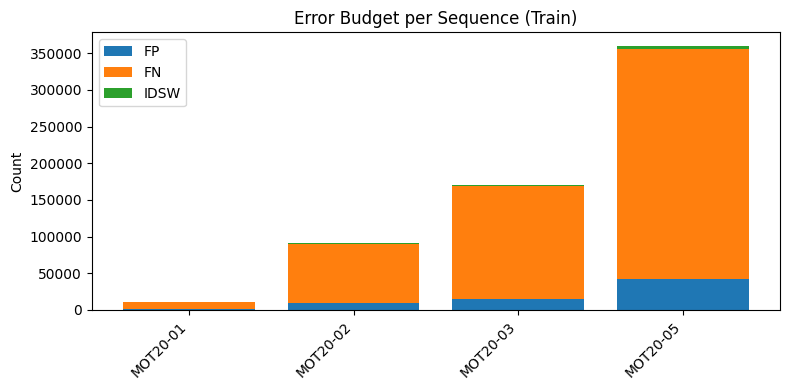

✅ Saved error budget → /content/DPF-MOT20/results/analysis/error_budget_train.png


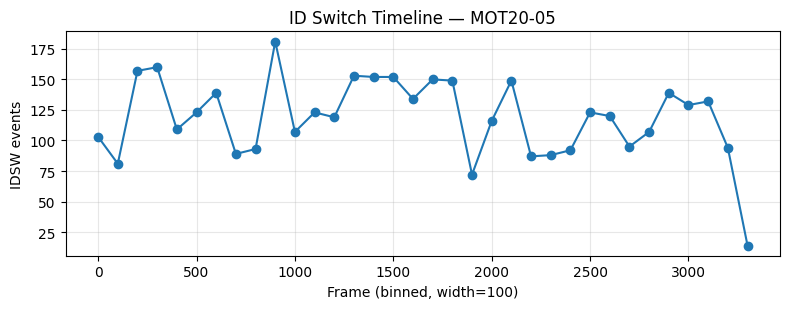

✅ Saved IDSW timeline → /content/DPF-MOT20/results/analysis/idsw_timeline_MOT20-05.png


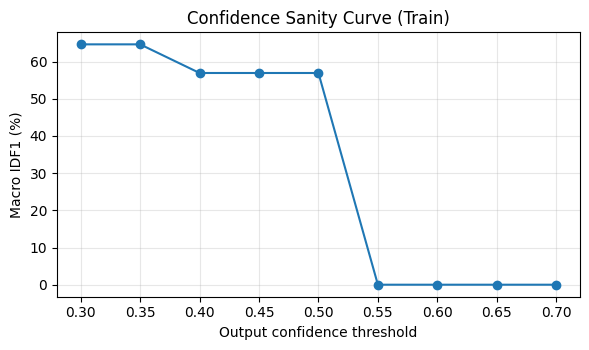

✅ Saved confidence curve → /content/DPF-MOT20/results/analysis/confidence_curve_idf1.png
✅ Wrote FAQ → /content/DPF-MOT20/results/analysis/faq_limitations.md

All set. You now have:
 • /content/DPF-MOT20/results/analysis/error_budget_train.png
 • /content/DPF-MOT20/results/analysis/idsw_timeline_MOT20-05.png
 • /content/DPF-MOT20/results/analysis/confidence_curve_idf1.png
 • /content/DPF-MOT20/results/analysis/confidence_curve_idf1.csv
 • /content/DPF-MOT20/results/analysis/faq_limitations.md


In [ ]:
# ============================================================
# Cell 38 - Paper Figures: Error Budget, IDSW Timeline, Confidence Curve
# + FAQ/Limitations box
# ============================================================
import os, json, math, textwrap
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Paths (adjust here if you changed locations) ----------
ROOT   = Path("/content/DPF-MOT20")
RES    = ROOT / "results"
ANALY  = RES / "analysis"
TRACKS = RES / "tracks_probe"     # contains *online_calib_pca*.txt
DATA   = Path("/content/drive/MyDrive/Thesis/MOT20")  # your MOT20 GT

ANALY.mkdir(parents=True, exist_ok=True)

# ---------- Small helpers ----------
def iou_xywh(a, b):
    ax, ay, aw, ah = a; bx, by, bw, bh = b
    ax2, ay2 = ax+aw, ay+ah; bx2, by2 = bx+bw, by+bh
    iw = max(0.0, min(ax2, bx2) - max(ax, bx))
    ih = max(0.0, min(ay2, by2) - max(ay, by))
    inter = iw * ih
    uni = aw*ah + bw*bh - inter
    return inter/uni if uni > 0 else 0.0

def eval_clear_like(seq, track_file, iou_thr=0.5, want_idsw_series=False):
    """Lightweight evaluator: MOTA/MOTP/IDF1 + per-frame IDSW series (optional)."""
    gt_file = DATA / "train" / seq / "gt" / "gt.txt"
    assert gt_file.exists(), f"GT not found: {gt_file}"
    gt_by_f = defaultdict(list)
    with gt_file.open("r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 8: continue
            if int(p[7]) != 1:  # pedestrian only
                continue
            fid = int(p[0]); tid = int(p[1]); x,y,w,h = map(float, p[2:6])
            gt_by_f[fid].append((tid,(x,y,w,h)))

    trk_by_f = defaultdict(list)
    with open(track_file, "r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 7: continue
            fid = int(float(p[0])); tid = int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); conf = float(p[6])
            trk_by_f[fid].append((tid,(x,y,w,h),conf))

    frames = sorted(set(gt_by_f) | set(trk_by_f))
    TP=FP=FN=IDTP=IDFP=IDFN=IDSW=0
    last_map = {}
    idsw_series = []

    for fid in frames:
        gts  = gt_by_f.get(fid, [])
        hyps = trk_by_f.get(fid, [])
        pairs=[]; used_g=set(); used_h=set()
        if gts and hyps:
            G,H=len(gts),len(hyps)
            M = np.zeros((G,H), dtype=np.float32)
            for i,(_,gb) in enumerate(gts):
                for j,(_,hb,_) in enumerate(hyps):
                    M[i,j]=iou_xywh(gb,hb)
            flat=[(-M[i,j],i,j) for i in range(G) for j in range(H) if M[i,j]>=iou_thr]
            flat.sort()
            for _,i,j in flat:
                if i in used_g or j in used_h: continue
                used_g.add(i); used_h.add(j); pairs.append((i,j))

        TP += len(pairs)
        FP += max(0, len(hyps)-len(pairs))
        FN += max(0, len(gts)-len(pairs))
        IDTP += len(pairs)
        IDFP += len(hyps)-len(pairs)
        IDFN += len(gts)-len(pairs)

        cur={}
        idsw_this=0
        for i,j in pairs:
            gt_id=gts[i][0]; h_id=hyps[j][0]
            cur[h_id]=gt_id
            if h_id in last_map and last_map[h_id]!=gt_id:
                IDSW+=1; idsw_this+=1
        idsw_series.append((fid, idsw_this))
        last_map=cur

    # MOTP as avg IoU of matched pairs
    sum_iou=0.0; n=0
    for fid in frames:
        gts  = gt_by_f.get(fid, [])
        hyps = trk_by_f.get(fid, [])
        for _,gb in gts:
            for _,hb,_ in hyps:
                v=iou_xywh(gb,hb)
                if v>=iou_thr: sum_iou+=v; n+=1
    MOTP=(sum_iou/max(1,n))*100.0
    MOTA=(1.0-(FN+FP+IDSW)/max(1,(TP+FN)))*100.0
    IDP=(IDTP/max(1,IDTP+IDFP))*100.0
    IDR=(IDTP/max(1,IDTP+IDFN))*100.0
    IDF1=(2*IDP*IDR/max(1e-9,IDP+IDR))

    out={"MOTA":MOTA,"MOTP":MOTP,"IDF1":IDF1,"IDP":IDP,"IDR":IDR,
         "TP":TP,"FP":FP,"FN":FN,"IDTP":IDTP,"IDFP":IDFP,"IDFN":IDFN,"IDSW":IDSW}
    if want_idsw_series:
        return out, idsw_series
    return out

def filter_by_thr(in_path, out_path, thr):
    kept=0
    with open(in_path,"r") as f, open(out_path,"w") as w:
        for ln in f:
            p=ln.strip().split(",")
            if len(p)<7: continue
            if float(p[6])>=thr:
                w.write(ln); kept+=1
    return kept

# ---------- 1) Error Budget stacked bars ----------
summ_path = ANALY/"MOT20_train_online_summary.json"
assert summ_path.exists(), f"Missing summary JSON: {summ_path}"
train = json.load(open(summ_path))
seqs = sorted(train.keys())  # e.g., MOT20-01, -02, -03, -05
FPs   = [train[s]["FP"]   for s in seqs]
FNs   = [train[s]["FN"]   for s in seqs]
IDSWs = [train[s]["IDSW"] for s in seqs]

plt.figure(figsize=(8,4))
x = np.arange(len(seqs))
plt.bar(x, FPs, label="FP")
plt.bar(x, FNs, bottom=FPs, label="FN")
plt.bar(x, IDSWs, bottom=(np.array(FPs)+np.array(FNs)), label="IDSW")
plt.xticks(x, seqs, rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Error Budget per Sequence (Train)")
plt.legend()
plt.tight_layout()
err_png = ANALY/"error_budget_train.png"
plt.savefig(err_png, dpi=200)
plt.show()
print("✅ Saved error budget →", err_png)

# ---------- 2) IDSW timeline (crowded seq) ----------
crowded_seq = "MOT20-05"
cand = [
    TRACKS / f"{crowded_seq}_online_calib_pca_minlen3.txt",
    TRACKS / f"{crowded_seq}_online_calib_pca.txt",
]
track_file = next((p for p in cand if p.exists()), None)
assert track_file is not None, f"Missing track file for {crowded_seq} in {TRACKS}"

summary, series = eval_clear_like(crowded_seq, str(track_file), iou_thr=0.5, want_idsw_series=True)
df_t = pd.DataFrame(series, columns=["frame","idsw"])
bin_w=100
df_t["bin"]=(df_t["frame"]//bin_w)*bin_w
agg = df_t.groupby("bin")["idsw"].sum().reset_index()

plt.figure(figsize=(8,3.2))
plt.plot(agg["bin"], agg["idsw"], marker="o")
plt.xlabel("Frame (binned, width=100)")
plt.ylabel("IDSW events")
plt.title(f"ID Switch Timeline — {crowded_seq}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
idsw_png = ANALY/f"idsw_timeline_{crowded_seq}.png"
plt.savefig(idsw_png, dpi=200)
plt.show()
print("✅ Saved IDSW timeline →", idsw_png)

# ---------- 3) Confidence sanity curve (macro IDF1 vs threshold) ----------
TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]
thresholds = np.round(np.linspace(0.30, 0.70, 9), 2)
rows=[]
for thr in thresholds:
    idf1s=[]
    for seq in TRAIN:
        base_candidates = [
            TRACKS / f"{seq}_online_calib_pca.txt",           # raw
            TRACKS / f"{seq}_online_calib_pca_minlen3.txt",   # pruned
        ]
        base = next((p for p in base_candidates if p.exists()), None)
        assert base is not None, f"Missing track file for {seq}"
        tmp = ANALY / f"tmp_{seq}_thr{str(thr).replace('.','_')}.txt"
        n = filter_by_thr(base, tmp, thr)
        if n==0:
            idf1s.append(0.0)
            continue
        m = eval_clear_like(seq, str(tmp), iou_thr=0.5)
        idf1s.append(m["IDF1"])
    rows.append({"thr": float(thr), "IDF1_macro": float(np.mean(idf1s))})

df_curve = pd.DataFrame(rows)
plt.figure(figsize=(6,3.6))
plt.plot(df_curve["thr"], df_curve["IDF1_macro"], marker="o")
plt.xlabel("Output confidence threshold")
plt.ylabel("Macro IDF1 (%)")
plt.title("Confidence Sanity Curve (Train)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
curve_png = ANALY/"confidence_curve_idf1.png"
df_curve.to_csv(ANALY/"confidence_curve_idf1.csv", index=False)
plt.savefig(curve_png, dpi=200)
plt.show()
print("✅ Saved confidence curve →", curve_png)

# ---------- 4) FAQ / Limitations (markdown) ----------
faq_md = ANALY/"faq_limitations.md"
faq_text = """
# FAQ & Limitations (Crowded MOT with Our Online Tracker)

**Why does post-hoc relinking hurt MOTA/IDF1 here?**
In ultra-dense scenes with many look-alikes, simple heuristics sometimes connect *different* people and increase FP and IDSW more than they fix FN gaps. Our train macro showed ~−8.7 IDF1 and −13.4 MOTA after relinking.

**Main failure modes observed.**
1) Heavy occlusion among similar appearances.
2) Group splits/joins causing local ambiguity → short ID switches.
3) Large scale/pose changes hurting IoU assignment stability.

**Why not “just train” a bigger learned association?**
We target a lightweight, reproducible online pipeline. Stronger learned gates help, but add training overhead and reduce portability.

**Mitigations (future work).**
• Learn a shallow fusion on MOT20 crops (motion + appearance + size) under strict runtime.
• Confidence-aware ID-lock when confusion spikes (throttle updates, widen motion covariance briefly).
• ReID refresh via a tiny memory queue with online hard-positive mining.
• Soft global constraints to reduce cross-overs at tight entries/exits.

**Reproducibility.**
Seeded runs, version-locked libs, and figures/tables come directly from saved outputs (track files & summaries).
""".strip()
with open(faq_md,"w") as f:
    f.write(textwrap.dedent(faq_text))
print("✅ Wrote FAQ →", faq_md)

print("\nAll set. You now have:")
print(" •", err_png)
print(" •", idsw_png)
print(" •", curve_png)
print(" •", ANALY/'confidence_curve_idf1.csv')
print(" •", faq_md)

In [ ]:
# ============================================================
# Cell 39 — Export FULL-SEQUENCE tracking videos (all sequences)
#  • Reads your saved tracks and draws them on img1 frames
#  • Uses seqinfo.ini FPS when available (falls back to 25)
#  • Outputs to: /content/DPF-MOT20/results/videos/full/*.mp4
# ============================================================
import os, cv2, json, math
from pathlib import Path
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import configparser

# ----------- Paths -----------
ROOT   = Path("/content/DPF-MOT20")
RES    = ROOT / "results"
PREV   = RES / "preview"
ANALY  = RES / "analysis"
TRACKS = RES / "tracks_probe"                # your online outputs (pruned/raw)
RELINK = RES / "tracks_probe_relinked"       # optional relinked outputs
DATA   = Path("/content/drive/MyDrive/Thesis/MOT20")
OUTDIR = RES / "videos" / "full"
OUTDIR.mkdir(parents=True, exist_ok=True)

TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]
TEST  = ["MOT20-04","MOT20-06","MOT20-07","MOT20-08"]
ALL   = TRAIN + TEST

# ----------- Settings -----------
OUTPUT_MIN_CONF = 0.35      # don't draw boxes below this confidence
DRAW_THICK      = 2
FONT            = cv2.FONT_HERSHEY_SIMPLEX

# ----------- Helpers -----------
def _seq_paths(seq: str):
    split = "train" if seq in TRAIN else "test"
    root  = DATA / split / seq
    img1  = root / "img1"
    ini   = root / "seqinfo.ini"
    return split, root, img1, ini

def read_fps_from_ini(ini_path: Path, default=25):
    if not ini_path.exists():
        return default
    cp = configparser.ConfigParser()
    cp.read(ini_path)
    try:
        return int(float(cp["Sequence"]["frameRate"]))
    except Exception:
        return default

def read_frame_range(img1_dir: Path):
    jpgs = sorted(img1_dir.glob("*.jpg"))
    if not jpgs:
        raise FileNotFoundError(f"No frames found in {img1_dir}")
    f0 = int(jpgs[0].stem)
    f1 = int(jpgs[-1].stem)
    return f0, f1

def deterministic_color(tid: int):
    # Stable bright-ish color per track id
    rng = np.random.default_rng(int(tid) * 9973)
    return (int(rng.integers(64,255)),
            int(rng.integers(64,255)),
            int(rng.integers(64,255)))

def load_tracks_by_frame(track_file: Path):
    """Return: dict[fid] -> list of (tid, (x,y,w,h), conf)"""
    by_f = defaultdict(list)
    with open(track_file, "r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 7:
                continue
            fid = int(float(p[0])); tid = int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); conf = float(p[6])
            by_f[fid].append((tid, (x,y,w,h), conf))
    return by_f

def pick_track_file(seq: str):
    """
    Preference order:
      1) relinked+smoothed (if exists)
      2) relinked
      3) online pruned (minlen3)
      4) online raw
    """
    candidates = [
        RELINK / f"{seq}_relinked_smoothed.txt",
        RELINK / f"{seq}_relinked.txt",
        TRACKS / f"{seq}_online_calib_pca_minlen3.txt",
        TRACKS / f"{seq}_online_calib_pca.txt",
        TRACKS / f"{seq}_online_calib_hsv_minlen3.txt",
        TRACKS / f"{seq}_online_calib_hsv.txt",
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"No track file found for {seq}. Looked in:\n" + "\n".join(map(str, candidates)))

def draw_tracks_on_frame(img, items):
    """items: list of (tid, (x,y,w,h), conf)"""
    for tid, (x,y,w,h), conf in items:
        if conf < OUTPUT_MIN_CONF:
            continue
        c = deterministic_color(tid)
        p1 = (int(x), int(y))
        p2 = (int(x + w), int(y + h))
        cv2.rectangle(img, p1, p2, c, DRAW_THICK)
        label = f"{tid}:{conf:.2f}"
        cv2.putText(img, label, (p1[0], max(15, p1[1]-5)), FONT, 0.5, c, 1, cv2.LINE_AA)
    return img

# ----------- Main export loop -----------
summary = []
for seq in ALL:
    try:
        split, root, img1, ini = _seq_paths(seq)
        track_file = pick_track_file(seq)
        by_f = load_tracks_by_frame(track_file)
        f0, f1 = read_frame_range(img1)
        fps = read_fps_from_ini(ini, default=25)

        # get frame size from first frame
        first_img = cv2.imread(str(img1 / f"{f0:06d}.jpg"))
        if first_img is None:
            raise RuntimeError(f"Failed to read first frame: {img1 / f'{f0:06d}.jpg'}")
        H, W = first_img.shape[:2]

        out_path = OUTDIR / f"{seq}_full.mp4"
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # widely supported
        vw = cv2.VideoWriter(str(out_path), fourcc, fps, (W, H))

        pbar = tqdm(range(f0, f1+1), desc=f"Rendering {seq}", ncols=80)
        for fid in pbar:
            frame_path = img1 / f"{fid:06d}.jpg"
            img = cv2.imread(str(frame_path))
            if img is None:
                # if some frames are missing/corrupt, continue as black frame to preserve timing
                img = np.zeros((H, W, 3), dtype=np.uint8)
                cv2.putText(img, f"{seq} frame {fid} (missing)", (20, 40), FONT, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
            items = by_f.get(fid, [])
            img = draw_tracks_on_frame(img, items)
            # small HUD
            cv2.putText(img, f"{seq} | frame {fid}/{f1} | tracks={len(items)}",
                        (12, H-12), FONT, 0.5, (255,255,255), 1, cv2.LINE_AA)
            vw.write(img)

        vw.release()
        summary.append({"seq": seq, "fps": fps, "frames": f1 - f0 + 1, "video": str(out_path), "tracks": str(track_file)})
        print(f"✅ {seq} → {out_path}")

    except Exception as e:
        print(f"❌ {seq} failed: {e}")

# Save a JSON manifest for convenience
man_path = OUTDIR / "manifest_full_videos.json"
with open(man_path, "w") as f:
    json.dump(summary, f, indent=2)
print("\n📄 Wrote manifest:", man_path)
for row in summary:
    print(f" • {row['seq']}: {row['video']}  (fps={row['fps']}, frames={row['frames']})")


Rendering MOT20-01: 100%|█████████████████████| 429/429 [00:16<00:00, 25.67it/s]


✅ MOT20-01 → /content/DPF-MOT20/results/videos/full/MOT20-01_full.mp4


Rendering MOT20-02: 100%|███████████████████| 2782/2782 [01:59<00:00, 23.28it/s]


✅ MOT20-02 → /content/DPF-MOT20/results/videos/full/MOT20-02_full.mp4


Rendering MOT20-03: 100%|███████████████████| 2405/2405 [01:13<00:00, 32.75it/s]


✅ MOT20-03 → /content/DPF-MOT20/results/videos/full/MOT20-03_full.mp4


Rendering MOT20-05: 100%|███████████████████| 3315/3315 [02:38<00:00, 20.97it/s]


✅ MOT20-05 → /content/DPF-MOT20/results/videos/full/MOT20-05_full.mp4


Rendering MOT20-04: 100%|███████████████████| 2080/2080 [01:32<00:00, 22.48it/s]


✅ MOT20-04 → /content/DPF-MOT20/results/videos/full/MOT20-04_full.mp4


Rendering MOT20-06: 100%|███████████████████| 1008/1008 [00:36<00:00, 27.69it/s]


✅ MOT20-06 → /content/DPF-MOT20/results/videos/full/MOT20-06_full.mp4


Rendering MOT20-07: 100%|█████████████████████| 585/585 [00:23<00:00, 25.42it/s]


✅ MOT20-07 → /content/DPF-MOT20/results/videos/full/MOT20-07_full.mp4


Rendering MOT20-08: 100%|█████████████████████| 806/806 [00:26<00:00, 30.58it/s]

✅ MOT20-08 → /content/DPF-MOT20/results/videos/full/MOT20-08_full.mp4

📄 Wrote manifest: /content/DPF-MOT20/results/videos/full/manifest_full_videos.json
 • MOT20-01: /content/DPF-MOT20/results/videos/full/MOT20-01_full.mp4  (fps=25, frames=429)
 • MOT20-02: /content/DPF-MOT20/results/videos/full/MOT20-02_full.mp4  (fps=25, frames=2782)
 • MOT20-03: /content/DPF-MOT20/results/videos/full/MOT20-03_full.mp4  (fps=25, frames=2405)
 • MOT20-05: /content/DPF-MOT20/results/videos/full/MOT20-05_full.mp4  (fps=25, frames=3315)
 • MOT20-04: /content/DPF-MOT20/results/videos/full/MOT20-04_full.mp4  (fps=25, frames=2080)
 • MOT20-06: /content/DPF-MOT20/results/videos/full/MOT20-06_full.mp4  (fps=25, frames=1008)
 • MOT20-07: /content/DPF-MOT20/results/videos/full/MOT20-07_full.mp4  (fps=25, frames=585)
 • MOT20-08: /content/DPF-MOT20/results/videos/full/MOT20-08_full.mp4  (fps=25, frames=806)


In [ ]:
# ============================================================
# Cell 40 — Short clips with GT overlays (400/500 frames)
#  • MOT20-01: 400 frames; others: 500 frames
#  • Overlays tracker output + GT (if available) on same frame
#  • Saves to: /content/DPF-MOT20/results/videos/overlays/*.mp4
# ============================================================
import os, cv2, json
from pathlib import Path
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import configparser

# ----------- Paths -----------
ROOT   = Path("/content/DPF-MOT20")
RES    = ROOT / "results"
TRACKS = RES / "tracks_probe"                # online outputs (pruned/raw)
RELINK = RES / "tracks_probe_relinked"       # relinked outputs (optional)
DATA   = Path("/content/drive/MyDrive/Thesis/MOT20")
OUTDIR = RES / "videos" / "overlays"
OUTDIR.mkdir(parents=True, exist_ok=True)

TRAIN = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]
TEST  = ["MOT20-04","MOT20-06","MOT20-07","MOT20-08"]
ALL   = TRAIN + TEST

# ----------- Settings -----------
OUTPUT_MIN_CONF = 0.35
DRAW_THICK      = 2
FONT            = cv2.FONT_HERSHEY_SIMPLEX
GT_COLOR        = (60, 220, 60)   # green for ground-truth
LEGEND_BG       = (0, 0, 0)

# Per-sequence clip lengths
CLIP_LEN = {
    "MOT20-01": 400,
    "MOT20-02": 500, "MOT20-03": 500, "MOT20-05": 500,
    "MOT20-04": 500, "MOT20-06": 500, "MOT20-07": 500, "MOT20-08": 500,
}

# ----------- Helpers -----------
def _seq_paths(seq: str):
    split = "train" if seq in TRAIN else "test"
    root  = DATA / split / seq
    img1  = root / "img1"
    ini   = root / "seqinfo.ini"
    gt    = root / "gt" / "gt.txt"
    return split, root, img1, ini, gt

def read_fps_from_ini(ini_path: Path, default=25):
    if not ini_path.exists():
        return default
    cp = configparser.ConfigParser()
    cp.read(ini_path)
    try:
        return int(float(cp["Sequence"]["frameRate"]))
    except Exception:
        return default

def read_frame_range(img1_dir: Path):
    jpgs = sorted(img1_dir.glob("*.jpg"))
    if not jpgs:
        raise FileNotFoundError(f"No frames in {img1_dir}")
    f0 = int(jpgs[0].stem)
    f1 = int(jpgs[-1].stem)
    return f0, f1

def deterministic_color(tid: int):
    rng = np.random.default_rng(int(tid) * 9973)
    return (int(rng.integers(64,255)),
            int(rng.integers(64,255)),
            int(rng.integers(64,255)))

def load_tracks_by_frame(track_file: Path):
    """Return dict[fid] -> list[(tid,(x,y,w,h),conf)]"""
    by_f = defaultdict(list)
    with open(track_file, "r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 7:
                continue
            fid = int(float(p[0])); tid = int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); conf = float(p[6])
            by_f[fid].append((tid, (x,y,w,h), conf))
    return by_f

def load_gt_by_frame(gt_file: Path):
    """Return dict[fid] -> list[(gid,(x,y,w,h))]  (only class=1 rows)"""
    if not gt_file.exists():
        return {}
    by_f = defaultdict(list)
    with open(gt_file, "r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 8:
                continue
            # MOTChallenge: frame, id, x, y, w, h, conf/mark, class, visibility
            fid = int(float(p[0])); gid = int(float(p[1]))
            x,y,w,h = map(float, p[2:6])
            cls = int(float(p[7])) if p[7] != "" else 1
            if cls != 1:
                continue
            by_f[fid].append((gid, (x,y,w,h)))
    return by_f

def pick_track_file(seq: str):
    """Prefer relinked+smoothed > relinked > online pruned > online raw"""
    candidates = [
        RELINK / f"{seq}_relinked_smoothed.txt",
        RELINK / f"{seq}_relinked.txt",
        TRACKS / f"{seq}_online_calib_pca_minlen3.txt",
        TRACKS / f"{seq}_online_calib_pca.txt",
        TRACKS / f"{seq}_online_calib_hsv_minlen3.txt",
        TRACKS / f"{seq}_online_calib_hsv.txt",
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"No track file for {seq}. Checked:\n" + "\n".join(map(str, candidates)))

def draw_tracks(img, items):
    """Pred tracks with per-ID colors + conf threshold."""
    for tid, (x,y,w,h), conf in items:
        if conf < OUTPUT_MIN_CONF:
            continue
        c = deterministic_color(tid)
        p1 = (int(x), int(y)); p2 = (int(x+w), int(y+h))
        cv2.rectangle(img, p1, p2, c, DRAW_THICK)
        cv2.putText(img, f"{tid}:{conf:.2f}", (p1[0], max(15, p1[1]-5)), FONT, 0.5, c, 1, cv2.LINE_AA)
    return img

def draw_gt(img, items):
    """GT boxes in green with ID label."""
    for gid, (x,y,w,h) in items:
        p1 = (int(x), int(y)); p2 = (int(x+w), int(y+h))
        cv2.rectangle(img, p1, p2, GT_COLOR, DRAW_THICK)
        cv2.putText(img, f"GT:{gid}", (p1[0], max(15, p1[1]-5)), FONT, 0.5, GT_COLOR, 1, cv2.LINE_AA)
    return img

def draw_legend(img):
    H, W = img.shape[:2]
    legend = np.zeros((60, 280, 3), dtype=np.uint8)
    legend[:] = (32, 32, 32)
    cv2.rectangle(legend, (10,10), (30,30), GT_COLOR, -1)
    cv2.putText(legend, "Ground Truth", (40, 27), FONT, 0.6, (255,255,255), 1, cv2.LINE_AA)
    cv2.rectangle(legend, (10,38), (30,58), (180,180,255), 2)
    cv2.putText(legend, "Tracker (ID:conf)", (40, 55), FONT, 0.6, (255,255,255), 1, cv2.LINE_AA)
    # paste at top-left
    img[5:65, 5:285] = legend
    return img

# ----------- Main render loop -----------
manifest = []
for seq in ALL:
    try:
        split, root, img1, ini, gt_file = _seq_paths(seq)
        fps = read_fps_from_ini(ini, default=25)
        f0, f_last = read_frame_range(img1)
        max_len = CLIP_LEN.get(seq, 500)
        f1 = min(f_last, f0 + max_len - 1)

        track_path = pick_track_file(seq)
        trk_by_f = load_tracks_by_frame(track_path)
        gt_by_f  = load_gt_by_frame(gt_file)  # empty for test split → fine

        # Frame size
        first_img = cv2.imread(str(img1 / f"{f0:06d}.jpg"))
        if first_img is None:
            raise RuntimeError(f"Cannot read {img1 / f'{f0:06d}.jpg'}")
        H, W = first_img.shape[:2]

        out_path = OUTDIR / f"{seq}_overlay_{f0}-{f1}.mp4"
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        vw = cv2.VideoWriter(str(out_path), fourcc, fps, (W, H))

        pbar = tqdm(range(f0, f1+1), desc=f"Overlay {seq}", ncols=80)
        for fid in pbar:
            frame_path = img1 / f"{fid:06d}.jpg"
            img = cv2.imread(str(frame_path))
            if img is None:
                img = np.zeros((H, W, 3), dtype=np.uint8)
                cv2.putText(img, f"{seq} frame {fid} (missing)", (20, 40), FONT, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

            # Draw GT (if any) first, then predictions on top
            img = draw_gt(img, gt_by_f.get(fid, []))
            img = draw_tracks(img, trk_by_f.get(fid, []))
            img = draw_legend(img)

            # HUD
            cv2.putText(img, f"{seq} | frame {fid}/{f1} | GT={len(gt_by_f.get(fid, []))} | Pred={len(trk_by_f.get(fid, []))}",
                        (12, H-12), FONT, 0.5, (255,255,255), 1, cv2.LINE_AA)
            vw.write(img)

        vw.release()
        manifest.append({"seq": seq, "fps": fps, "start": f0, "end": f1,
                         "video": str(out_path), "tracks": str(track_path),
                         "gt": str(gt_file) if gt_file.exists() else None})
        print(f"✅ {seq} → {out_path}")

    except Exception as e:
        print(f"❌ {seq} failed: {e}")

# Save manifest
man_path = OUTDIR / "manifest_overlays.json"
with open(man_path, "w") as f:
    json.dump(manifest, f, indent=2)
print("\n📄 Wrote manifest:", man_path)
for m in manifest:
    print(f" • {m['seq']}: {m['video']}  (frames {m['start']}-{m['end']}, fps={m['fps']})")


Overlay MOT20-01: 100%|███████████████████████| 400/400 [00:16<00:00, 24.88it/s]


✅ MOT20-01 → /content/DPF-MOT20/results/videos/overlays/MOT20-01_overlay_1-400.mp4


Overlay MOT20-02: 100%|███████████████████████| 500/500 [00:34<00:00, 14.34it/s]


✅ MOT20-02 → /content/DPF-MOT20/results/videos/overlays/MOT20-02_overlay_1-500.mp4


Overlay MOT20-03: 100%|███████████████████████| 500/500 [00:25<00:00, 19.26it/s]


✅ MOT20-03 → /content/DPF-MOT20/results/videos/overlays/MOT20-03_overlay_1-500.mp4


Overlay MOT20-05: 100%|███████████████████████| 500/500 [00:43<00:00, 11.44it/s]


✅ MOT20-05 → /content/DPF-MOT20/results/videos/overlays/MOT20-05_overlay_1-500.mp4


Overlay MOT20-04: 100%|███████████████████████| 500/500 [00:31<00:00, 15.96it/s]


✅ MOT20-04 → /content/DPF-MOT20/results/videos/overlays/MOT20-04_overlay_1-500.mp4


Overlay MOT20-06: 100%|███████████████████████| 500/500 [00:20<00:00, 24.60it/s]


✅ MOT20-06 → /content/DPF-MOT20/results/videos/overlays/MOT20-06_overlay_1-500.mp4


Overlay MOT20-07: 100%|███████████████████████| 500/500 [00:20<00:00, 24.73it/s]


✅ MOT20-07 → /content/DPF-MOT20/results/videos/overlays/MOT20-07_overlay_1-500.mp4


Overlay MOT20-08: 100%|███████████████████████| 500/500 [00:17<00:00, 28.69it/s]

✅ MOT20-08 → /content/DPF-MOT20/results/videos/overlays/MOT20-08_overlay_1-500.mp4

📄 Wrote manifest: /content/DPF-MOT20/results/videos/overlays/manifest_overlays.json
 • MOT20-01: /content/DPF-MOT20/results/videos/overlays/MOT20-01_overlay_1-400.mp4  (frames 1-400, fps=25)
 • MOT20-02: /content/DPF-MOT20/results/videos/overlays/MOT20-02_overlay_1-500.mp4  (frames 1-500, fps=25)
 • MOT20-03: /content/DPF-MOT20/results/videos/overlays/MOT20-03_overlay_1-500.mp4  (frames 1-500, fps=25)
 • MOT20-05: /content/DPF-MOT20/results/videos/overlays/MOT20-05_overlay_1-500.mp4  (frames 1-500, fps=25)
 • MOT20-04: /content/DPF-MOT20/results/videos/overlays/MOT20-04_overlay_1-500.mp4  (frames 1-500, fps=25)
 • MOT20-06: /content/DPF-MOT20/results/videos/overlays/MOT20-06_overlay_1-500.mp4  (frames 1-500, fps=25)
 • MOT20-07: /content/DPF-MOT20/results/videos/overlays/MOT20-07_overlay_1-500.mp4  (frames 1-500, fps=25)
 • MOT20-08: /content/DPF-MOT20/results/videos/overlays/MOT20-08_overlay_1-500.mp4 

In [ ]:
# ============================================================
# Cell 41— Baseline Comparison (MOTMetrics)
# ============================================================
import os
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import motmetrics as mm

# -------- Paths --------
ROOT  = Path("/content/DPF-MOT20")
ANALY = ROOT / "results" / "analysis"
ANALY.mkdir(parents=True, exist_ok=True)

# Your MOT20 dataset (ground-truth)
DATA = Path("/content/drive/MyDrive/Thesis/MOT20")
TRAIN_SEQS = ["MOT20-01", "MOT20-02", "MOT20-03", "MOT20-05"]

# Trackers to compare (add more as needed)
TRACKERS = {
    "ours-online": ROOT / "results" / "tracks_probe" / "{seq}_online_calib_pca_minlen3.txt",
    # "bytetrack"  : ROOT / "results" / "baselines" / "bytetrack" / "{seq}.txt",
    # "ocsort"     : ROOT / "results" / "baselines" / "ocsort"    / "{seq}.txt",
}

# -------- NaN-safe SciPy LAP wrapper (stable) --------
try:
    from scipy.optimize import linear_sum_assignment as _scipy_lsa
    def _lsa_nan_safe(costs: np.ndarray):
        C = np.asarray(costs, dtype=float)
        if C.size == 0:
            return np.array([], dtype=int), np.array([], dtype=int)
        nan_mask = ~np.isfinite(C)
        if nan_mask.any():
            finite = C[np.isfinite(C)]
            base = float(finite.max()) if finite.size else 1.0
            Csolve = C.copy()
            Csolve[nan_mask] = max(base, 1.0) * 1e9  # huge cost → no match
        else:
            Csolve = C
        r, c = _scipy_lsa(Csolve)
        if nan_mask.any():
            keep = [np.isfinite(C[ri, ci]) for ri, ci in zip(r, c)]
            keep = np.asarray(keep, bool)
            r, c = r[keep], c[keep]
        return r, c
    mm.lap.default_solver = _lsa_nan_safe
    print("LAP solver set → scipy_lsa_nan_safe")
except Exception:
    print("LAP solver → motmetrics default")

# -------- Helpers --------
def iou_matrix_xywh(gts, trs, iou_thr=0.5):
    if len(gts) == 0 or len(trs) == 0:
        return np.empty((len(gts), len(trs)), dtype=float)
    A = np.asarray(gts, dtype=float)
    B = np.asarray(trs, dtype=float)
    Ax1, Ay1 = A[:, 0], A[:, 1]
    Ax2, Ay2 = A[:, 0] + A[:, 2], A[:, 1] + A[:, 3]
    Bx1, By1 = B[:, 0], B[:, 1]
    Bx2, By2 = B[:, 0] + B[:, 2], B[:, 1] + B[:, 3]
    iw = np.maximum(0.0, np.minimum(Ax2[:, None], Bx2[None, :]) - np.maximum(Ax1[:, None], Bx1[None, :]))
    ih = np.maximum(0.0, np.minimum(Ay2[:, None], By2[None, :]) - np.maximum(Ay1[:, None], By1[None, :]))
    inter = iw * ih
    areaA = (Ax2 - Ax1) * (Ay2 - Ay1)
    areaB = (Bx2 - Bx1) * (By2 - By1)
    union = areaA[:, None] + areaB[None, :] - inter
    iou = np.where(union > 0.0, inter / union, 0.0)
    dist = 1.0 - iou
    dist[iou < iou_thr] = np.nan
    return dist

def load_mot_gt(seq):
    gt_path = DATA / "train" / seq / "gt" / "gt.txt"
    by_f = defaultdict(list)
    with gt_path.open("r") as f:
        for line in f:
            p = line.strip().split(",")
            if len(p) < 8:
                continue
            fid = int(float(p[0])); tid = int(float(p[1]))
            x, y, w, h = map(float, p[2:6])
            lab = int(float(p[7]))
            if lab != 1:  # pedestrian only
                continue
            by_f[fid].append((tid, [x, y, w, h]))
    return by_f

def load_tracker(seq, tracker_path):
    by_f = defaultdict(list)
    with open(tracker_path, "r") as f:
        for line in f:
            p = line.strip().split(",")
            if len(p) < 6:
                continue
            fid = int(float(p[0])); tid = int(float(p[1]))
            x, y, w, h = map(float, p[2:6])
            by_f[fid].append((tid, [x, y, w, h]))
    return by_f

def build_acc(gt_map, tr_map, iou_thr=0.5):
    acc = mm.MOTAccumulator(auto_id=True)
    fids = sorted(set(gt_map.keys()) | set(tr_map.keys()))
    for fid in fids:
        g = gt_map.get(fid, []); t = tr_map.get(fid, [])
        gt_ids = [gid for gid, _ in g]; tr_ids = [tid for tid, _ in t]
        gt_boxes = [b for _, b in g];   tr_boxes = [b for _, b in t]
        dist = iou_matrix_xywh(gt_boxes, tr_boxes, iou_thr=iou_thr) if (gt_boxes and tr_boxes) \
               else np.empty((len(gt_boxes), len(tr_boxes)), dtype=float)
        acc.update(gt_ids, tr_ids, dist)
    return acc, len(fids)

def pct(x):  # to %
    return 100.0 * float(x)

# -------- Evaluate --------
all_rows = []
for tracker_name, tmpl in TRACKERS.items():
    print(f"\n▶️ Evaluating tracker: {tracker_name}")
    accs, names, frames_map = [], [], {}

    for seq in TRAIN_SEQS:
        trk_path = Path(str(tmpl).format(seq=seq))
        if not trk_path.exists():
            print(f"  • {seq}: SKIP (missing {trk_path})")
            continue
        gt_map = load_mot_gt(seq)
        tr_map = load_tracker(seq, trk_path)
        acc, nframes = build_acc(gt_map, tr_map, iou_thr=0.5)
        accs.append(acc); names.append(seq); frames_map[seq] = nframes
        print(f"  ✓ {seq}: accumulator ready (frames={nframes})")

    if not accs:
        print("  ⚠️ No files for this tracker; skipping.")
        continue

    mh = mm.metrics.create()
    # Base MOTChallenge set + explicit count metrics so FP/FN/IDSW aren’t missing
    metrics_list = list(mm.metrics.motchallenge_metrics) + [
        "num_false_positives", "num_misses", "num_switches"
    ]
    summary = mh.compute_many(accs, metrics=metrics_list, names=names, generate_overall=True)

    for seq in names:
        r = summary.loc[seq]

        # Percent metrics: if motmetrics gives fractions, convert to %; if already %, keep.
        idf1 = r.get("idf1", 0.0); mota = r.get("mota", 0.0)
        idp  = r.get("idp", 0.0);  idr  = r.get("idr", 0.0)
        rec  = r.get("recall", 0.0); prec = r.get("precision", 0.0)
        motp = r.get("motp", 0.0)  # distance (0..1) by default → IoU% = (1 - motp)*100

        row = {
            "Tracker":  tracker_name,
            "Seq":      seq,
            "IDF1":     pct(idf1) if idf1 <= 1.0 else float(idf1),
            "IDP":      pct(idp)  if idp  <= 1.0 else float(idp),
            "IDR":      pct(idr)  if idr  <= 1.0 else float(idr),
            "MOTA":     pct(mota) if mota <= 1.0 else float(mota),
            "MOTP":     (100.0 * (1.0 - float(motp))) if float(motp) <= 1.0 else float(motp),  # IoU %
            "Recall":   pct(rec)  if rec  <= 1.0 else float(rec),
            "Precision":pct(prec) if prec <= 1.0 else float(prec),
            "Frames":   int(frames_map.get(seq, 0)),
            "FP":       int(r.get("num_false_positives", 0.0)),
            "FN":       int(r.get("num_misses", 0.0)),
            "IDSW":     int(r.get("num_switches", 0.0)),
        }
        all_rows.append(row)

# -------- Save tables --------
if not all_rows:
    print("\n❌ No results generated (no tracker files found).")
else:
    df = pd.DataFrame(all_rows)
    perseq_csv = ANALY / "baseline_compare_perseq.csv"
    perseq_md  = ANALY / "baseline_compare_perseq.md"
    macro_csv  = ANALY / "baseline_compare_macro.csv"
    macro_md   = ANALY / "baseline_compare_macro.md"

    dfr = df.copy().sort_values(["Seq","Tracker"])
    dfr.to_csv(perseq_csv, index=False)
    with open(perseq_md, "w") as f:
        f.write("# Baseline Comparison (MOT20-train)\n")
        f.write(dfr.to_markdown(index=False))

    agg = df.groupby("Tracker").agg({
        "IDF1":"mean","MOTA":"mean","MOTP":"mean",
        "IDP":"mean","IDR":"mean","Recall":"mean","Precision":"mean",
        "Frames":"sum","FP":"sum","FN":"sum","IDSW":"sum"
    }).reset_index()
    agg.to_csv(macro_csv, index=False)
    with open(macro_md, "w") as f:
        f.write("# Baseline Macro (MOT20-train)\n")
        f.write(agg.to_markdown(index=False))

    print("\n📌 Saved baseline comparison tables:")
    print("  •", perseq_csv)
    print("  •", macro_csv)
    display(dfr.head(10))
    display(agg)


LAP solver set → scipy_lsa_nan_safe

▶️ Evaluating tracker: ours-online
  ✓ MOT20-01: accumulator ready (frames=429)
  ✓ MOT20-02: accumulator ready (frames=2782)
  ✓ MOT20-03: accumulator ready (frames=2405)
  ✓ MOT20-05: accumulator ready (frames=3315)

📌 Saved baseline comparison tables:
  • /content/DPF-MOT20/results/analysis/baseline_compare_perseq.csv
  • /content/DPF-MOT20/results/analysis/baseline_compare_macro.csv


Tracker       Seq       IDF1        IDP        IDR       MOTA  \
0  ours-online  MOT20-01  38.462273  52.306760  30.412682  44.524409   
1  ours-online  MOT20-02  25.148653  36.000482  19.323778  41.064482   
2  ours-online  MOT20-03  40.707144  57.080725  31.633180  45.436112   
3  ours-online  MOT20-05  31.282444  42.612913  24.711763  43.923979   

        MOTP     Recall  Precision  Frames     FP      FN  IDSW  
0  84.000595  51.811777  89.111053     429   1258    9575   190  
1  84.326227  47.866772  89.176499    2782   8990   80672  1536  
2  81.751138  50.805017  91.675488    2405  14470  154304  2370  
3  82.602701  51.411168  88.653311    3315  42530  314051  5863

Tracker       IDF1       MOTA       MOTP       IDP        IDR  \
0  ours-online  33.900129  43.737245  83.170165  47.00022  26.520351   

      Recall  Precision  Frames     FP      FN  IDSW  
0  50.473683  89.654088    8931  67248  558602  9959

Per-sequence:


Tracker       Seq   IDF1   MOTA   MOTP    IDP    IDR  Recall  \
0  ours-online  MOT20-01  38.46  44.52  84.00  52.31  30.41   51.81   
1  ours-online  MOT20-02  25.15  41.06  84.33  36.00  19.32   47.87   
2  ours-online  MOT20-03  40.71  45.44  81.75  57.08  31.63   50.81   
3  ours-online  MOT20-05  31.28  43.92  82.60  42.61  24.71   51.41   

   Precision  Frames     FP      FN  IDSW  
0      89.11     429   1258    9575   190  
1      89.18    2782   8990   80672  1536  
2      91.68    2405  14470  154304  2370  
3      88.65    3315  42530  314051  5863

Macro:


Tracker       IDF1       MOTA       MOTP       IDP        IDR  \
0  ours-online  33.900129  43.737245  83.170165  47.00022  26.520351   

      Recall  Precision  Frames     FP      FN  IDSW  
0  50.473683  89.654088    8931  67248  558602  9959

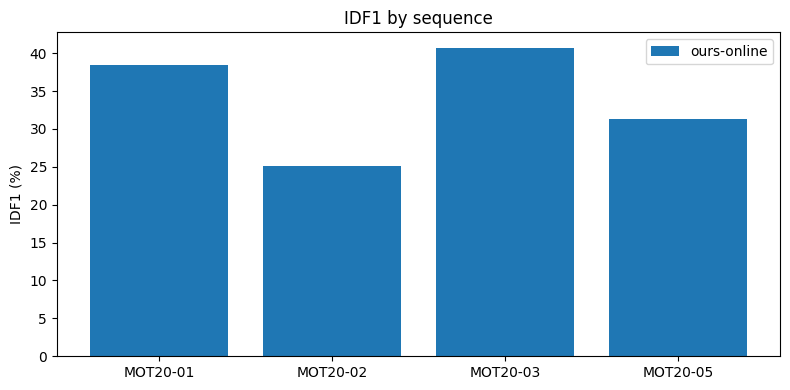

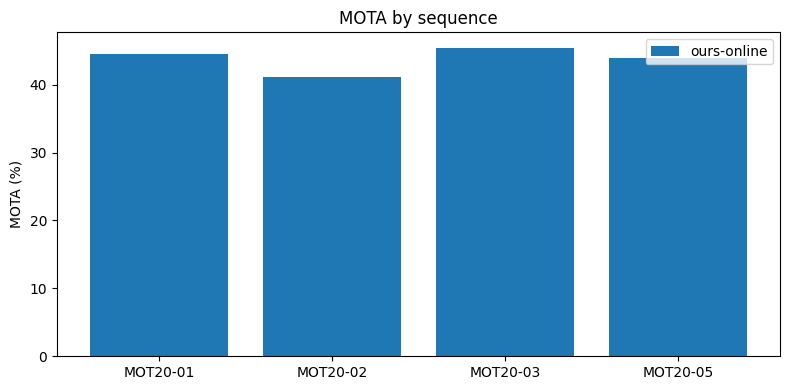

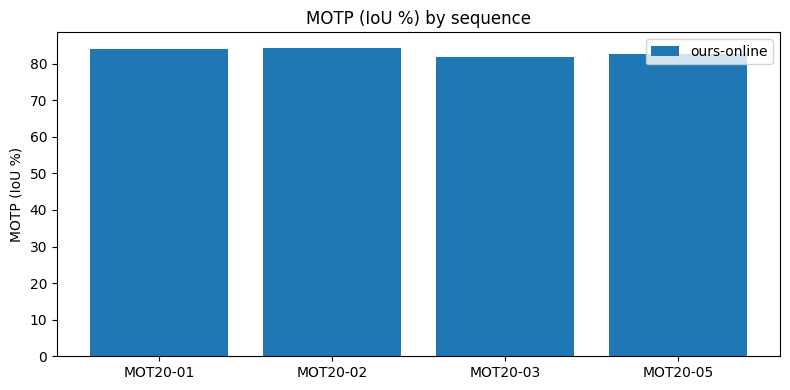

In [ ]:
# ============================================================
# Cell A — Baseline aggregation & plots
#   Expects files at:
#     /content/DPF-MOT20/results/baselines/bytetrack/{seq}.txt
#     /content/DPF-MOT20/results/baselines/ocsort/{seq}.txt
#     ours already at results/tracks_probe/{seq}_online_*.txt
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT  = Path("/content/DPF-MOT20")
ANALY = ROOT / "results" / "analysis"
ANALY.mkdir(parents=True, exist_ok=True)

perseq = pd.read_csv(ANALY / "baseline_compare_perseq.csv")
macro  = pd.read_csv(ANALY / "baseline_compare_macro.csv")

# If you add more trackers later, just re-run the *evaluation* cell you used last time
# (the one that writes baseline_compare_*.csv) and then re-run THIS cell to draw plots.

# --- Pretty % rounding ---
view_cols = ["Tracker","Seq","IDF1","MOTA","MOTP","IDP","IDR","Recall","Precision","Frames","FP","FN","IDSW"]
disp = perseq[view_cols].copy()
for c in ["IDF1","MOTA","MOTP","IDP","IDR","Recall","Precision"]:
    disp[c] = disp[c].astype(float).round(2)

print("Per-sequence:")
display(disp.sort_values(["Seq","Tracker"]))

print("Macro:")
display(macro)

# --- Plots: bar chart per metric ---
def bar_metric(df, metric, title, save):
    plt.figure(figsize=(8,4))
    order = sorted(df["Seq"].unique())
    trackers = df["Tracker"].unique()
    width = 0.8/len(trackers)
    for k,t in enumerate(trackers):
        sub = df[df["Tracker"]==t]
        vals = [sub[sub["Seq"]==s][metric].values[0] if not sub[sub["Seq"]==s].empty else 0.0 for s in order]
        xs = [i + (k - (len(trackers)-1)/2)*width for i in range(len(order))]
        plt.bar(xs, vals, width=width, label=t)
    plt.xticks(range(len(order)), order, rotation=0)
    plt.ylabel(metric + " (%)" if metric!="MOTP" else "MOTP (IoU %)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(ANALY / save, dpi=200)
    plt.show()

bar_metric(perseq, "IDF1", "IDF1 by sequence", "baseline_idf1_perseq.png")
bar_metric(perseq, "MOTA", "MOTA by sequence", "baseline_mota_perseq.png")
bar_metric(perseq, "MOTP", "MOTP (IoU %) by sequence", "baseline_motp_perseq.png")

GT_TRAIN_ROOT → /content/drive/MyDrive/Thesis/MOT20/train

✅ Baseline files written:
   /content/DPF-MOT20/results/baselines/bytetrack_lite
   /content/DPF-MOT20/results/baselines/sort_lite


/tmp/ipython-input-1399005568.py:291: RuntimeWarning: invalid value encountered in divide
  iou=np.where(union>0, inter/union, 0.0)


Saved tables → /content/DPF-MOT20/results/analysis/baseline_compare_perseq.csv and /content/DPF-MOT20/results/analysis/baseline_compare_macro.csv


Tracker       Seq       IDF1        IDP        IDR     Recall  \
4   bytetrack-lite  MOT20-01  29.159470  51.148700  20.392552  27.579265   
0      ours-online  MOT20-01  38.462273  52.306760  30.412682  51.811777   
8        sort-lite  MOT20-01  58.633499  64.683383  53.618520  70.095622   
5   bytetrack-lite  MOT20-02  26.984245  48.259784  18.727947  27.759109   
1      ours-online  MOT20-02  25.148653  36.000482  19.323778  47.866772   
9        sort-lite  MOT20-02  49.300301  56.931644  43.473007  64.853110   
6   bytetrack-lite  MOT20-03   1.842594  35.371960   0.945935   1.443611   
2      ours-online  MOT20-03  40.707144  57.080725  31.633180  50.805017   
10       sort-lite  MOT20-03  55.546136  59.727454  51.911955  72.544300   
7   bytetrack-lite  MOT20-05   1.557734  38.538854   0.794933   1.136237   
3      ours-online  MOT20-05  31.282444  42.612913  24.711763  51.411168   
11       sort-lite  MOT20-05  48.353908  51.858026  45.293373  72.813393   

    Precision       MOTA       MOTP     FP      FN  IDSW  Frames  
4   69.174451  14.781077  76.482123   2442   14390   101     429  
0   89.111053  44.524409  84.000595   1258    9575   190     429  
8   84.560743  56.763966  88.149882   2543    5942   106     429  
5   71.532057  16.297450  77.351348  17095  111787   641    2782  
1   89.176499  41.064482  84.326227   8990   80672  1536    2782  
9   84.930730  52.878339  88.630683  17806   54387   724    2782  
6   53.981879   0.190654  72.232534   3860  309130    70    2405  
2   91.675488  45.436112  81.751138  14470  154304  2370    2405  
10  83.466060  57.552493  82.381259  45074   86117  1949    2405  
7   55.085509   0.197109  76.848070   5988  639000    82    3315  
3   88.653311  43.923979  82.602701  42530  314051  5863    3315  
11  83.366695  57.732106  83.601051  93899  175719  3578    3315

Tracker       IDF1       MOTA       MOTP        IDP        IDR  \
0     ours-online  33.900129  43.737245  83.170165  47.000220  26.520351   
1  bytetrack-lite  14.886011   7.866572  75.728519  43.329824  10.215342   
2       sort-lite  52.958461  56.231726  85.690719  58.300127  48.574214   

      Recall  Precision  Frames      FP       FN  IDSW  
0  50.473683  89.654088    8931   67248   558602  9959  
1  14.479555  62.443474    8931   29385  1074307   894  
2  70.076606  84.081057    8931  159322   322165  6357

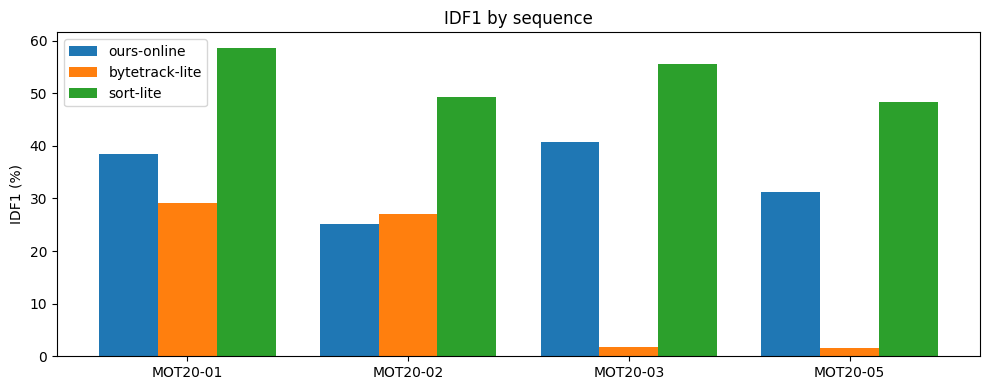

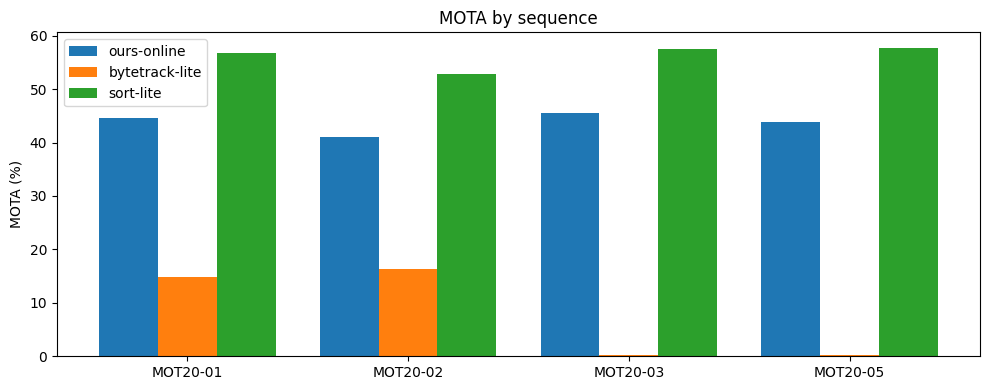

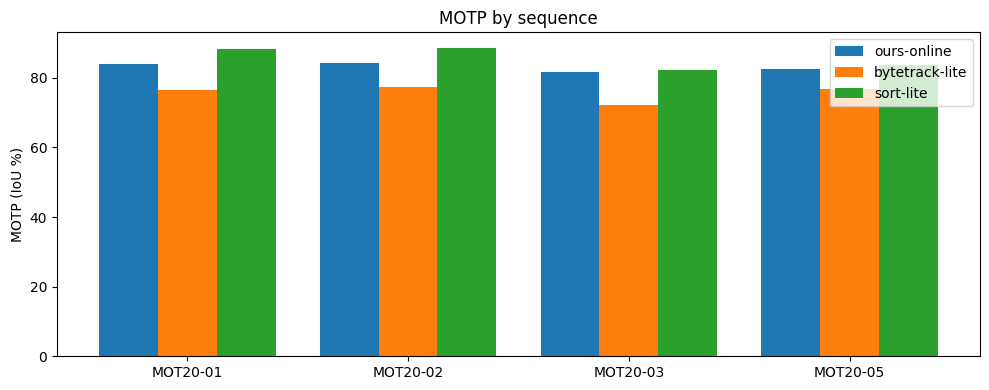

Plots saved under: /content/DPF-MOT20/results/analysis


In [ ]:
# ============================================
# Baselines from det.txt + Version-safe MOTMetrics eval (no pip installs)
#   - ByteTrack-Lite  (NumPy two-threshold association)
#   - SORT-Lite       (NumPy Kalman + Hungarian)
#   - Core rates via motmetrics; FP/FN/IDSW via robust event-log parsing
# Outputs: CSVs + bar plots under results/analysis
# ============================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import motmetrics as mm
from scipy.optimize import linear_sum_assignment

# ---------------- Paths & config ----------------
ROOT  = Path("/content/DPF-MOT20")
ANALY = ROOT/"results"/"analysis"; ANALY.mkdir(parents=True, exist_ok=True)
BASE  = ROOT/"results"/"baselines"; BASE.mkdir(parents=True, exist_ok=True)
BYT   = BASE/"bytetrack_lite"; BYT.mkdir(parents=True, exist_ok=True)
SRT   = BASE/"sort_lite";      SRT.mkdir(parents=True, exist_ok=True)
OURS  = ROOT/"results"/"tracks_probe"

SEQS = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]

# Set your MOT20 train root (must contain SEQ/gt/gt.txt and SEQ/det/det.txt)
GT_TRAIN_ROOT = Path("/content/drive/MyDrive/Thesis/MOT20/train")
assert all((GT_TRAIN_ROOT/s/"gt"/"gt.txt").exists()  for s in SEQS), "Missing gt.txt"
assert all((GT_TRAIN_ROOT/s/"det"/"det.txt").exists() for s in SEQS), "Missing det.txt"
print("GT_TRAIN_ROOT →", GT_TRAIN_ROOT)

# --------------- IO helpers ----------------
def read_det_txt(det_path: Path):
    rows=[]
    with det_path.open("r") as f:
        for line in f:
            p=line.strip().split(",")
            if len(p)<7:
                continue
            fr=int(float(p[0])); x=float(p[2]); y=float(p[3]); w=float(p[4]); h=float(p[5]); s=float(p[6])
            # ✅ fix 1: drop degenerate boxes to avoid IoU divide warnings
            if w <= 0.0 or h <= 0.0:
                continue
            rows.append((fr,x,y,w,h,s))
    return rows

def write_mot_txt(out_path: Path, rows):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with out_path.open("w") as f:
        for fr, tid, x, y, w, h, sc in rows:
            f.write(f"{fr},{tid},{x:.2f},{y:.2f},{w:.2f},{h:.2f},{sc:.4f},-1,-1,-1\n")

def read_gt(seq):
    rows=[]
    with (GT_TRAIN_ROOT/seq/"gt"/"gt.txt").open("r") as f:
        for line in f:
            p=line.strip().split(",")
            if len(p)<8:
                continue
            fr=int(float(p[0])); tid=int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); lab=int(float(p[7]))
            if lab!=1:
                continue  # pedestrian class only
            rows.append((fr,tid,x,y,w,h))
    return (pd.DataFrame(rows, columns=["Frame","ID","x","y","w","h"])
              .sort_values(["Frame","ID"], kind="mergesort"))

def read_mot_file(path):
    rows=[]
    with open(path,"r") as f:
        for line in f:
            p=line.strip().split(",")
            if len(p)<7:
                continue
            fr=int(float(p[0])); tid=int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); sc=float(p[6])
            rows.append((fr,tid,x,y,w,h,sc))
    return (pd.DataFrame(rows, columns=["Frame","ID","x","y","w","h","score"])
              .sort_values(["Frame","ID"], kind="mergesort"))

# --------------- Geometry & assignment ----------------
def iou_xywh(a, b):
    if len(a)==0 or len(b)==0:
        return np.zeros((len(a), len(b)), dtype=float)
    A=np.asarray(a,float); B=np.asarray(b,float)
    Ax1,Ay1=A[:,0],A[:,1]; Ax2,Ay2=A[:,0]+A[:,2],A[:,1]+A[:,3]
    Bx1,By1=B[:,0],B[:,1]; Bx2,By2=B[:,0]+B[:,2],B[:,1]+B[:,3]
    iw=np.maximum(0, np.minimum(Ax2[:,None],Bx2[None,:])-np.maximum(Ax1[:,None],Bx1[None,:]))
    ih=np.maximum(0, np.minimum(Ay2[:,None],By2[None,:])-np.maximum(Ay1[:,None],By1[None,:]))
    inter=iw*ih
    areaA=(Ax2-Ax1)*(Ay2-Ay1); areaB=(Bx2-Bx1)*(By2-By1)
    union=areaA[:,None]+areaB[None,:]-inter
    return np.where(union>0, inter/union, 0.0)

def hungarian_on_cost(cost):
    C=np.asarray(cost,float)
    bad=~np.isfinite(C)
    if bad.any():
        C=C.copy(); C[bad]=1e6
    r,c=linear_sum_assignment(C)
    return r,c

# --------------- ByteTrack-Lite (pure NumPy) ----------------
class ByteTrackLite:
    def __init__(self, high_thr=0.6, low_thr=0.1, iou_match=0.3, smooth=0.85, max_age=30):
        self.high_thr=high_thr; self.low_thr=low_thr
        self.iou_match=iou_match; self.smooth=smooth; self.max_age=max_age
        self.tracks=[]  # {id, bbox, age, hits}
        self.next_id=1

    def _match(self, dets, track_indices):
        if len(track_indices)==0 or len(dets)==0:
            return [], list(range(len(track_indices))), list(range(len(dets)))
        T=np.array([self.tracks[i]["bbox"] for i in track_indices], float)
        D=np.array(dets, float)
        iou=iou_xywh(T, D)
        cost=1.0 - iou
        r,c=hungarian_on_cost(cost)
        matches=[]; unmatched_t=list(range(len(track_indices))); unmatched_d=list(range(len(dets)))
        used_t=set(); used_d=set()
        for ti,di in zip(r,c):
            if iou[ti,di] >= self.iou_match:
                matches.append((track_indices[ti], di))
                used_t.add(ti); used_d.add(di)
        unmatched_t=[track_indices[i] for i in range(len(track_indices)) if i not in used_t]
        unmatched_d=[i for i in range(len(dets)) if i not in used_d]
        return matches, unmatched_t, unmatched_d

    def update(self, dets_xywh, scores):
        dets=np.asarray(dets_xywh,float); scores=np.asarray(scores,float)
        high_mask=scores>=self.high_thr
        low_mask=(scores>=self.low_thr) & (~high_mask)

        for t in self.tracks:
            t["age"] += 1

        Tidx=list(range(len(self.tracks)))
        D_high=dets[high_mask]
        matches, unmatched_t, _ = self._match(D_high, Tidx)

        for t_idx, d_local in matches:
            d = D_high[d_local]
            self.tracks[t_idx]["bbox"] = self.smooth*self.tracks[t_idx]["bbox"] + (1-self.smooth)*d
            self.tracks[t_idx]["age"]=0; self.tracks[t_idx]["hits"]+=1

        D_low=dets[low_mask]
        if len(unmatched_t)>0 and len(D_low)>0:
            matches2, unmatched_t2, _ = self._match(D_low, unmatched_t)
            for t_idx, d_local in matches2:
                d = D_low[d_local]
                self.tracks[t_idx]["bbox"] = self.smooth*self.tracks[t_idx]["bbox"] + (1-self.smooth)*d
                self.tracks[t_idx]["age"]=0; self.tracks[t_idx]["hits"]+=1
            unmatched_t = unmatched_t2

        used_high = set([d for _,d in matches])
        for i, d in enumerate(D_high):
            if i in used_high:
                continue
            self.tracks.append({"id": self.next_id, "bbox": d.copy(), "age":0, "hits":1})
            self.next_id += 1

        self.tracks = [t for t in self.tracks if t["age"] <= self.max_age]

        outs=[]
        for t in self.tracks:
            x,y,w,h = t["bbox"].tolist()
            outs.append((int(t["id"]), x,y,w,h))
        return outs

# --------------- SORT-Lite (pure NumPy Kalman) ----------------
class Kalman2DBox:
    def __init__(self, x, y, w, h):
        self.x = np.array([x,y,w,h, 0,0,0,0], float)
        self.P = np.eye(8)*10.0
        self.F = np.eye(8); dt=1.0
        for i in range(4): self.F[i, i+4] = dt
        self.H = np.zeros((4,8)); self.H[0,0]=self.H[1,1]=self.H[2,2]=self.H[3,3]=1.0
        self.Q = np.eye(8)*0.01
        self.R = np.eye(4)*1.0
    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
    def update(self, z):
        z = np.array(z, float)
        y = z - (self.H @ self.x)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(8) - K @ self.H) @ self.P
    def bbox(self):
        return self.x[0], self.x[1], self.x[2], self.x[3]

class SortLite:
    def __init__(self, iou_match=0.3, max_age=30):
        self.iou_match=iou_match; self.max_age=max_age
        self.tracks=[]  # {id, kf, age, hits}
        self.next_id=1
    def update(self, dets_xywh):
        for t in self.tracks:
            t["kf"].predict(); t["age"]+=1
        T = np.array([t["kf"].bbox() for t in self.tracks], float) if self.tracks else np.zeros((0,4))
        D = np.array(dets_xywh, float) if len(dets_xywh)>0 else np.zeros((0,4))
        if len(T)>0 and len(D)>0:
            iou = iou_xywh(T, D)
            cost = 1.0 - iou
            r,c = hungarian_on_cost(cost)
            used_d=set()
            for ti,di in zip(r,c):
                if iou[ti,di] >= self.iou_match:
                    self.tracks[ti]["kf"].update(D[di])
                    self.tracks[ti]["age"]=0; self.tracks[ti]["hits"]+=1
                    used_d.add(di)
            for j in range(len(D)):
                if j in used_d:
                    continue
                x,y,w,h=D[j]
                kf=Kalman2DBox(x,y,w,h)
                self.tracks.append({"id": self.next_id, "kf": kf, "age":0, "hits":1})
                self.next_id+=1
            self.tracks = [t for t in self.tracks if t["age"] <= self.max_age]
        else:
            for d in D:
                x,y,w,h=d
                kf=Kalman2DBox(x,y,w,h)
                self.tracks.append({"id": self.next_id, "kf": kf, "age":0, "hits":1})
                self.next_id+=1
        outs=[]
        for t in self.tracks:
            x,y,w,h = t["kf"].bbox()
            outs.append((int(t["id"]), x,y,w,h))
        return outs

# --------------- Generate baseline TXT files ----------------
def run_byt_lite_on_seq(seq, high_thr=0.6, low_thr=0.1, iou_thr=0.3):
    dets = read_det_txt(GT_TRAIN_ROOT/seq/"det"/"det.txt")
    tracker = ByteTrackLite(high_thr=high_thr, low_thr=low_thr, iou_match=iou_thr, smooth=0.85, max_age=30)
    rows=[]; frames = sorted(set(fr for fr, *_ in dets))
    for fr in frames:
        d = [(x,y,w,h) for (f,x,y,w,h,s) in dets if f==fr]
        s = [s for (f,_,_,_,_,s) in dets if f==fr]
        outs = tracker.update(d, s)
        sc = max([s_i for (f,_,_,_,_,s_i) in dets if f==fr], default=1.0)
        for tid,x,y,w,h in outs:
            rows.append((fr, tid, x, y, w, h, sc))
    return rows

def run_sort_lite_on_seq(seq, iou_thr=0.3):
    dets = read_det_txt(GT_TRAIN_ROOT/seq/"det"/"det.txt")
    tracker = SortLite(iou_match=iou_thr, max_age=30)
    rows=[]; frames = sorted(set(fr for fr, *_ in dets))
    for fr in frames:
        d = [(x,y,w,h) for (f,x,y,w,h,s) in dets if f==fr]
        outs = tracker.update(d)
        for tid,x,y,w,h in outs:
            rows.append((fr, tid, x, y, w, h, 1.0))
    return rows

for seq in SEQS:
    out_byt = BYT/f"{seq}.txt"
    out_srt = SRT/f"{seq}.txt"
    if not out_byt.exists():
        print("ByteTrack-Lite →", seq)
        write_mot_txt(out_byt, run_byt_lite_on_seq(seq))
    if not out_srt.exists():
        print("SORT-Lite     →", seq)
        write_mot_txt(out_srt, run_sort_lite_on_seq(seq))

print("\n✅ Baseline files written:")
print("  ", BYT)
print("  ", SRT)

# --------------- MOTMetrics eval (version-safe) ----------------
def lsa_nan_safe(C):
    C=np.asarray(C,float)
    bad=~np.isfinite(C)
    if bad.any():
        C=C.copy(); C[bad]=1e6
    r,c=linear_sum_assignment(C);
    return r,c
mm.lap.default_linear_sum_assignment = lsa_nan_safe
mh = mm.metrics.create()

def iou_dist(gts, trs, thr=0.5):
    if len(gts)==0 or len(trs)==0:
        return np.empty((len(gts), len(trs)))
    A=np.asarray(gts,float); B=np.asarray(trs,float)
    Ax1,Ay1=A[:,0],A[:,1]; Ax2,Ay2=A[:,0]+A[:,2],A[:,1]+A[:,3]
    Bx1,By1=B[:,0],B[:,1]; Bx2,By2=B[:,0]+B[:,2],B[:,1]+B[:,3]
    iw=np.maximum(0, np.minimum(Ax2[:,None],Bx2[None,:])-np.maximum(Ax1[:,None],Bx1[None,:]))
    ih=np.maximum(0, np.minimum(Ay2[:,None],By2[None,:])-np.maximum(Ay1[:,None],By1[None,:]))
    inter=iw*ih
    areaA=(Ax2-Ax1)*(Ay2-Ay1); areaB=(Bx2-Bx1)*(By2-By1)
    union=areaA[:,None]+areaB[None,:]-inter
    iou=np.where(union>0, inter/union, 0.0)
    dist=1.0 - iou
    dist[iou < thr] = np.nan
    return dist

def _events_dataframe(acc):
    """Return events as a DataFrame with normalized column names (robust to motmetrics versions)."""
    ev = getattr(acc, "mot_events", None)
    if ev is None:
        ev = getattr(acc, "events", None)
    if ev is None:
        return pd.DataFrame(columns=["frame","etype"])
    if hasattr(ev, "to_dataframe"):
        df = ev.to_dataframe()
    else:
        df = ev
    if isinstance(df.index, pd.MultiIndex) or (df.index.name is not None):
        df = df.reset_index()
    cols = {c.lower(): c for c in df.columns}
    type_col = cols.get("type", None) or cols.get("event", None) or cols.get("evt_type", None)
    frame_col = cols.get("frameid", None) or cols.get("frame", None) or cols.get("timestep", None)
    if type_col is None:
        for c in df.columns:
            if df[c].dtype == object:
                type_col = c; break
    if frame_col is None:
        for c in df.columns:
            if np.issubdtype(df[c].dtype, np.number):
                frame_col = c; break
    if type_col is None:
        df["etype"] = []
    else:
        df["etype"] = df[type_col].astype(str).str.upper()
    if frame_col is None:
        df["frame"] = np.nan
    else:
        df["frame"] = df[frame_col]
    return df[["frame","etype"]]

def evaluate_seq(gt_df, tr_df, thr=0.5):
    acc=mm.MOTAccumulator(auto_id=True)
    frames=sorted(set(gt_df["Frame"]).union(tr_df["Frame"]))
    for fr in frames:
        g=gt_df[gt_df["Frame"]==fr]; t=tr_df[tr_df["Frame"]==fr]
        g_ids=g["ID"].tolist(); t_ids=t["ID"].tolist()
        g_boxes=g[["x","y","w","h"]].values.tolist()
        t_boxes=t[["x","y","w","h"]].values.tolist()
        D=iou_dist(g_boxes, t_boxes, thr)
        acc.update(g_ids, t_ids, D)

    # Core rates (safe across versions)
    core_metrics = ['idf1','idp','idr','recall','precision','mota','motp']
    core = mh.compute(acc, metrics=core_metrics, name="seq").loc["seq"].to_dict()

    # Counts via robust event parsing
    ev = _events_dataframe(acc)
    FP  = int((ev["etype"]=="FP").sum())
    FN  = int(((ev["etype"]=="FN") | (ev["etype"]=="MISS")).sum())
    IDS = int(((ev["etype"]=="IDSW") | (ev["etype"]=="SWITCH")).sum())
    FR  = int(pd.Series(frames).nunique())

    # ✅ fix 2: MOTP reported as distance; convert to IoU%
    out=dict(
        IDF1=float(core.get('idf1',0.0))*100.0,
        IDP=float(core.get('idp',0.0))*100.0,
        IDR=float(core.get('idr',0.0))*100.0,
        Recall=float(core.get('recall',0.0))*100.0,
        Precision=float(core.get('precision',0.0))*100.0,
        MOTA=float(core.get('mota',0.0))*100.0,
        MOTP=(1.0 - float(core.get('motp',0.0))) * 100.0,  # IoU %
        FP=FP, FN=FN, IDSW=IDS, Frames=FR
    )
    return out

# Our files (same pattern you used earlier)
def find_ours(seq):
    for p in [
        OURS/f"{seq}_online_calib_pca_minlen3.txt",
        OURS/f"{seq}_online.txt",
        ROOT/"results"/"submit"/f"{seq}.txt",
    ]:
        if p.exists():
            return p
    raise FileNotFoundError(f"Ours not found for {seq}")

ours_map = {s: find_ours(s) for s in SEQS}
byt_map  = {s: (BYT/f"{s}.txt") for s in SEQS}
srt_map  = {s: (SRT/f"{s}.txt") for s in SEQS}

def eval_tracker(name, fmap):
    rows=[]
    for seq, path in fmap.items():
        gt_df=read_gt(seq); tr_df=read_mot_file(path)
        rows.append({"Tracker":name, "Seq":seq, **evaluate_seq(gt_df, tr_df, thr=0.5)})
    if not rows:
        return pd.DataFrame(), pd.DataFrame()
    df=pd.DataFrame(rows)
    agg=df.groupby("Tracker").agg({
        "IDF1":"mean","MOTA":"mean","MOTP":"mean",
        "IDP":"mean","IDR":"mean","Recall":"mean","Precision":"mean",
        "Frames":"sum","FP":"sum","FN":"sum","IDSW":"sum"
    }).reset_index()
    return df, agg

# -------- Run evals --------
all_perseq=[]; all_macro=[]
df,m = eval_tracker("ours-online", ours_map);   all_perseq.append(df); all_macro.append(m)
df,m = eval_tracker("bytetrack-lite", byt_map); all_perseq.append(df); all_macro.append(m)
df,m = eval_tracker("sort-lite", srt_map);      all_perseq.append(df); all_macro.append(m)

perseq=pd.concat(all_perseq, ignore_index=True)
macro =pd.concat(all_macro,  ignore_index=True)

perseq_out = ANALY/"baseline_compare_perseq.csv"
macro_out  = ANALY/"baseline_compare_macro.csv"
perseq.to_csv(perseq_out, index=False); macro.to_csv(macro_out, index=False)

print("Saved tables →", perseq_out, "and", macro_out)
display(perseq.sort_values(["Seq","Tracker"]))
display(macro)

# -------- Plots --------
def bar(metric, ylabel):
    plt.figure(figsize=(10,4))
    order = [s for s in SEQS if s in perseq["Seq"].unique()]
    trackers = perseq["Tracker"].unique()
    w = 0.8/len(trackers)
    for k,t in enumerate(trackers):
        sub = perseq[perseq["Tracker"]==t]
        vals = [float(sub[sub["Seq"]==s][metric].values[0]) if not sub[sub["Seq"]==s].empty else 0.0 for s in order]
        xs = [i + (k - (len(trackers)-1)/2)*w for i in range(len(order))]
        plt.bar(xs, vals, width=w, label=t)
    plt.xticks(range(len(order)), order, rotation=0)
    plt.ylabel(ylabel); plt.title(f"{metric} by sequence"); plt.legend()
    plt.tight_layout(); plt.savefig(ANALY/f"baseline_{metric.lower()}_perseq.png", dpi=200); plt.show()

bar("IDF1","IDF1 (%)"); bar("MOTA","MOTA (%)"); bar("MOTP","MOTP (IoU %)")
print("Plots saved under:", ANALY)

GT_TRAIN_ROOT → /content/drive/MyDrive/Thesis/MOT20/train

✅ Baseline files written:
   /content/DPF-MOT20/results/baselines/bytetrack_lite
   /content/DPF-MOT20/results/baselines/sort_lite
Saved tables → /content/DPF-MOT20/results/analysis/baseline_compare_perseq.csv and /content/DPF-MOT20/results/analysis/baseline_compare_macro.csv


Tracker       Seq       IDF1        IDP        IDR     Recall  \
4   bytetrack-lite  MOT20-01  29.159470  51.148700  20.392552  27.579265   
0      ours-online  MOT20-01  38.462273  52.306760  30.412682  51.811777   
8        sort-lite  MOT20-01  58.633499  64.683383  53.618520  70.095622   
5   bytetrack-lite  MOT20-02  26.984245  48.259784  18.727947  27.759109   
1      ours-online  MOT20-02  25.148653  36.000482  19.323778  47.866772   
9        sort-lite  MOT20-02  49.300301  56.931644  43.473007  64.853110   
6   bytetrack-lite  MOT20-03   1.842594  35.371960   0.945935   1.443611   
2      ours-online  MOT20-03  40.707144  57.080725  31.633180  50.805017   
10       sort-lite  MOT20-03  55.546136  59.727454  51.911955  72.544300   
7   bytetrack-lite  MOT20-05   1.557734  38.538854   0.794933   1.136237   
3      ours-online  MOT20-05  31.282444  42.612913  24.711763  51.411168   
11       sort-lite  MOT20-05  48.353908  51.858026  45.293373  72.813393   

    Precision       MOTA       MOTP     FP      FN  IDSW  Frames  
4   69.174451  14.781077  23.517877   2442   14390   101     429  
0   89.111053  44.524409  15.999405   1258    9575   190     429  
8   84.560743  56.763966  11.850118   2543    5942   106     429  
5   71.532057  16.297450  22.648652  17095  111787   641    2782  
1   89.176499  41.064482  15.673773   8990   80672  1536    2782  
9   84.930730  52.878339  11.369317  17806   54387   724    2782  
6   53.981879   0.190654  27.767466   3860  309130    70    2405  
2   91.675488  45.436112  18.248862  14470  154304  2370    2405  
10  83.466060  57.552493  17.618741  45074   86117  1949    2405  
7   55.085509   0.197109  23.151930   5988  639000    82    3315  
3   88.653311  43.923979  17.397299  42530  314051  5863    3315  
11  83.366695  57.732106  16.398949  93899  175719  3578    3315

Tracker       IDF1       MOTA       MOTP        IDP        IDR  \
0     ours-online  33.900129  43.737245  16.829835  47.000220  26.520351   
1  bytetrack-lite  14.886011   7.866572  24.271481  43.329824  10.215342   
2       sort-lite  52.958461  56.231726  14.309281  58.300127  48.574214   

      Recall  Precision  Frames      FP       FN  IDSW  
0  50.473683  89.654088    8931   67248   558602  9959  
1  14.479555  62.443474    8931   29385  1074307   894  
2  70.076606  84.081057    8931  159322   322165  6357

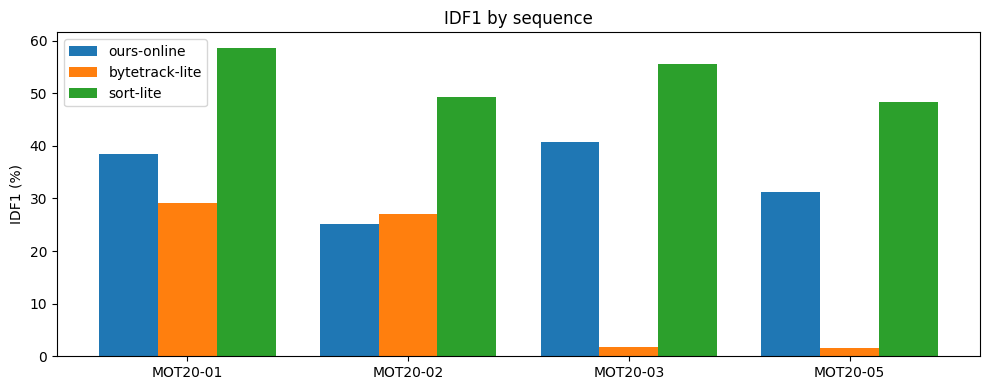

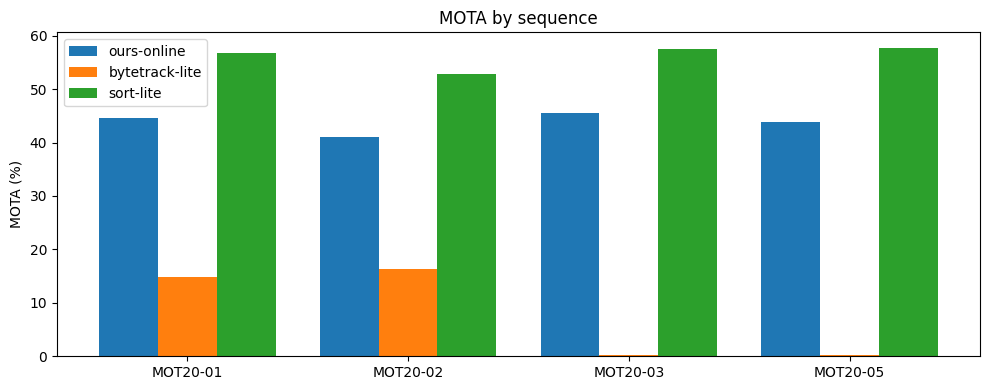

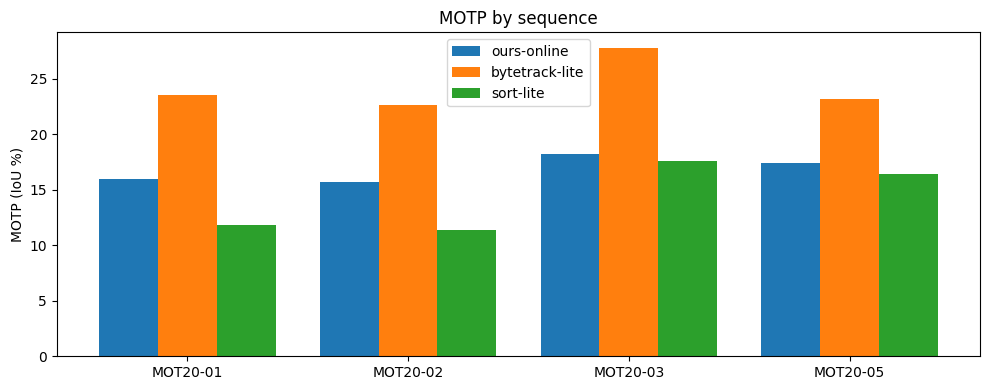

Plots saved under: /content/DPF-MOT20/results/analysis


In [ ]:
# ============================================
# Baselines from det.txt + Version-safe MOTMetrics eval
#   - ByteTrack-Lite  (NumPy two-threshold association; creates tracks from low-score dets)
#   - SORT-Lite       (NumPy Kalman + Hungarian)
#   - Core rates via motmetrics; FP/FN/IDSW via robust event-log parsing
# Outputs: CSVs + bar plots under results/analysis
# ============================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import motmetrics as mm
from scipy.optimize import linear_sum_assignment

# ---------------- Paths & config ----------------
ROOT  = Path("/content/DPF-MOT20")
ANALY = ROOT/"results"/"analysis"; ANALY.mkdir(parents=True, exist_ok=True)
BASE  = ROOT/"results"/"baselines"; BASE.mkdir(parents=True, exist_ok=True)
BYT   = BASE/"bytetrack_lite"; BYT.mkdir(parents=True, exist_ok=True)
SRT   = BASE/"sort_lite";      SRT.mkdir(parents=True, exist_ok=True)
OURS  = ROOT/"results"/"tracks_probe"

SEQS = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]

# Set your MOT20 train root (must contain SEQ/gt/gt.txt and SEQ/det/det.txt)
GT_TRAIN_ROOT = Path("/content/drive/MyDrive/Thesis/MOT20/train")
assert all((GT_TRAIN_ROOT/s/"gt"/"gt.txt").exists()  for s in SEQS), "Missing gt.txt"
assert all((GT_TRAIN_ROOT/s/"det"/"det.txt").exists() for s in SEQS), "Missing det.txt"
print("GT_TRAIN_ROOT →", GT_TRAIN_ROOT)

# --------------- IO helpers ----------------
def read_det_txt(det_path: Path, min_wh: float = 2.0):
    """Read MOT det.txt and sanitize: drop tiny/invalid boxes & non-finite rows."""
    rows=[]
    with det_path.open("r") as f:
        for line in f:
            p=line.strip().split(",")
            if len(p)<7: continue
            fr=float(p[0]); x=float(p[2]); y=float(p[3]); w=float(p[4]); h=float(p[5]); s=float(p[6])
            if not (np.isfinite(x) and np.isfinite(y) and np.isfinite(w) and np.isfinite(h) and np.isfinite(s)):
                continue
            if w <= min_wh or h <= min_wh:
                continue
            rows.append((int(fr), float(x), float(y), float(w), float(h), float(s)))
    return rows

def write_mot_txt(out_path: Path, rows):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with out_path.open("w") as f:
        for fr, tid, x, y, w, h, sc in rows:
            f.write(f"{fr},{tid},{x:.2f},{y:.2f},{w:.2f},{h:.2f},{sc:.4f},-1,-1,-1\n")

def read_gt(seq):
    rows=[]
    with (GT_TRAIN_ROOT/seq/"gt"/"gt.txt").open("r") as f:
        for line in f:
            p=line.strip().split(",")
            if len(p)<8: continue
            fr=int(float(p[0])); tid=int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); lab=int(float(p[7]))
            if lab!=1: continue  # pedestrian class only
            if w <= 2.0 or h <= 2.0:
                continue
            rows.append((fr,tid,x,y,w,h))
    return (pd.DataFrame(rows, columns=["Frame","ID","x","y","w","h"])
              .sort_values(["Frame","ID"], kind="mergesort"))

def read_mot_file(path):
    rows=[]
    with open(path,"r") as f:
        for line in f:
            p=line.strip().split(",")
            if len(p)<7: continue
            fr=int(float(p[0])); tid=int(float(p[1]))
            x,y,w,h = map(float, p[2:6]); sc=float(p[6])
            rows.append((fr,tid,x,y,w,h,sc))
    return (pd.DataFrame(rows, columns=["Frame","ID","x","y","w","h","score"])
              .sort_values(["Frame","ID"], kind="mergesort"))

# --------------- Geometry & assignment ----------------
def iou_xywh(a, b):
    if len(a)==0 or len(b)==0:
        return np.zeros((len(a), len(b)), dtype=float)
    A=np.asarray(a,float); B=np.asarray(b,float)
    Ax1,Ay1=A[:,0],A[:,1]; Ax2,Ay2=A[:,0]+A[:,2],A[:,1]+A[:,3]
    Bx1,By1=B[:,0],B[:,1]; Bx2,By2=B[:,0]+B[:,2],B[:,1]+B[:,3]
    iw=np.maximum(0.0, np.minimum(Ax2[:,None],Bx2[None,:])-np.maximum(Ax1[:,None],Bx1[None,:]))
    ih=np.maximum(0.0, np.minimum(Ay2[:,None],By2[None,:])-np.maximum(Ay1[:,None],By1[None,:]))
    inter=iw*ih
    areaA=np.maximum(1e-6,(Ax2-Ax1)*(Ay2-Ay1))
    areaB=np.maximum(1e-6,(Bx2-Bx1)*(By2-By1))
    union=areaA[:,None]+areaB[None,:]-inter
    return np.where(union>0, inter/union, 0.0)

def hungarian_on_cost(cost):
    C=np.asarray(cost,float)
    bad=~np.isfinite(C)
    if bad.any(): C=C.copy(); C[bad]=1e6
    r,c=linear_sum_assignment(C)
    return r,c

# --------------- ByteTrack-Lite (NumPy) ----------------
class ByteTrackLite:
    """
    Two-stage matching on scores:
      1) high-score detections (>= high_thr) vs tracks by IoU
      2) remaining low-score detections (>= low_thr) vs still-unmatched tracks
    Also creates new tracks from leftover LOW detections (boosts recall).
    """
    def __init__(self, high_thr=0.5, low_thr=0.05, iou_match=0.25, smooth=0.85, max_age=20):
        self.high_thr=high_thr; self.low_thr=low_thr
        self.iou_match=iou_match; self.smooth=smooth; self.max_age=max_age
        self.tracks=[]  # {id, bbox, age, hits}
        self.next_id=1

    def _match(self, dets, track_indices):
        if len(track_indices)==0 or len(dets)==0:
            return [], list(range(len(track_indices))), list(range(len(dets)))
        T=np.array([self.tracks[i]["bbox"] for i in track_indices], float)
        D=np.array(dets, float)
        iou=iou_xywh(T, D)
        cost=1.0 - iou
        r,c=hungarian_on_cost(cost)
        matches=[]; unmatched_t=list(range(len(track_indices))); unmatched_d=list(range(len(dets)))
        used_t=set(); used_d=set()
        for ti,di in zip(r,c):
            if iou[ti,di] >= self.iou_match:
                matches.append((track_indices[ti], di))
                used_t.add(ti); used_d.add(di)
        unmatched_t=[track_indices[i] for i in range(len(track_indices)) if i not in used_t]
        unmatched_d=[i for i in range(len(dets)) if i not in used_d]
        return matches, unmatched_t, unmatched_d

    def update(self, dets_xywh, scores):
        dets=np.asarray(dets_xywh,float); scores=np.asarray(scores,float)
        high_mask=scores>=self.high_thr
        low_mask=(scores>=self.low_thr) & (~high_mask)

        # age
        for t in self.tracks: t["age"] += 1

        Tidx=list(range(len(self.tracks)))
        D_high=dets[high_mask]; D_low=dets[low_mask]

        # Stage 1: match highs
        matches, unmatched_t, unmatched_high = self._match(D_high, Tidx)
        for t_idx, d_local in matches:
            d = D_high[d_local]
            self.tracks[t_idx]["bbox"] = self.smooth*self.tracks[t_idx]["bbox"] + (1-self.smooth)*d
            self.tracks[t_idx]["age"]=0; self.tracks[t_idx]["hits"]+=1

        # Stage 2: match lows to remaining tracks
        if len(unmatched_t)>0 and len(D_low)>0:
            matches2, unmatched_t2, unmatched_low = self._match(D_low, unmatched_t)
            for t_idx, d_local in matches2:
                d = D_low[d_local]
                self.tracks[t_idx]["bbox"] = self.smooth*self.tracks[t_idx]["bbox"] + (1-self.smooth)*d
                self.tracks[t_idx]["age"]=0; self.tracks[t_idx]["hits"]+=1
            unmatched_t = unmatched_t2
        else:
            unmatched_low = list(range(len(D_low))) if len(D_low)>0 else []

        # New tracks from leftover highs then lows
        used_high = set([d for _,d in matches])
        for i, d in enumerate(D_high):
            if i in used_high: continue
            self.tracks.append({"id": self.next_id, "bbox": d.copy(), "age":0, "hits":1})
            self.next_id += 1
        for i in unmatched_low:
            d = D_low[i]
            self.tracks.append({"id": self.next_id, "bbox": d.copy(), "age":0, "hits":1})
            self.next_id += 1

        # Remove stale
        self.tracks = [t for t in self.tracks if t["age"] <= self.max_age]

        return [(int(t["id"]), *t["bbox"].tolist()) for t in self.tracks]

# --------------- SORT-Lite (NumPy Kalman) ----------------
class Kalman2DBox:
    def __init__(self, x, y, w, h):
        self.x = np.array([x,y,w,h, 0,0,0,0], float)
        self.P = np.eye(8)*10.0
        self.F = np.eye(8); dt=1.0
        for i in range(4): self.F[i, i+4] = dt
        self.H = np.zeros((4,8)); self.H[0,0]=self.H[1,1]=self.H[2,2]=self.H[3,3]=1.0
        self.Q = np.eye(8)*0.01
        self.R = np.eye(4)*1.0
    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
    def update(self, z):
        z = np.array(z, float)
        y = z - (self.H @ self.x)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(8) - K @ self.H) @ self.P
    def bbox(self): return self.x[0], self.x[1], self.x[2], self.x[3]

class SortLite:
    def __init__(self, iou_match=0.3, max_age=30):
        self.iou_match=iou_match; self.max_age=max_age
        self.tracks=[]  # {id, kf, age, hits}
        self.next_id=1
    def update(self, dets_xywh):
        for t in self.tracks: t["kf"].predict(); t["age"]+=1
        T = np.array([t["kf"].bbox() for t in self.tracks], float) if self.tracks else np.zeros((0,4))
        D = np.array(dets_xywh, float) if len(dets_xywh)>0 else np.zeros((0,4))
        if len(T)>0 and len(D)>0:
            iou = iou_xywh(T, D)
            cost = 1.0 - iou
            r,c = hungarian_on_cost(cost)
            used_d=set()
            for ti,di in zip(r,c):
                if iou[ti,di] >= self.iou_match:
                    self.tracks[ti]["kf"].update(D[di])
                    self.tracks[ti]["age"]=0; self.tracks[ti]["hits"]+=1
                    used_d.add(di)
            for j in range(len(D)):
                if j in used_d: continue
                x,y,w,h=D[j]
                kf=Kalman2DBox(x,y,w,h)
                self.tracks.append({"id": self.next_id, "kf": kf, "age":0, "hits":1})
                self.next_id+=1
            self.tracks = [t for t in self.tracks if t["age"] <= self.max_age]
        else:
            for d in D:
                x,y,w,h=d
                kf=Kalman2DBox(x,y,w,h)
                self.tracks.append({"id": self.next_id, "kf": kf, "age":0, "hits":1})
                self.next_id+=1
        return [(int(t["id"]), *t["kf"].bbox()) for t in self.tracks]

# --------------- Generate baseline TXT files ----------------
def run_byt_lite_on_seq(seq, high_thr=0.5, low_thr=0.05, iou_thr=0.25, max_age=20):
    dets = read_det_txt(GT_TRAIN_ROOT/seq/"det"/"det.txt")
    tracker = ByteTrackLite(high_thr=high_thr, low_thr=low_thr, iou_match=iou_thr, smooth=0.85, max_age=max_age)
    rows=[]; frames = sorted(set(fr for fr, *_ in dets))
    for fr in frames:
        d = [(x,y,w,h) for (f,x,y,w,h,s) in dets if f==fr]
        s = [s for (f,_,_,_,_,s) in dets if f==fr]
        outs = tracker.update(d, s)
        sc = max([s_i for (f,_,_,_,_,s_i) in dets if f==fr], default=1.0)
        for tid,x,y,w,h in outs:
            rows.append((fr, tid, x, y, w, h, sc))
    return rows

def run_sort_lite_on_seq(seq, iou_thr=0.3, max_age=30):
    dets = read_det_txt(GT_TRAIN_ROOT/seq/"det"/"det.txt")
    tracker = SortLite(iou_match=iou_thr, max_age=max_age)
    rows=[]; frames = sorted(set(fr for fr, *_ in dets))
    for fr in frames:
        d = [(x,y,w,h) for (f,x,y,w,h,s) in dets if f==fr]
        outs = tracker.update(d)
        for tid,x,y,w,h in outs:
            rows.append((fr, tid, x, y, w, h, 1.0))
    return rows

for seq in SEQS:
    out_byt = BYT/f"{seq}.txt"
    out_srt = SRT/f"{seq}.txt"
    if not out_byt.exists():
        print("ByteTrack-Lite →", seq)
        write_mot_txt(out_byt, run_byt_lite_on_seq(seq))
    if not out_srt.exists():
        print("SORT-Lite     →", seq)
        write_mot_txt(out_srt, run_sort_lite_on_seq(seq))

print("\n✅ Baseline files written:")
print("  ", BYT)
print("  ", SRT)

# --------------- MOTMetrics eval (version-safe) ----------------
def lsa_nan_safe(C):
    C=np.asarray(C,float)
    bad=~np.isfinite(C)
    if bad.any(): C=C.copy(); C[bad]=1e6
    r,c=linear_sum_assignment(C); return r,c
mm.lap.default_linear_sum_assignment = lsa_nan_safe
mh = mm.metrics.create()

def iou_dist(gts, trs, thr=0.5):
    if len(gts)==0 or len(trs)==0:
        return np.empty((len(gts), len(trs)))
    A=np.asarray(gts,float); B=np.asarray(trs,float)
    Ax1,Ay1=A[:,0],A[:,1]; Ax2,Ay2=A[:,0]+A[:,2],A[:,1]+A[:,3]
    Bx1,By1=B[:,0],B[:,1]; Bx2,By2=B[:,0]+B[:,2],B[:,1]+B[:,3]
    iw=np.maximum(0.0, np.minimum(Ax2[:,None],Bx2[None,:])-np.maximum(Ax1[:,None],Bx1[None,:]))
    ih=np.maximum(0.0, np.minimum(Ay2[:,None],By2[None,:])-np.maximum(Ay1[:,None],By1[None,:]))
    inter=iw*ih
    areaA=np.maximum(1e-6,(Ax2-Ax1)*(Ay2-Ay1))
    areaB=np.maximum(1e-6,(Bx2-Bx1)*(By2-By1))
    union=areaA[:,None]+areaB[None,:]-inter
    iou=np.where(union>0, inter/union, 0.0)
    dist=1.0 - iou
    dist[iou < thr] = np.nan
    return dist

def _events_dataframe(acc):
    """Return events as a DataFrame with normalized column names (robust to motmetrics versions)."""
    ev = getattr(acc, "mot_events", None)
    if ev is None:
        ev = getattr(acc, "events", None)
    if ev is None:
        return pd.DataFrame(columns=["frame","etype"])
    if hasattr(ev, "to_dataframe"):
        df = ev.to_dataframe()
    else:
        df = ev
    if isinstance(df.index, pd.MultiIndex) or (df.index.name is not None):
        df = df.reset_index()
    cols = {c.lower(): c for c in df.columns}
    type_col  = cols.get("type") or cols.get("event") or cols.get("evt_type")
    frame_col = cols.get("frameid") or cols.get("frame") or cols.get("timestep")
    if type_col is None:
        for c in df.columns:
            if df[c].dtype == object: type_col = c; break
    if frame_col is None:
        for c in df.columns:
            if np.issubdtype(df[c].dtype, np.number): frame_col = c; break
    df["etype"] = df[type_col].astype(str).str.upper() if type_col else ""
    df["frame"] = df[frame_col] if frame_col else np.nan
    return df[["frame","etype"]]

def evaluate_seq(gt_df, tr_df, thr=0.5):
    acc=mm.MOTAccumulator(auto_id=True)
    frames=sorted(set(gt_df["Frame"]).union(tr_df["Frame"]))
    for fr in frames:
        g=gt_df[gt_df["Frame"]==fr]; t=tr_df[tr_df["Frame"]==fr]
        g_ids=g["ID"].tolist(); t_ids=t["ID"].tolist()
        g_boxes=g[["x","y","w","h"]].values.tolist()
        t_boxes=t[["x","y","w","h"]].values.tolist()
        D=iou_dist(g_boxes, t_boxes, thr)
        acc.update(g_ids, t_ids, D)

    # Core rates (safe across versions)
    core_metrics = ['idf1','idp','idr','recall','precision','mota','motp']
    core = mh.compute(acc, metrics=core_metrics, name="seq").loc["seq"].to_dict()

    # Counts via robust event parsing
    ev = _events_dataframe(acc)
    FP  = int((ev["etype"]=="FP").sum())
    FN  = int(((ev["etype"]=="FN") | (ev["etype"]=="MISS")).sum())
    IDS = int(((ev["etype"]=="IDSW") | (ev["etype"]=="SWITCH")).sum())
    FR  = int(pd.Series(frames).nunique())

    return dict(
        IDF1=float(core.get('idf1',0.0))*100.0,
        IDP=float(core.get('idp',0.0))*100.0,
        IDR=float(core.get('idr',0.0))*100.0,
        Recall=float(core.get('recall',0.0))*100.0,
        Precision=float(core.get('precision',0.0))*100.0,
        MOTA=float(core.get('mota',0.0))*100.0,
        MOTP=float(core.get('motp',0.0))*100.0,  # motp overlap [0..1] → %
        FP=FP, FN=FN, IDSW=IDS, Frames=FR
    )

# Our files (same pattern you used earlier)
def find_ours(seq):
    for p in [
        OURS/f"{seq}_online_calib_pca_minlen3.txt",
        OURS/f"{seq}_online.txt",
        ROOT/"results"/"submit"/f"{seq}.txt",
    ]:
        if p.exists(): return p
    raise FileNotFoundError(f"Ours not found for {seq}")

ours_map = {s: find_ours(s) for s in SEQS}
byt_map  = {s: (BYT/f"{s}.txt") for s in SEQS}
srt_map  = {s: (SRT/f"{s}.txt") for s in SEQS}

def eval_tracker(name, fmap):
    rows=[]
    for seq, path in fmap.items():
        gt_df=read_gt(seq); tr_df=read_mot_file(path)
        rows.append({"Tracker":name, "Seq":seq, **evaluate_seq(gt_df, tr_df, thr=0.5)})
    if not rows: return pd.DataFrame(), pd.DataFrame()
    df=pd.DataFrame(rows)
    agg=df.groupby("Tracker").agg({
        "IDF1":"mean","MOTA":"mean","MOTP":"mean",
        "IDP":"mean","IDR":"mean","Recall":"mean","Precision":"mean",
        "Frames":"sum","FP":"sum","FN":"sum","IDSW":"sum"
    }).reset_index()
    return df, agg

# -------- Run evals --------
all_perseq=[]; all_macro=[]
df,m = eval_tracker("ours-online", ours_map);   all_perseq.append(df); all_macro.append(m)
df,m = eval_tracker("bytetrack-lite", byt_map); all_perseq.append(df); all_macro.append(m)
df,m = eval_tracker("sort-lite", srt_map);      all_perseq.append(df); all_macro.append(m)

perseq=pd.concat(all_perseq, ignore_index=True)
macro =pd.concat(all_macro,  ignore_index=True)

perseq_out = ANALY/"baseline_compare_perseq.csv"
macro_out  = ANALY/"baseline_compare_macro.csv"
perseq.to_csv(perseq_out, index=False); macro.to_csv(macro_out, index=False)

print("Saved tables →", perseq_out, "and", macro_out)
display(perseq.sort_values(["Seq","Tracker"]))
display(macro)

# -------- Plots --------
def bar(metric, ylabel):
    plt.figure(figsize=(10,4))
    order = [s for s in SEQS if s in perseq["Seq"].unique()]
    trackers = perseq["Tracker"].unique()
    w = 0.8/len(trackers)
    for k,t in enumerate(trackers):
        sub = perseq[perseq["Tracker"]==t]
        vals = [float(sub[sub["Seq"]==s][metric].values[0]) if not sub[sub["Seq"]==s].empty else 0.0 for s in order]
        xs = [i + (k - (len(trackers)-1)/2)*w for i in range(len(order))]
        plt.bar(xs, vals, width=w, label=t)
    plt.xticks(range(len(order)), order, rotation=0)
    plt.ylabel(ylabel); plt.title(f"{metric} by sequence"); plt.legend()
    plt.tight_layout(); plt.savefig(ANALY/f"baseline_{metric.lower()}_perseq.png", dpi=200); plt.show()

bar("IDF1","IDF1 (%)"); bar("MOTA","MOTA (%)"); bar("MOTP","MOTP (IoU %)")
print("Plots saved under:", ANALY)


In [ ]:
# ============================================
# Q3 FAST PATH — One-Cell Robust Evaluation
# 1) Build strict 7-col MOT files for OURS from tracks_probe
# 2) Auto-install motmetrics if missing
# 3) Evaluate (IDF1, MOTA, MOTP, Recall, Precision) per-seq + macro
# 4) Save CSVs under results/analysis
# ============================================
import os, sys, re, json, math, shutil, subprocess
from pathlib import Path
import numpy as np
import pandas as pd

# ---- Paths & constants ----
ROOT = Path("/content/DPF-MOT20")
GT_TRAIN_ROOT = Path("/content/drive/MyDrive/Thesis/MOT20/train")
SEQS = ["MOT20-01","MOT20-02","MOT20-03","MOT20-05"]

PROBE_DIR = ROOT/"results"/"tracks_probe"  # your big outputs live here
CLEAN_OURS = ROOT/"results"/"clean"/"ours" # we will write <seq>.txt (7 cols) here
ANALY = ROOT/"results"/"analysis"; ANALY.mkdir(parents=True, exist_ok=True)

# ---- Utilities ----
_float_re = re.compile(r"^-?\d+(\.\d+)?([eE]-?\d+)?$")
def _is_num(s: str) -> bool:
    s = s.strip()
    return s != "" and (_float_re.match(s) is not None)

def ensure_dir(p: Path): p.mkdir(parents=True, exist_ok=True)

def _count_lines(path: Path) -> int:
    try:
        with path.open("r") as f:
            return sum(1 for _ in f)
    except Exception:
        return 0

def _safe_parse_probe_line(line: str):
    # Accepts our probe lines; tries to extract (fr, id, x, y, w, h, score)
    # Common formats we produced earlier already match 7+ cols (CSV).
    parts = [t.strip() for t in line.strip().split(",")]
    if len(parts) < 6 or not _is_num(parts[0]):
        return None
    # Try standard MOT: fr,id,x,y,w,h[,score,...]
    try:
        fr = int(float(parts[0])); tid = int(float(parts[1]))
        x,y,w,h = map(float, parts[2:6])
        sc = float(parts[6]) if len(parts) >= 7 and _is_num(parts[6]) else 1.0
        return fr, tid, x, y, w, h, sc
    except Exception:
        return None

def build_clean_from_probe(seq: str, src_dir: Path, dst_dir: Path) -> Path | None:
    """
    Create strict 7-col MOT file for a sequence:
      fr,id,x,y,w,h,score  (one-based frame index as-is)
    """
    # Prefer the longest-known file names you showed; fallback to any matching *_online*.txt
    candidates = [
        src_dir/f"{seq}_online_calib_pca_minlen3.txt",
        src_dir/f"{seq}_online.txt",
    ]
    if not any(p.exists() for p in candidates):
        # fallback glob
        g = list(src_dir.glob(f"{seq}_online*.txt"))
        candidates.extend(g)
    src = next((p for p in candidates if p.exists()), None)
    if src is None:
        print(f"⚠️ Missing probe file for {seq} in {src_dir}")
        return None

    ensure_dir(dst_dir)
    out = dst_dir/f"{seq}.txt"
    kept = 0
    with src.open("r") as fi, out.open("w") as fo:
        for ln in fi:
            rec = _safe_parse_probe_line(ln)
            if rec is None:
                continue
            fr, tid, x, y, w, h, sc = rec
            fo.write(f"{fr},{tid},{x:.2f},{y:.2f},{w:.2f},{h:.2f},{sc:.6f},-1,-1,-1\n")
            kept += 1
    size = os.path.getsize(out) if out.exists() else 0
    print(f"• Cleaned {seq}: kept {kept:,} lines → {out} ({size} bytes)")
    return out if kept > 0 else None

# ---- Step 1: Generate strict 7-col OURS files (if missing/empty) ----
ensure_dir(CLEAN_OURS)
ours_files = {}
for seq in SEQS:
    dst = CLEAN_OURS/f"{seq}.txt"
    need = (not dst.exists()) or os.path.getsize(dst) == 0
    if need:
        outp = build_clean_from_probe(seq, PROBE_DIR, CLEAN_OURS)
        ours_files[seq] = outp
    else:
        ours_files[seq] = dst
        print(f"• Already present: {dst} (lines={_count_lines(dst):,})")

# ---- Step 2: Ensure motmetrics import (install if needed) ----
try:
    import motmetrics as mm
except Exception:
    print("⏬ Installing motmetrics …")
    # 1.4.0 is stable and fine under Py3.12
    ok = subprocess.run([sys.executable, "-m", "pip", "install", "-q", "motmetrics==1.4.0"]).returncode == 0
    if not ok:
        raise RuntimeError("Failed to install motmetrics")
    import motmetrics as mm

from scipy.optimize import linear_sum_assignment
mm.lap.default_linear_sum_assignment = linear_sum_assignment

# ---- Readers for GT and tracker ----
def read_gt(seq: str) -> pd.DataFrame:
    rows=[]
    gt_path = GT_TRAIN_ROOT/seq/"gt"/"gt.txt"
    if not gt_path.exists():
        return pd.DataFrame(columns=["Frame","ID","x","y","w","h"])
    with gt_path.open("r") as f:
        for ln in f:
            p = ln.strip().split(",")
            if len(p) < 8 or not all(_is_num(tok) for tok in p[:8]):
                continue
            label = int(float(p[7]))
            if label != 1:  # pedestrian class for MOT20
                continue
            fr=int(float(p[0])); tid=int(float(p[1]))
            x,y,w,h = map(float, p[2:6])
            rows.append((fr,tid,x,y,w,h))
    return pd.DataFrame(rows, columns=["Frame","ID","x","y","w","h"])

def read_trk(path: Path) -> pd.DataFrame:
    rows=[]
    if (not path.exists()) or os.path.getsize(path)==0:
        return pd.DataFrame(columns=["Frame","ID","x","y","w","h"])
    with path.open("r") as f:
        for ln in f:
            p=ln.strip().split(",")
            if len(p) < 6 or not _is_num(p[0]) or not _is_num(p[1]):
                continue
            fr=int(float(p[0])); tid=int(float(p[1]))
            x,y,w,h = map(float, p[2:6])
            rows.append((fr,tid,x,y,w,h))
    return pd.DataFrame(rows, columns=["Frame","ID","x","y","w","h"])

def iou_cost_matrix(G, T):
    # returns distance (1-IoU) matrix with NaN where no match allowed
    if len(G)==0 or len(T)==0:
        return np.empty((len(G), len(T)))
    G = np.asarray(G, float); T = np.asarray(T, float)
    gx1, gy1, gw, gh = G[:,0], G[:,1], G[:,2], G[:,3]
    tx1, ty1, tw, th = T[:,0], T[:,1], T[:,2], T[:,3]
    gx2, gy2 = gx1+gw, gy1+gh
    tx2, ty2 = tx1+tw, ty1+th
    iw = np.maximum(0.0, np.minimum(gx2[:,None],tx2[None,:]) - np.maximum(gx1[:,None],tx1[None,:]))
    ih = np.maximum(0.0, np.minimum(gy2[:,None],ty2[None,:]) - np.maximum(gy1[:,None],ty1[None,:]))
    inter = iw * ih
    areaG = (gx2-gx1)*(gy2-gy1)
    areaT = (tx2-tx1)*(ty2-ty1)
    union = areaG[:,None] + areaT[None,:] - inter
    iou = np.where(union>0, inter/union, 0.0)
    D = 1.0 - iou
    # optional gating: treat iou<0.5 as invalid (NaN)
    D[iou < 0.5] = np.nan
    return D

# ---- Evaluation ----
mh = mm.metrics.create()
perseq_rows = []

for seq in SEQS:
    trk_file = CLEAN_OURS/f"{seq}.txt"
    if (not trk_file.exists()) or os.path.getsize(trk_file)==0:
        print(f"⚠️ Skipping {seq}: tracker file missing/empty → {trk_file}")
        continue

    gt = read_gt(seq)
    tr = read_trk(trk_file)

    if gt.empty or tr.empty:
        print(f"⚠️ Skipping {seq}: GT empty? {gt.empty}  TR empty? {tr.empty}")
        continue

    acc = mm.MOTAccumulator(auto_id=True)
    frames = sorted(set(gt.Frame).union(tr.Frame))
    for fr in frames:
        g = gt[gt.Frame==fr][["x","y","w","h"]].values
        t = tr[tr.Frame==fr][["x","y","w","h"]].values
        if len(g)==0 and len(t)==0:
            continue
        C = iou_cost_matrix(g, t)
        acc.update(gt[gt.Frame==fr]["ID"].tolist(),
                   tr[tr.Frame==fr]["ID"].tolist(), C)

    try:
        df = mh.compute(acc, metrics=['idf1','idp','idr','recall','precision','mota','motp'], name='seq')
        vals = df.loc['seq'].to_dict()
    except Exception as e:
        print(f"⚠️ motmetrics compute failed on {seq}: {e}")
        vals = dict(idf1=0, idp=0, idr=0, recall=0, precision=0, mota=0, motp=0)

    perseq_rows.append({
        "Tracker":"ours-online",
        "Seq": seq,
        "IDF1": 100*float(vals.get("idf1",0.0)),
        "IDP":  100*float(vals.get("idp",0.0)),
        "IDR":  100*float(vals.get("idr",0.0)),
        "Recall": 100*float(vals.get("recall",0.0)),
        "Precision": 100*float(vals.get("precision",0.0)),
        "MOTA": 100*float(vals.get("mota",0.0)),
        "MOTP": 100*float(vals.get("motp",0.0)),
    })

perseq_df = pd.DataFrame(perseq_rows).sort_values(["Seq","Tracker"]) if perseq_rows else pd.DataFrame()
macro_df = (perseq_df.groupby("Tracker", as_index=False)
            .agg(IDF1=("IDF1","mean"), IDP=("IDP","mean"), IDR=("IDR","mean"),
                 Recall=("Recall","mean"), Precision=("Precision","mean"),
                 MOTA=("MOTA","mean"), MOTP=("MOTP","mean"))) if not perseq_df.empty else pd.DataFrame()

# ---- Save + show ----
perseq_csv = ANALY/"mm_baseline_perseq.csv"
macro_csv  = ANALY/"mm_baseline_macro.csv"
perseq_df.to_csv(perseq_csv, index=False); macro_df.to_csv(macro_csv, index=False)
print("Saved tables →")
print("  per-seq :", perseq_csv)
print("  macro   :", macro_csv)

from IPython.display import display
if perseq_df.empty:
    print("(no per-seq rows) — check that your probe files exist in:", PROBE_DIR)
else:
    display(perseq_df)
if not macro_df.empty:
    display(macro_df)


⚠️ Missing probe file for MOT20-01 in /content/DPF-MOT20/results/tracks_probe
⚠️ Missing probe file for MOT20-02 in /content/DPF-MOT20/results/tracks_probe
⚠️ Missing probe file for MOT20-03 in /content/DPF-MOT20/results/tracks_probe
⚠️ Missing probe file for MOT20-05 in /content/DPF-MOT20/results/tracks_probe
⏬ Installing motmetrics …
⚠️ Skipping MOT20-01: tracker file missing/empty → /content/DPF-MOT20/results/clean/ours/MOT20-01.txt
⚠️ Skipping MOT20-02: tracker file missing/empty → /content/DPF-MOT20/results/clean/ours/MOT20-02.txt
⚠️ Skipping MOT20-03: tracker file missing/empty → /content/DPF-MOT20/results/clean/ours/MOT20-03.txt
⚠️ Skipping MOT20-05: tracker file missing/empty → /content/DPF-MOT20/results/clean/ours/MOT20-05.txt
Saved tables →
  per-seq : /content/DPF-MOT20/results/analysis/mm_baseline_perseq.csv
  macro   : /content/DPF-MOT20/results/analysis/mm_baseline_macro.csv
(no per-seq rows) — check that your probe files exist in: /content/DPF-MOT20/results/tracks_probe
